## Guardians of the Crypto
### A Streamlit Application for Enhanced Price Prediction and Informed Decision-Making
###### by Mirna Philip, Justin Farnan and Arya Shahbazi

###### The cryptocurrency market is very unpredictable, with prices changing a lot in a short time, making it hard for investors and traders to make good decisions. Our project, Guardians of the Crypto, aims to solve this problem by using past price data and sentiment analysis to predict changes in cryptocurrency prices. By combining these methods, we want to create a reliable tool that helps traders and investors understand the market better and make confident decisions. Studies have shown that social media sentiment, especially from platforms like Reddit, can affect cryptocurrency prices. Our main goals are to collect past price data for major cryptocurrencies using the Coinbase API and gather sentiment data from Reddit using natural language processing (NLP) tools. We will clean and prepare this data, analyze Reddit posts to determine market sentiment, and train different machine learning models, including simple models like Linear Regression and advanced ones like Long Short-Term Memory (LSTM) networks, to predict cryptocurrency price changes accurately. We will evaluate these models, improve the best one, and develop a Streamlit application that combines sentiment analysis, past price data, and other trading metrics to help cryptocurrency traders and investors make better decisions in a volatile market.

In [37]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import statsmodels.api as sm
import matplotlib.dates as mdates
import plotly.express as px

In [38]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pytz
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
#import shap
from historic_api_pulls.extract_coinbase import combine_price_data, previous_week

In [39]:
# Configuration to suppress warnings
warnings.filterwarnings('ignore')

# Additional configurations for better control over visualizations (optional)
plt.style.use('ggplot')  # For ggplot-like style in plots
pd.options.display.max_columns = None  # Ensure all columns are visible when displaying DataFrames

#### Data Inspection and Understanding

In [40]:
filePath = 'RAW_Data/updated_data_715.csv'
# Loading the CSV file
data = pd.read_csv(filePath)

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
data.head(2)


First few rows of the dataset:


Unnamed: 0        time      low     high     open    close         volume  \
0           0  2021-07-16  1850.15  1965.35  1918.99  1877.22  184221.682009   
1           1  2021-07-16   367.10   410.50   398.45   367.89   23815.536000   

   price_change  average_price  volatility product_id     load_dt  
0        -41.77        1907.75    6.226522    ETH-USD  2024-07-15  
1        -30.56         388.80   11.822392   COMP-USD  2024-07-15

In [41]:
def print_dataframe_shape(df, name):
    rows, columns = df.shape
    print(f"{name} database has {rows} rows and {columns} columns.")

print_dataframe_shape(data, "Cryptocurrency")

Cryptocurrency database has 10764 rows and 12 columns.


In [42]:
print(data.columns.tolist())

['Unnamed: 0', 'time', 'low', 'high', 'open', 'close', 'volume', 'price_change', 'average_price', 'volatility', 'product_id', 'load_dt']


In [43]:
data['product_id'].value_counts()

product_id
ETH-USD      1084
COMP-USD     1084
SOL-USD      1084
UNI-USD      1084
ADA-USD      1084
MATIC-USD    1084
BTC-USD      1084
LINK-USD     1084
LTC-USD      1084
AVAX-USD     1008
Name: count, dtype: int64

In [44]:
def separateCryptoData(data):
    cryptoDfs = {}
    unique_product_ids = data['product_id'].unique()
    
    for product_id in unique_product_ids:
        cryptoDfs[product_id] = data[data['product_id'] == product_id]
    
    return cryptoDfs

# Example usage
cryptoDfs = separateCryptoData(data)

# Access individual DataFrames
SOLdf = cryptoDfs.get('SOL-USD')
BTCdf = cryptoDfs.get('BTC-USD')
ETHdf = cryptoDfs.get('ETH-USD') 
ADAdf = cryptoDfs.get('ADA-USD')
LINKdf = cryptoDfs.get('LINK-USD')
LTCdf = cryptoDfs.get('LTC-USD')
COMPdf = cryptoDfs.get('COMP-USD')
UNIdf = cryptoDfs.get('UNI-USD')
MATICdf = cryptoDfs.get('MATIC-USD')
AVAXdf = cryptoDfs.get('AVAX-USD')

In [45]:
# Display basic information about the dataframe
def basicInformation(name, cryptoDfs):
    print(f"\nBasic information about the {name}:")
    cryptoDfs.info()
    print("\n" + "="*50 + "\n")
    
cryptos_info = {
    'SOL': SOLdf,
    'BTC': BTCdf,
    'ETH': ETHdf,
    'ADA': ADAdf,
    'LINK': LINKdf,
    'LTC': LTCdf,
    'COMP': COMPdf,
    'UNI': UNIdf,
    'MATIC': MATICdf,
    'AVAX': AVAXdf
}

for name, df in cryptos_info.items():
    basicInformation(name, df)


Basic information about the SOL:
<class 'pandas.core.frame.DataFrame'>
Index: 1084 entries, 2 to 10759
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1084 non-null   int64  
 1   time           1084 non-null   object 
 2   low            1084 non-null   float64
 3   high           1084 non-null   float64
 4   open           1084 non-null   float64
 5   close          1084 non-null   float64
 6   volume         1084 non-null   float64
 7   price_change   1084 non-null   float64
 8   average_price  1084 non-null   float64
 9   volatility     1084 non-null   float64
 10  product_id     1084 non-null   object 
 11  load_dt        1084 non-null   object 
dtypes: float64(8), int64(1), object(3)
memory usage: 110.1+ KB



Basic information about the BTC:
<class 'pandas.core.frame.DataFrame'>
Index: 1084 entries, 6 to 10758
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  


In [46]:
# Display summary statistics for the numerical columns
def summaryStatistics(name, cryptoData):
    print(f"\nSummary statistics for the {name}:")
    print(cryptoData.describe())
    print("\n" + "="*50 + "\n")
    
for name, df in cryptos_info.items():
    summaryStatistics(name, df)


Summary statistics for the SOL:
         Unnamed: 0          low         high         open        close  \
count   1084.000000  1084.000000  1084.000000  1084.000000  1084.000000   
mean    5346.196494    72.710804    79.517627    76.127454    76.224912   
std     3126.269169    58.815262    64.287609    61.716893    61.730956   
min        2.000000     8.000000    10.080000     9.640000     9.640000   
25%     2635.000000    22.430000    24.007500    23.227500    23.222500   
50%     5341.500000    40.668000    44.934500    42.940000    43.020000   
75%     8048.750000   119.000000   134.800000   126.697500   127.055000   
max    10759.000000   245.800000   260.000000   258.764000   258.763000   

             volume  price_change  average_price   volatility  
count  1.084000e+03   1084.000000    1084.000000  1084.000000  
mean   1.719436e+06      0.097458      76.114215     9.222046  
std    1.446550e+06      5.279503      61.507952     6.635552  
min    1.876976e+05    -26.140000  

In [47]:
# Check for missing values
def checkMissingValues(name, cryptoData):
    print(f"\nMissing values in the {name}:")
    print(cryptoData.isnull().sum())
    print("\n" + "="*50 + "\n")

for name, df in cryptos_info.items():
    checkMissingValues(name, df)


Missing values in the SOL:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatility       0
product_id       0
load_dt          0
dtype: int64



Missing values in the BTC:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatility       0
product_id       0
load_dt          0
dtype: int64



Missing values in the ETH:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatility       0
product_id       0
load_dt          0
dtype: int64



Missing values in the ADA:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average

In [48]:
def checkDuplicateValues(name, cryptoData):
    print(f"\nDuplicate values in the {name}:")
    print(cryptoData.duplicated().sum())
    print("\n" + "="*50 + "\n")

for name, df in cryptos_info.items():
    checkDuplicateValues(name, df)


Duplicate values in the SOL:
0



Duplicate values in the BTC:
0



Duplicate values in the ETH:
0



Duplicate values in the ADA:
0



Duplicate values in the LINK:
0



Duplicate values in the LTC:
0



Duplicate values in the COMP:
0



Duplicate values in the UNI:
0



Duplicate values in the MATIC:
0



Duplicate values in the AVAX:
0




In [49]:
# Check the distribution of product IDs
def checkProductIDDistribution(name, data):
    print(f"\nDistribution of product IDs for {name}:")
    print(data['product_id'].value_counts())
    print("\n" + "="*50 + "\n")

for name, df in cryptos_info.items():
    checkProductIDDistribution(name, df)


Distribution of product IDs for SOL:
product_id
SOL-USD    1084
Name: count, dtype: int64



Distribution of product IDs for BTC:
product_id
BTC-USD    1084
Name: count, dtype: int64



Distribution of product IDs for ETH:
product_id
ETH-USD    1084
Name: count, dtype: int64



Distribution of product IDs for ADA:
product_id
ADA-USD    1084
Name: count, dtype: int64



Distribution of product IDs for LINK:
product_id
LINK-USD    1084
Name: count, dtype: int64



Distribution of product IDs for LTC:
product_id
LTC-USD    1084
Name: count, dtype: int64



Distribution of product IDs for COMP:
product_id
COMP-USD    1084
Name: count, dtype: int64



Distribution of product IDs for UNI:
product_id
UNI-USD    1084
Name: count, dtype: int64



Distribution of product IDs for MATIC:
product_id
MATIC-USD    1084
Name: count, dtype: int64



Distribution of product IDs for AVAX:
product_id
AVAX-USD    1008
Name: count, dtype: int64




#### Exploratory Data Analysis (EDA)

In [50]:
#ARYA
# Remove the 'Unnamed: 0' column and other columns as it's redundant
data.drop(columns=['Unnamed: 0','load_dt'], inplace=True)

# Sort the DataFrame by the 'time' column
data.sort_values(by='time', ascending=True, inplace=True)

# Set 'time' as the index of the DataFrame
data.set_index('time', inplace=True)

# Calculate daily percentage change in 'close' price
data['pct_change'] = data['close'].pct_change() # Keeping it in decimal format for more accurate results

# Print the updated DataFrame to verify changes
print("Updated DataFrame with Daily Frequency and Interpolated Values:")
print(data.head())

# Review unique counts of product IDs if necessary
print("\nCount of unique product IDs:")
print(data['product_id'].value_counts())

Updated DataFrame with Daily Frequency and Interpolated Values:
                  low       high       open      close        volume  \
time                                                                   
2021-07-16  1850.1500  1965.3500  1918.9900  1877.2200  1.842217e+05   
2021-07-16   367.1000   410.5000   398.4500   367.8900  2.381554e+04   
2021-07-16    26.2040    29.4800    28.5750    26.2960  3.369130e+05   
2021-07-16    15.9297    17.5908    17.0647    16.3449  5.165473e+05   
2021-07-16     1.1661     1.2452     1.2249     1.1714  3.676491e+07   

            price_change  average_price  volatility product_id  pct_change  
time                                                                        
2021-07-16      -41.7700     1907.75000    6.226522    ETH-USD         NaN  
2021-07-16      -30.5600      388.80000   11.822392   COMP-USD   -0.804024  
2021-07-16       -2.2790       27.84200   12.501908    SOL-USD   -0.928522  
2021-07-16       -0.7198       16.76025   10.4

In [51]:
# Convert 'time' column to datetime
def convertTimeToDatetime(name, cryptoData):
    cryptoData.loc[:, 'time'] = pd.to_datetime(cryptoData['time'])
    print(f"\nConverted 'time' column to datetime for {name}:")
    print(cryptoData.head())
    print("\n" + "="*50 + "\n")

for name, df in cryptos_info.items():
    convertTimeToDatetime(name, df)


Converted 'time' column to datetime for SOL:
    Unnamed: 0                 time     low    high    open   close  \
2            2  2021-07-16 00:00:00  26.204  29.480  28.575  26.296   
14          14  2021-07-17 00:00:00  26.000  27.822  26.291  26.764   
25          25  2021-07-18 00:00:00  26.265  27.753  26.743  26.696   
31          31  2021-07-19 00:00:00  24.000  26.711  26.711  24.524   
40          40  2021-07-20 00:00:00  22.139  24.993  24.539  23.472   

        volume  price_change  average_price  volatility product_id     load_dt  
2   336913.017        -2.279        27.8420   12.501908    SOL-USD  2024-07-15  
14  371501.752         0.473        26.9110    7.007692    SOL-USD  2024-07-15  
25  187697.590        -0.047        27.0090    5.665334    SOL-USD  2024-07-15  
31  704230.827        -2.187        25.3555   11.295833    SOL-USD  2024-07-15  
40  684942.446        -1.067        23.5660   12.891278    SOL-USD  2024-07-15  



Converted 'time' column to datetime fo

In [52]:
# Descriptive Statistics
def descriptiveStatistics(name, cryptoData):
    print(f"\nDescriptive statistics for the {name}:")
    print(cryptoData.describe())
    print("\n" + "="*50 + "\n")

for name, df in cryptos_info.items():
    descriptiveStatistics(name, df)


Descriptive statistics for the SOL:
         Unnamed: 0          low         high         open        close  \
count   1084.000000  1084.000000  1084.000000  1084.000000  1084.000000   
mean    5346.196494    72.710804    79.517627    76.127454    76.224912   
std     3126.269169    58.815262    64.287609    61.716893    61.730956   
min        2.000000     8.000000    10.080000     9.640000     9.640000   
25%     2635.000000    22.430000    24.007500    23.227500    23.222500   
50%     5341.500000    40.668000    44.934500    42.940000    43.020000   
75%     8048.750000   119.000000   134.800000   126.697500   127.055000   
max    10759.000000   245.800000   260.000000   258.764000   258.763000   

             volume  price_change  average_price   volatility  
count  1.084000e+03   1084.000000    1084.000000  1084.000000  
mean   1.719436e+06      0.097458      76.114215     9.222046  
std    1.446550e+06      5.279503      61.507952     6.635552  
min    1.876976e+05    -26.1400

In [53]:
#ARYA
# Identify numeric columns for statistical analysis
numeric_cols = data.select_dtypes(include=[np.number])  # This selects all the columns that are of numeric type

# Group by 'product_id' and calculate basic statistics for numeric columns
grouped_stats = data.groupby('product_id')[numeric_cols.columns].agg(['mean', 'std', 'min', 'max'])

# Calculate skewness and kurtosis separately using apply() for compatibility
skewness = data.groupby('product_id')[numeric_cols.columns].apply(lambda x: x.skew()).rename(columns=lambda x: x + '_skew')
kurtosis = data.groupby('product_id')[numeric_cols.columns].apply(lambda x: x.kurt()).rename(columns=lambda x: x + '_kurtosis')

# Concatenate the skewness and kurtosis DataFrames to the grouped_stats DataFrame
detailed_stats = pd.concat([grouped_stats, skewness, kurtosis], axis=1)

print("\nDetailed Summary Statistics by Cryptocurrency:")
print(detailed_stats)


Detailed Summary Statistics by Cryptocurrency:
             (low, mean)    (low, std)  (low, min)  (low, max)  (high, mean)  \
product_id                                                                     
ADA-USD         0.693826      0.568090      0.2300      2.9045      0.746372   
AVAX-USD       34.061974     26.731678      8.6200    126.2500     37.334038   
BTC-USD     36476.653718  15079.334679  15460.0000  71337.3000  38135.471125   
COMP-USD      102.054493    106.422680     23.1500    475.2200    111.350507   
ETH-USD      2306.483164    883.238030    879.8000   4697.9000   2436.128007   
LINK-USD       12.508462      6.847953      4.9260     33.4000     13.527634   
LTC-USD        92.019649     39.399077     40.3200    259.2000     98.274880   
MATIC-USD       0.984159      0.413650      0.3162      2.7131      1.067077   
SOL-USD        72.710804     58.815262      8.0000    245.8000     79.517627   
UNI-USD         9.205171      6.137585      3.3240     29.5190      9.98

- Volatility Insights: The detailed breakdown of volatility across cryptocurrencies assists in identifying which assets might require more stringent risk controls, especially in diversifying investment approaches.

- Price Behavior: The range in price statistics (minimum, maximum, mean, standard deviation) across different cryptocurrencies highlights the diverse investment thresholds and potential entry or exit points for traders.

- Market Response: High skewness and kurtosis values in certain cryptocurrencies suggest that some assets have responses to market news or events that are not normally distributed, potentially indicating a propensity for sudden large price moves or 'fat tails' in distribution.

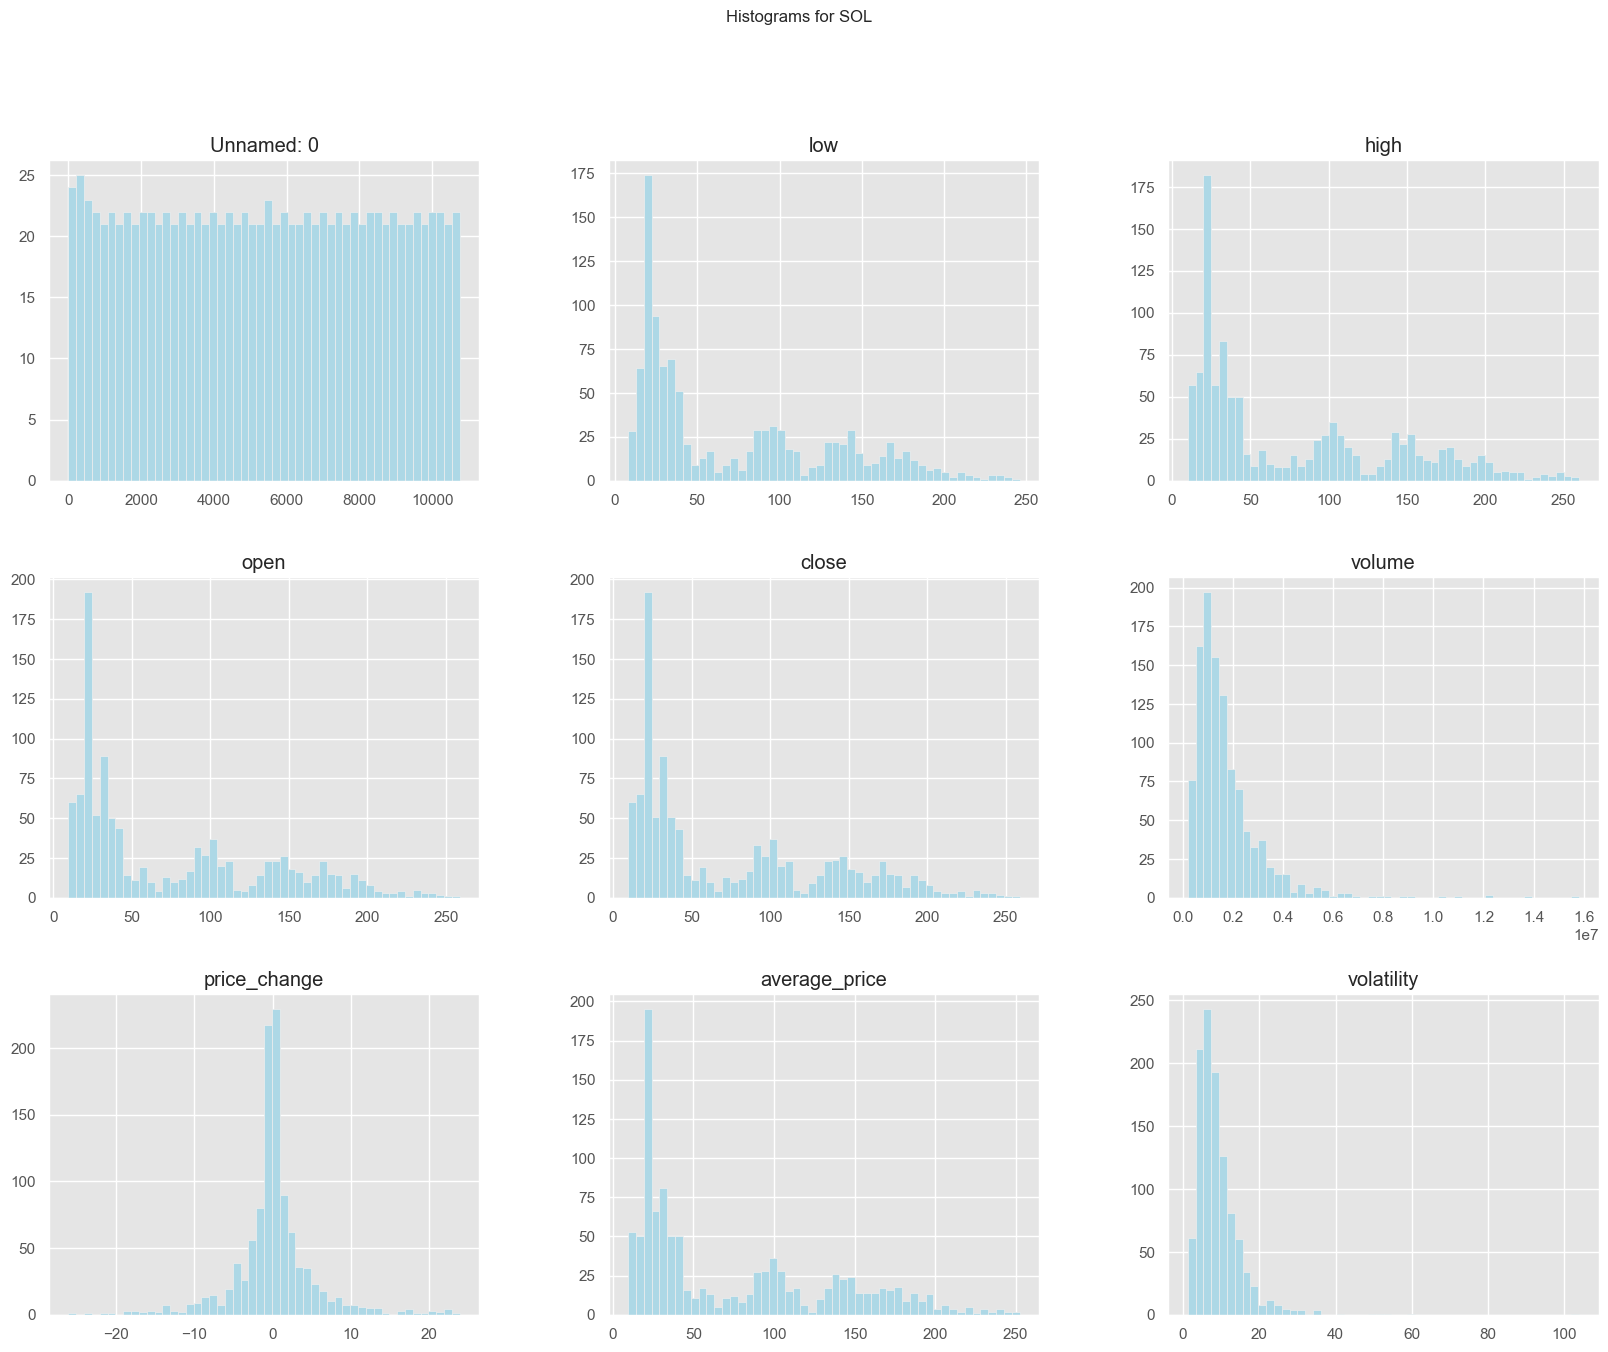

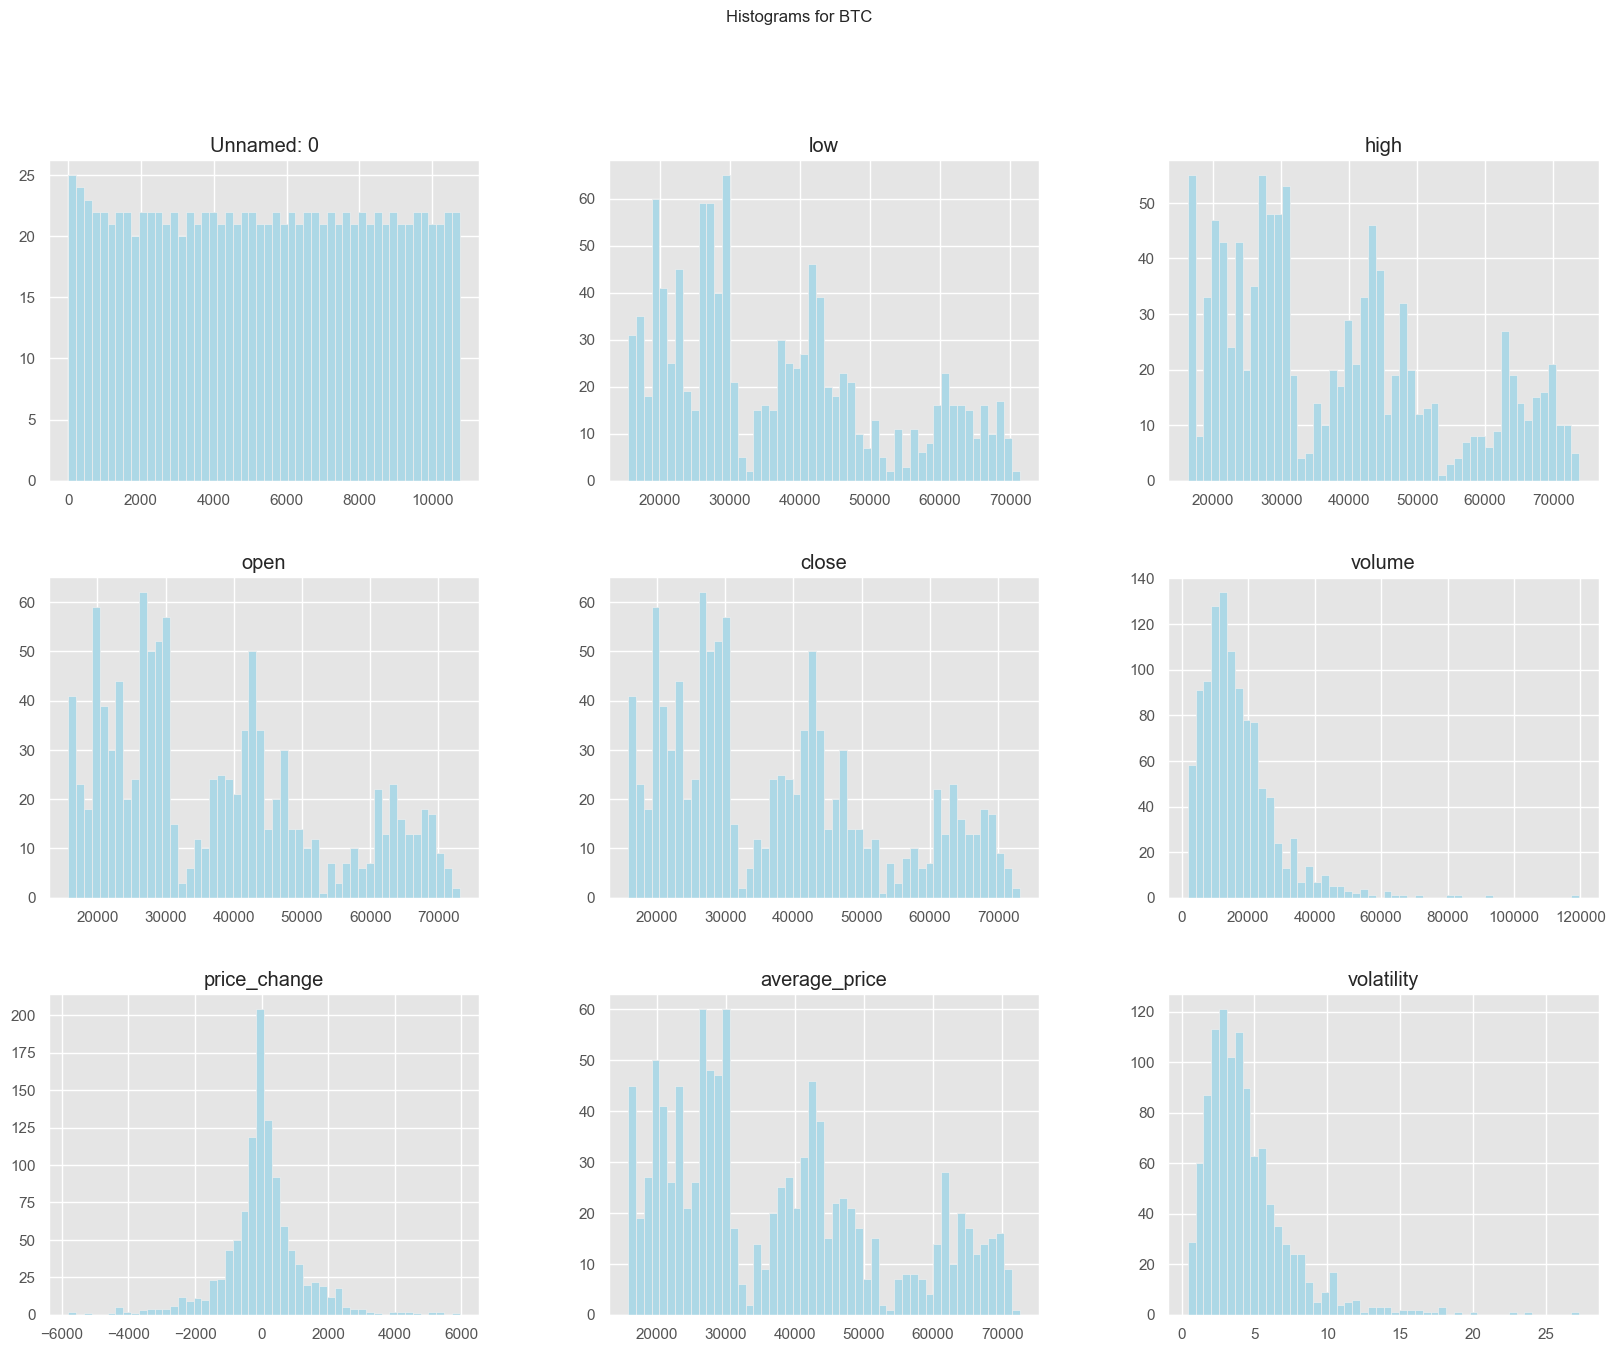

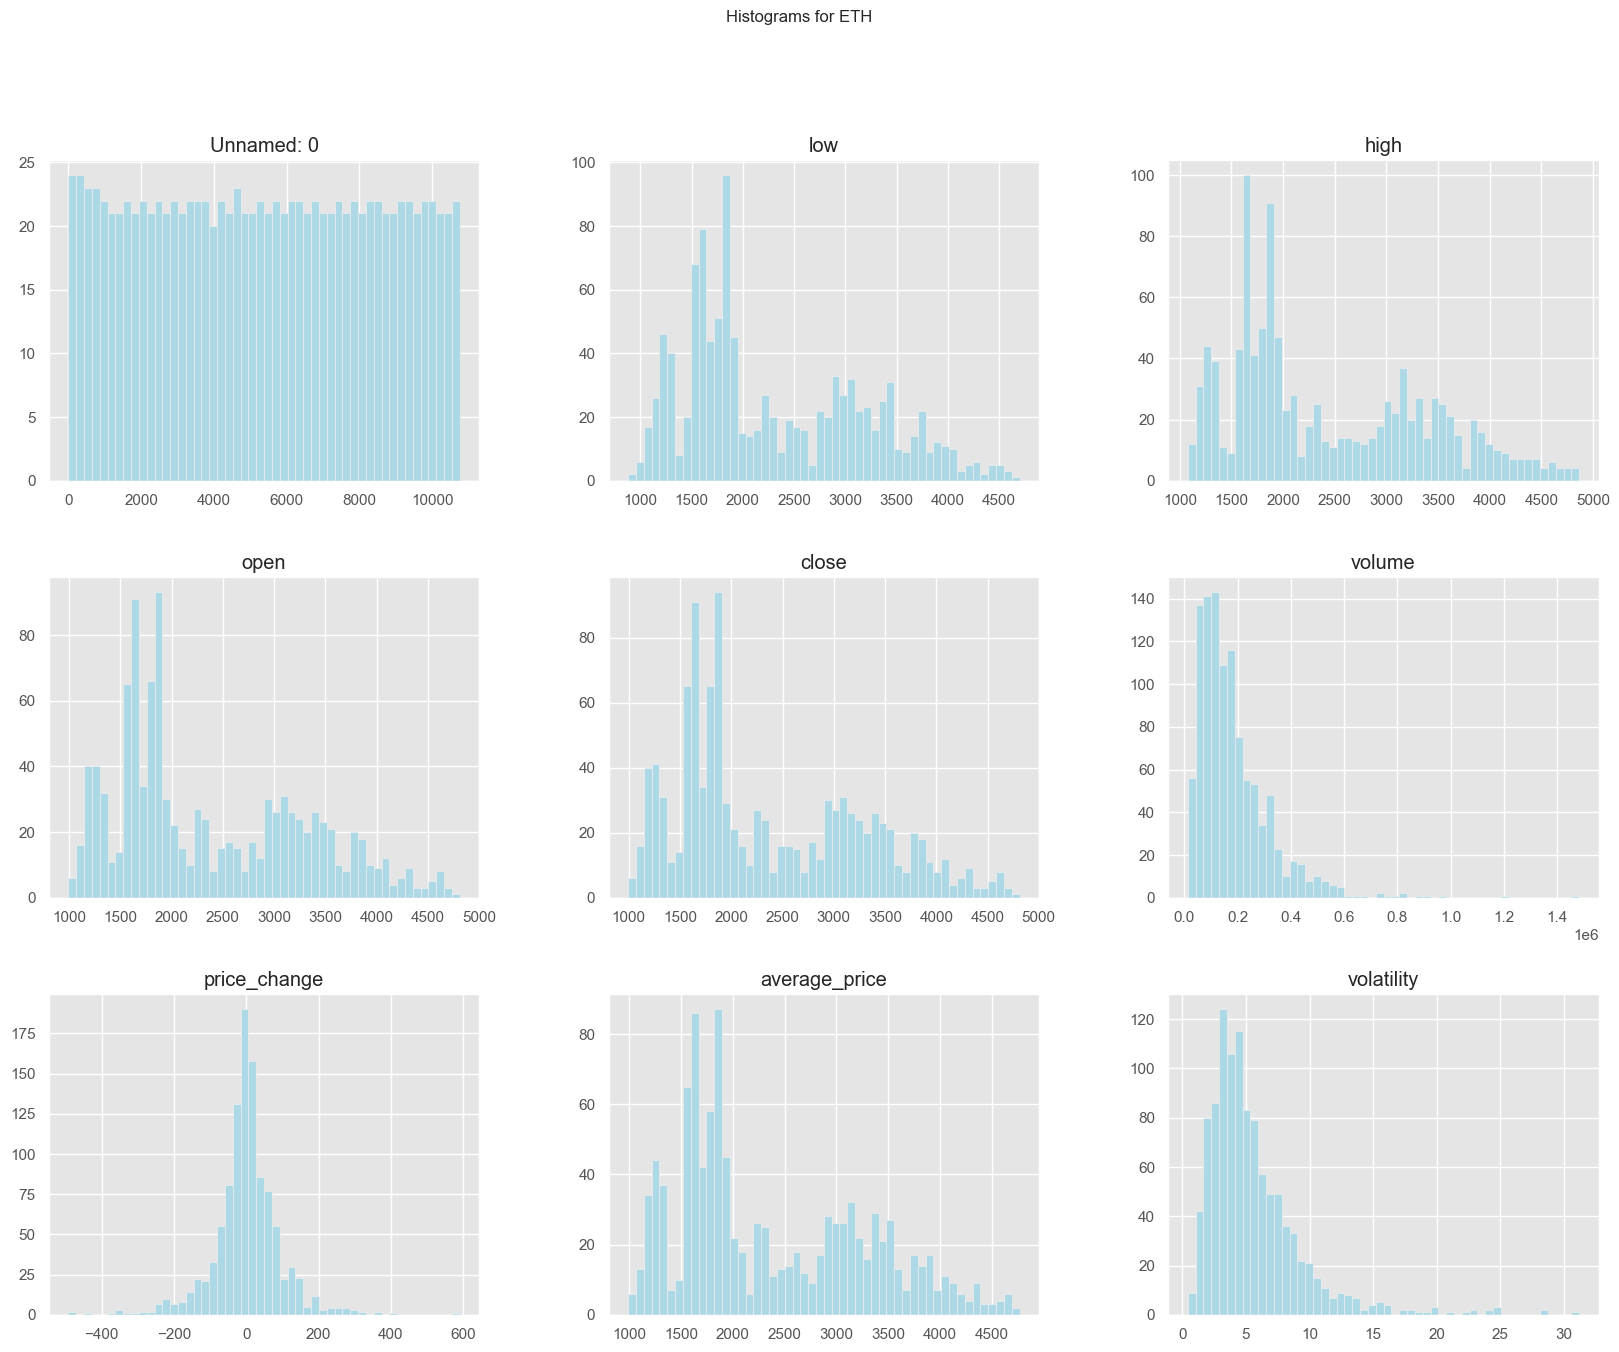

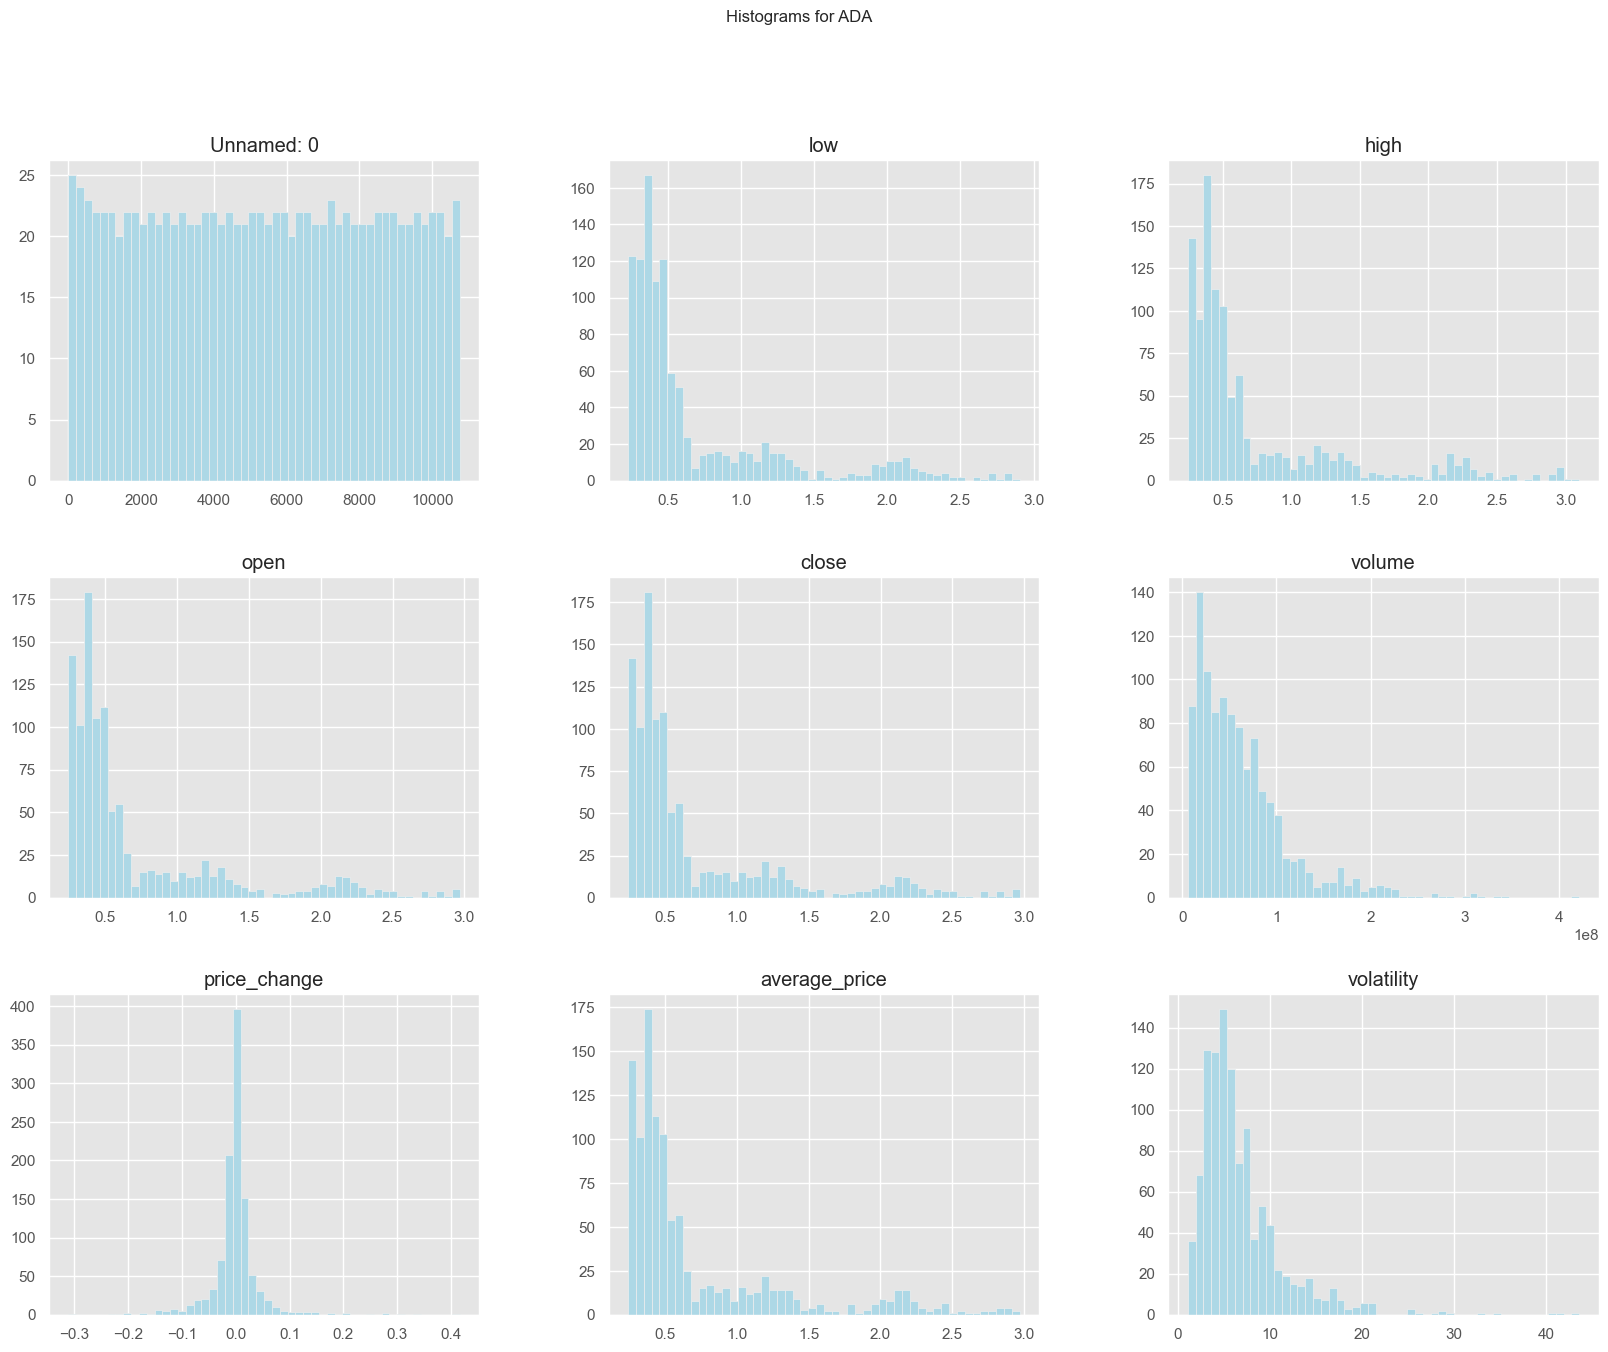

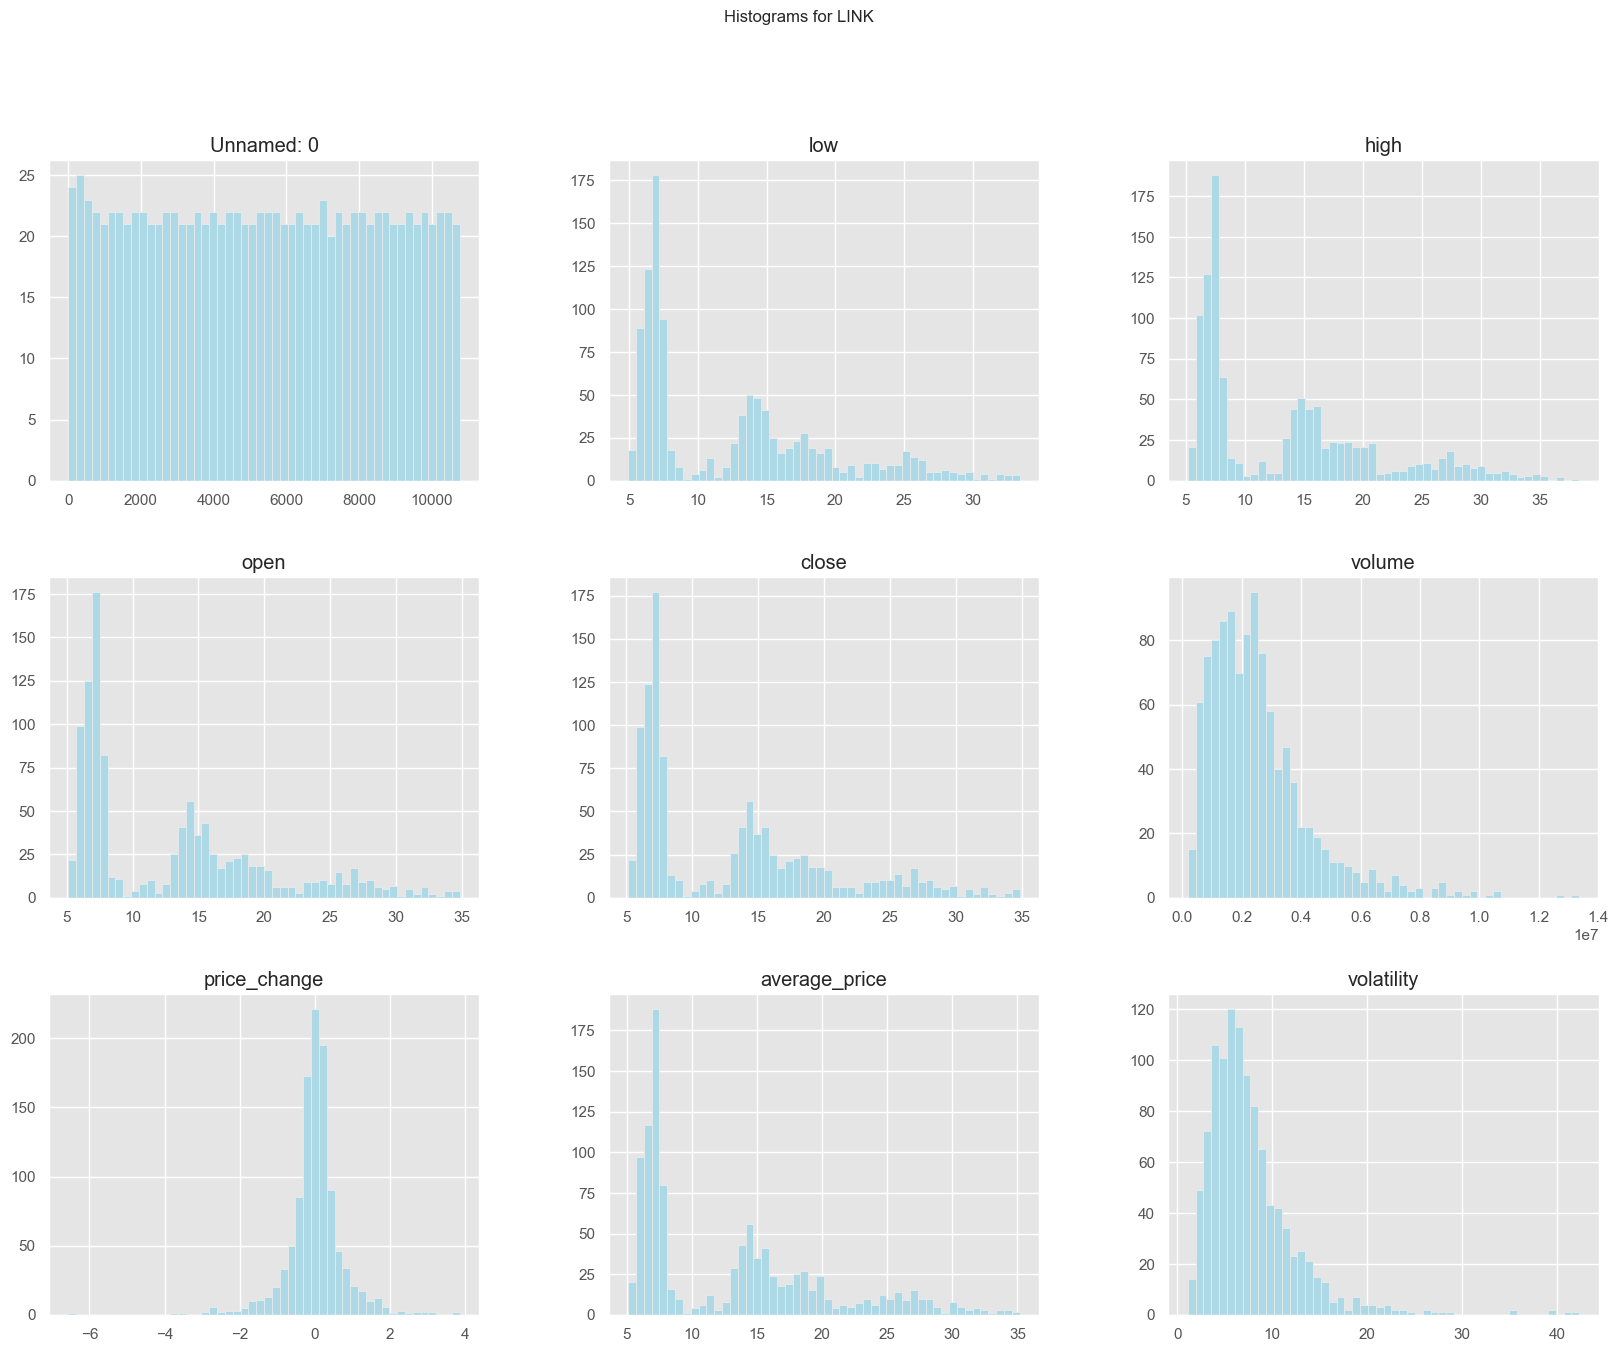

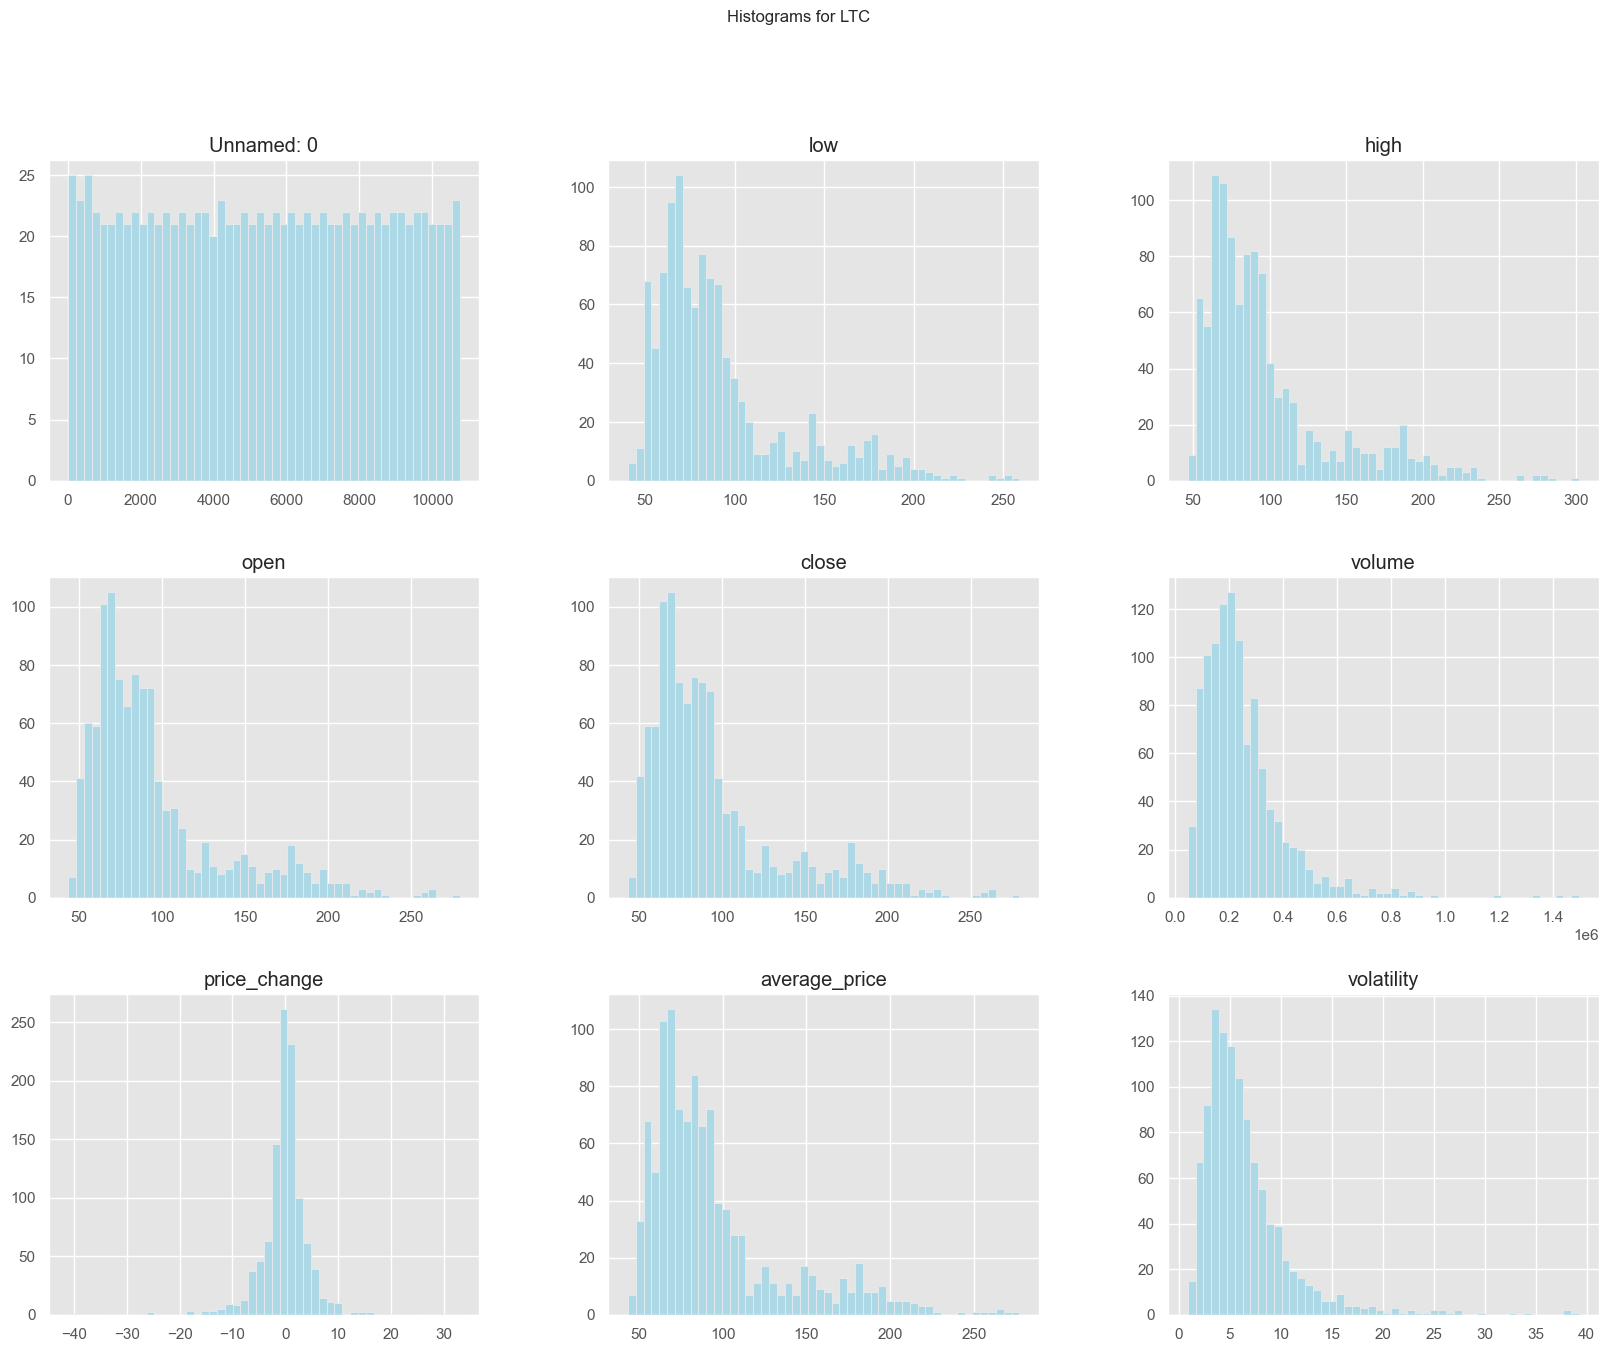

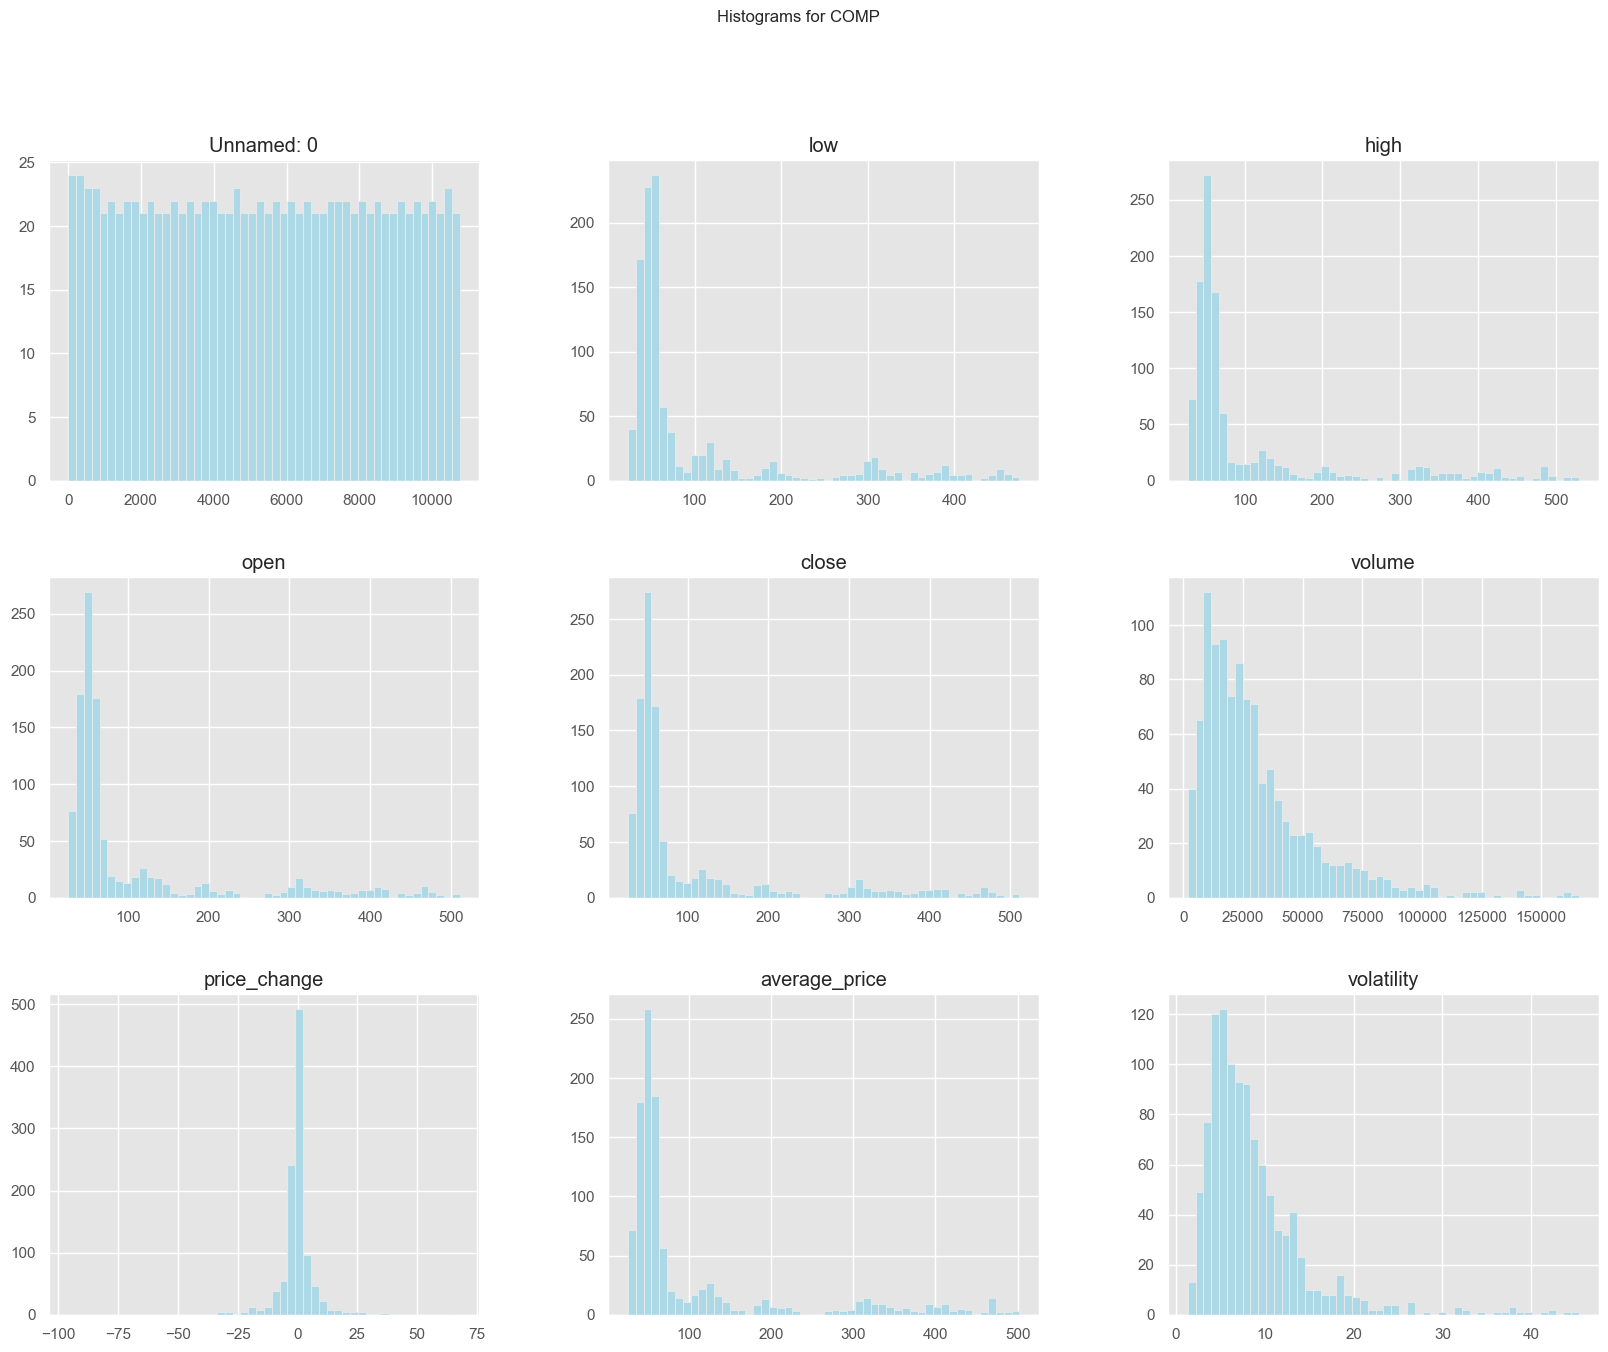

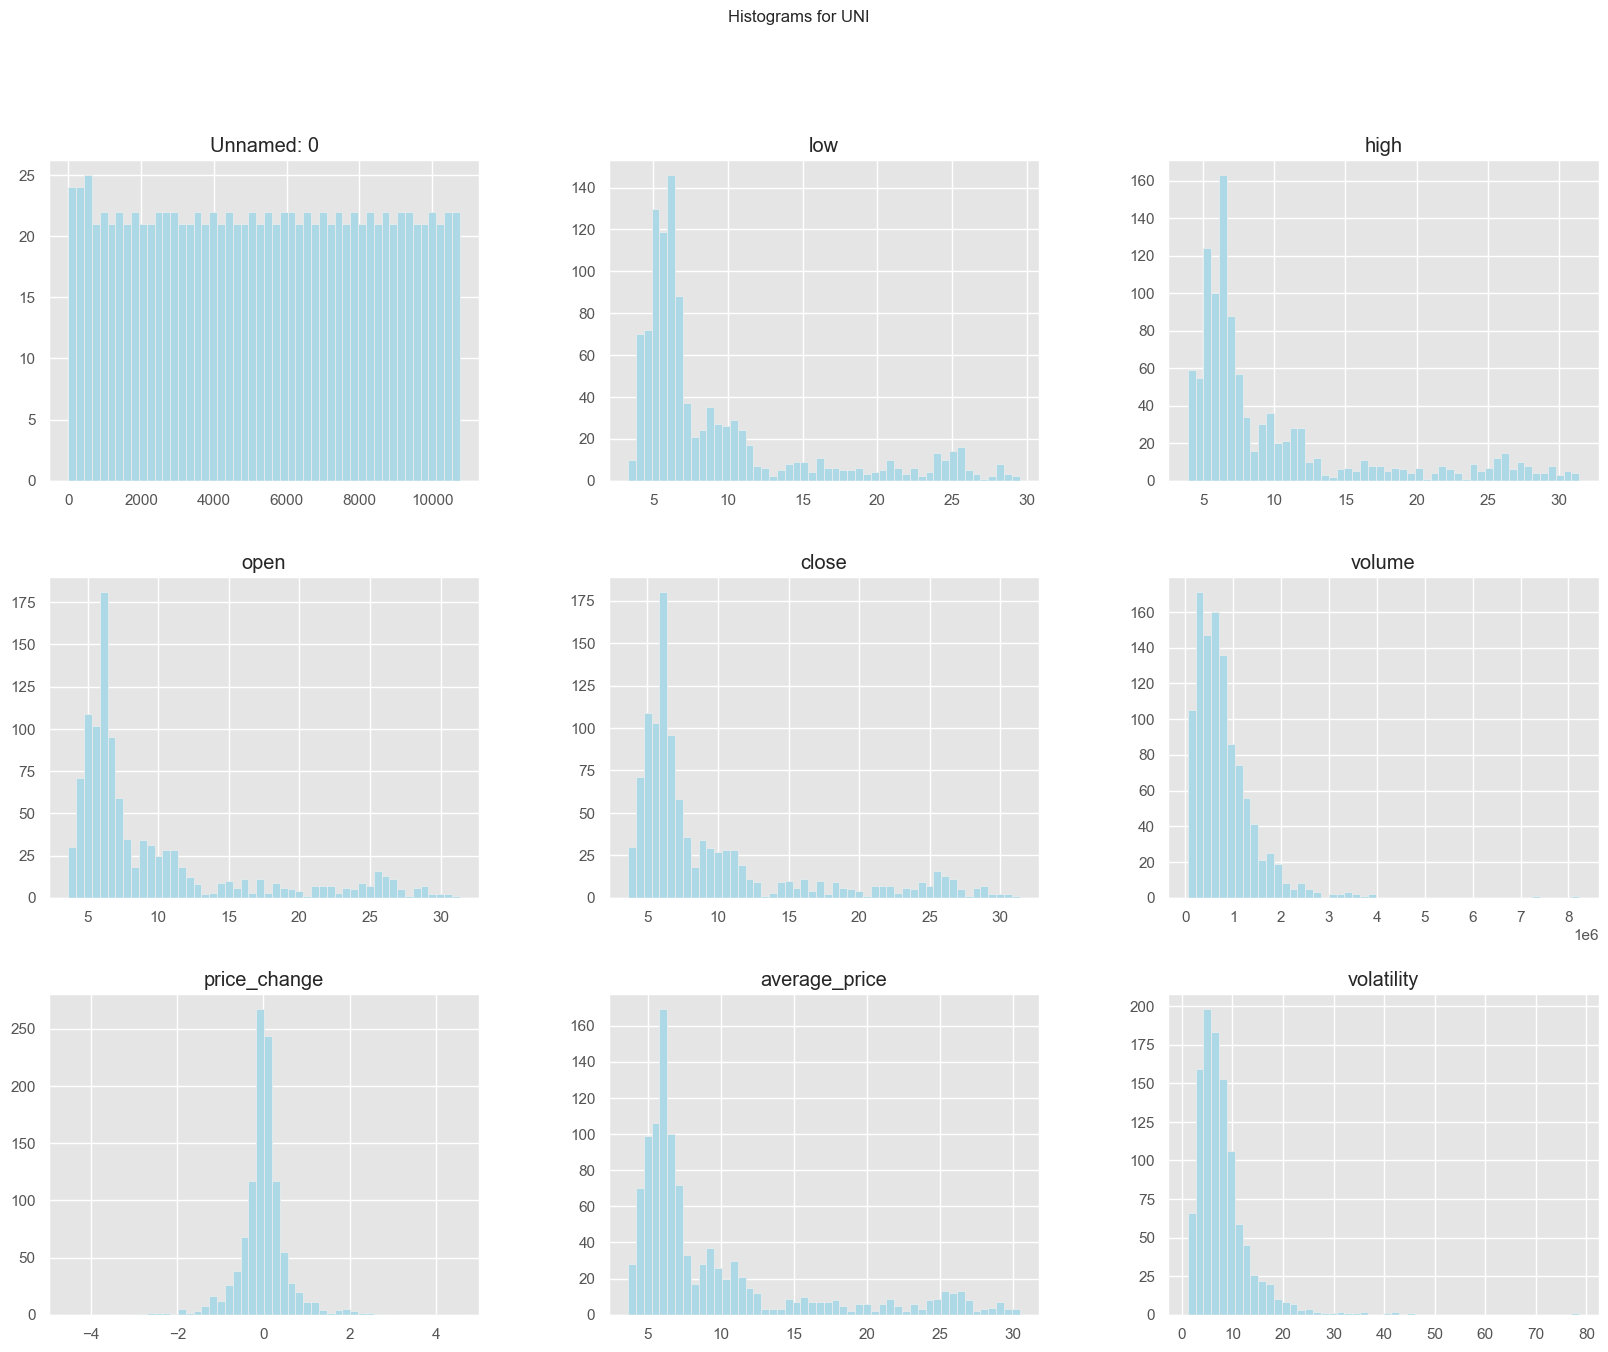

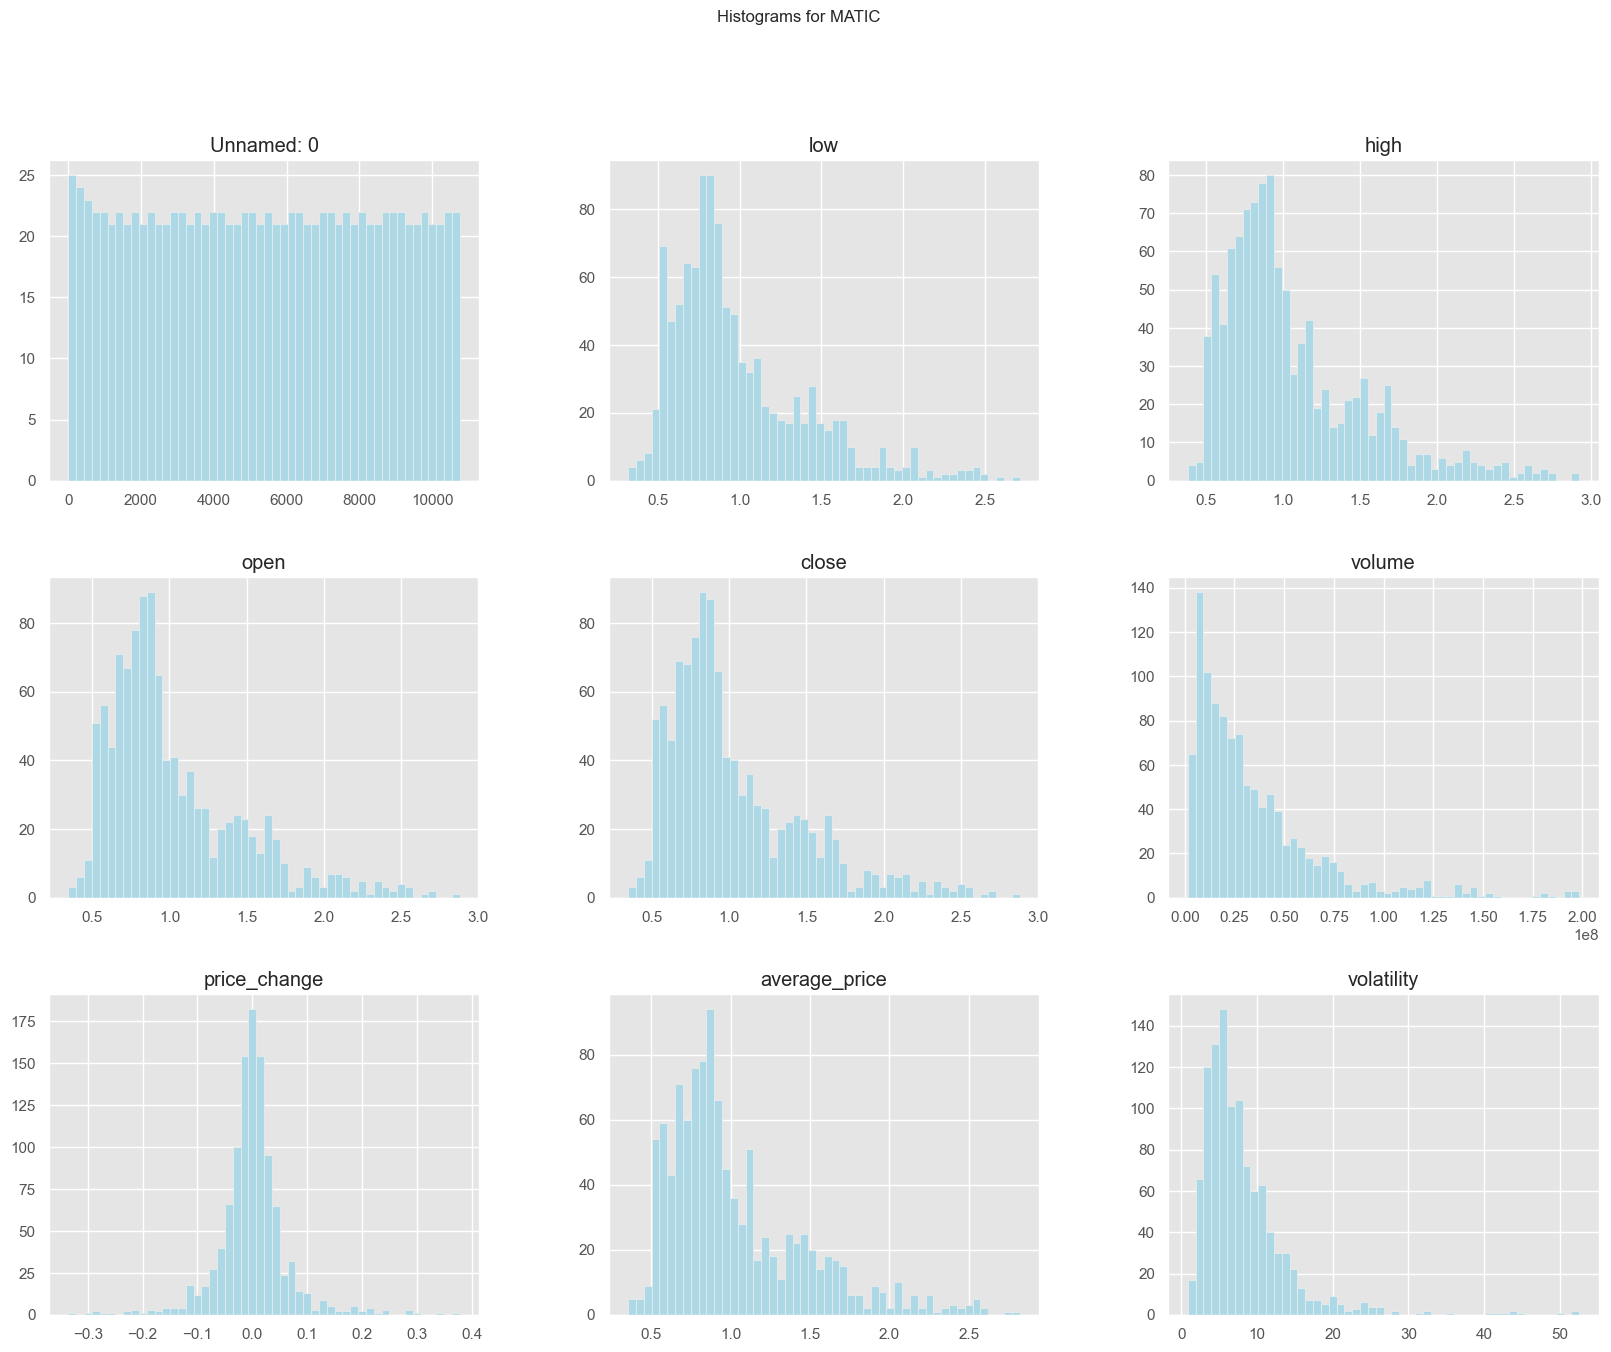

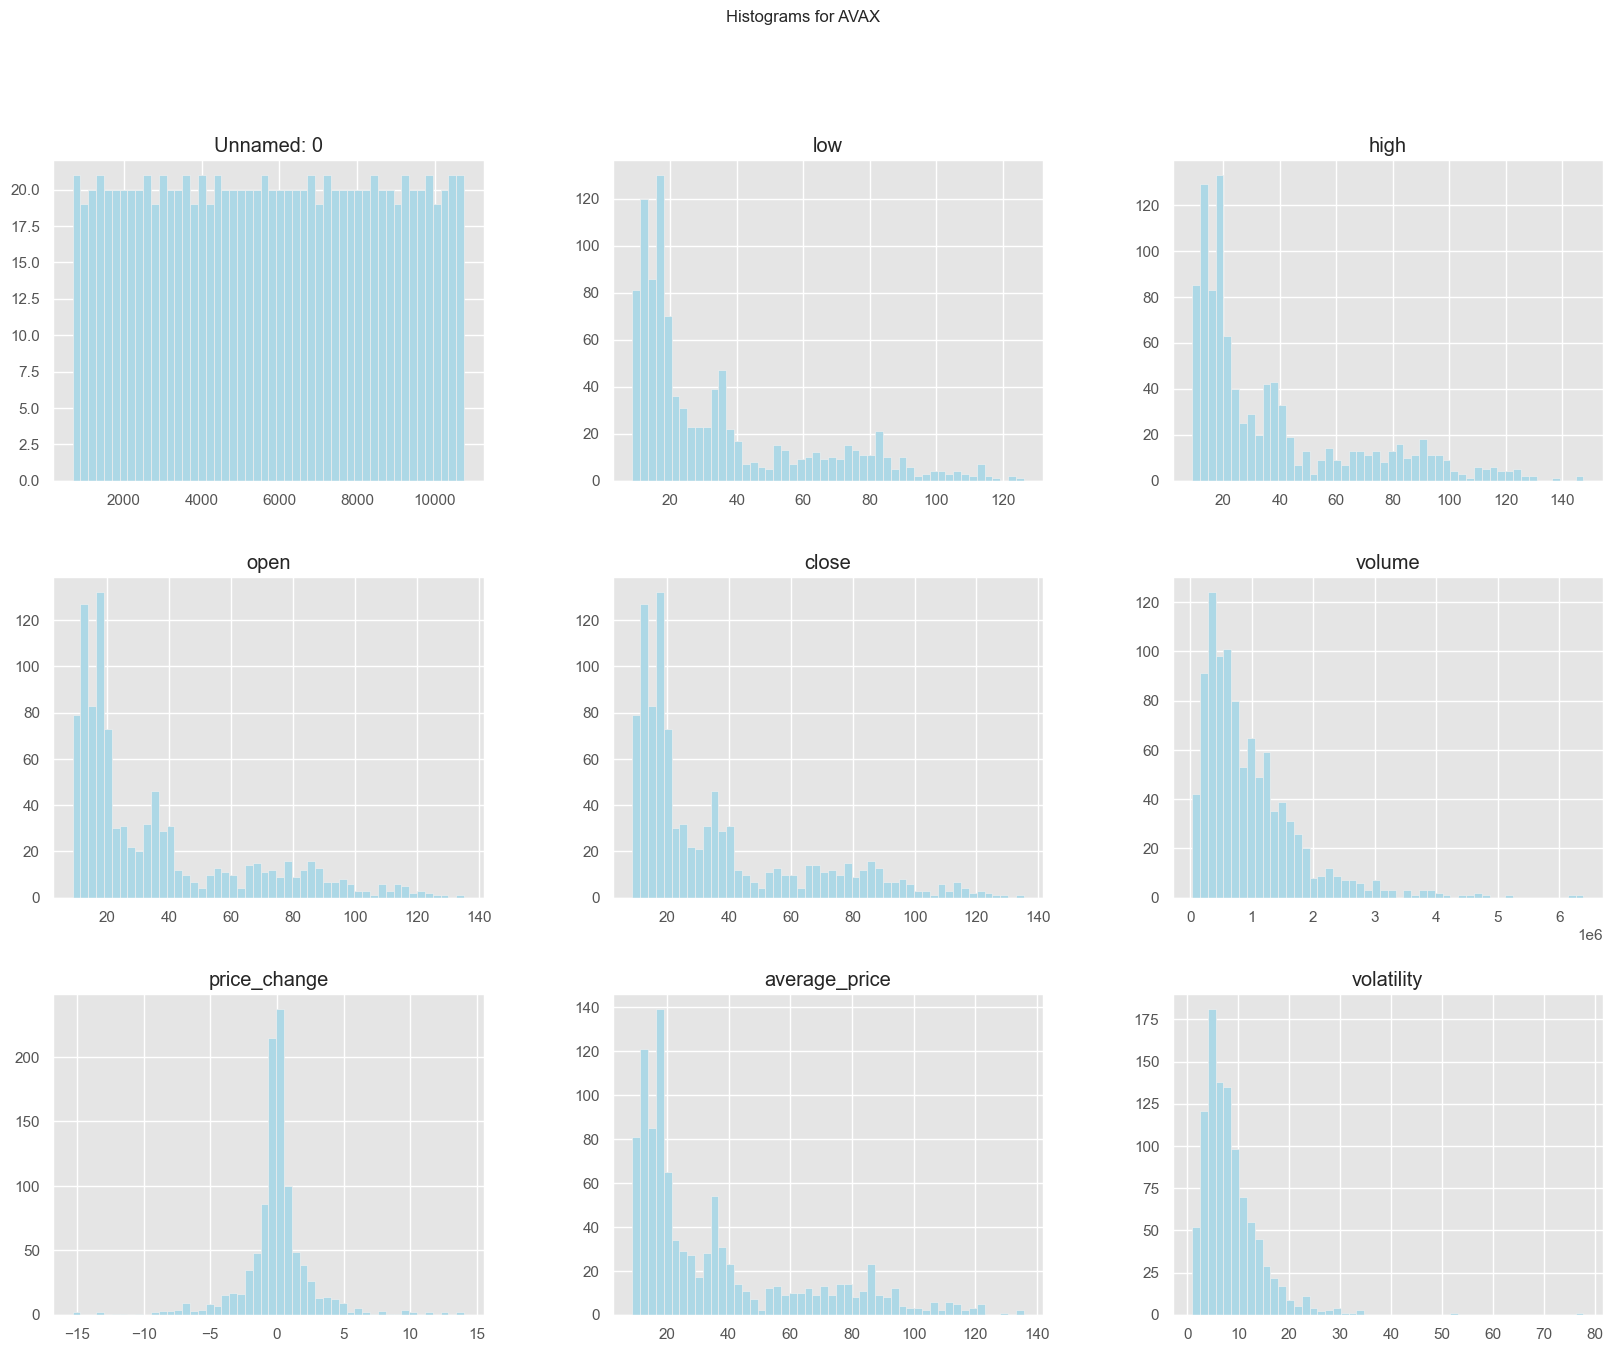

In [54]:
# Histograms
def plotHistograms(name, cryptoData):
    cryptoData.hist(bins=50, figsize=(20, 15), color="lightblue")
    plt.suptitle(f'Histograms for {name}')
    plt.show()

for name, df in cryptos_info.items():
    plotHistograms(name, df)

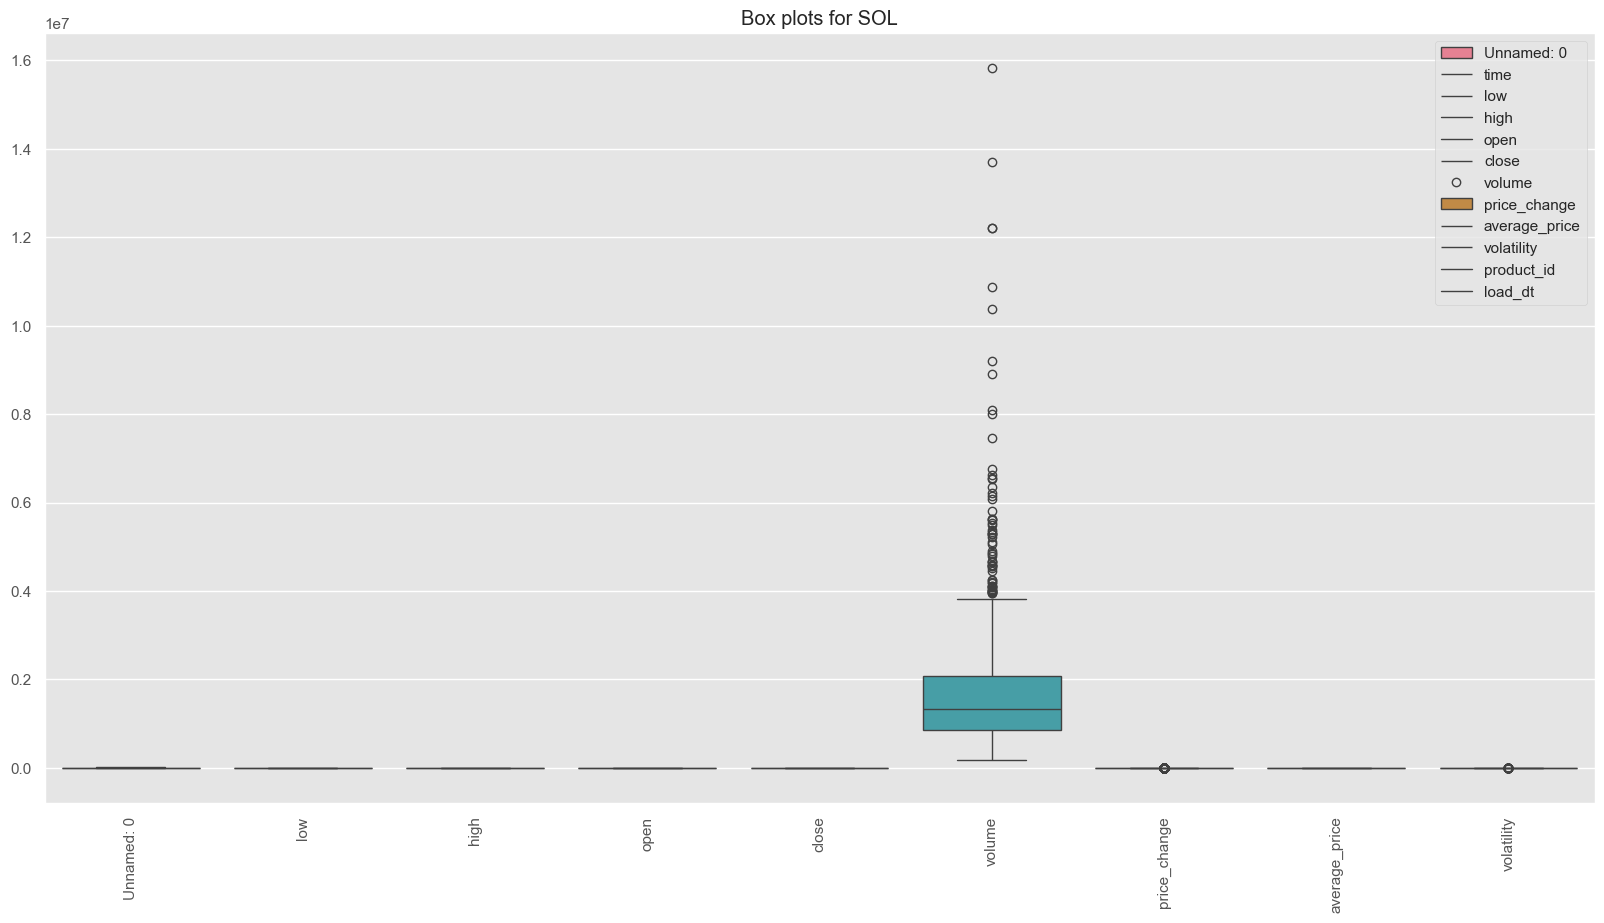

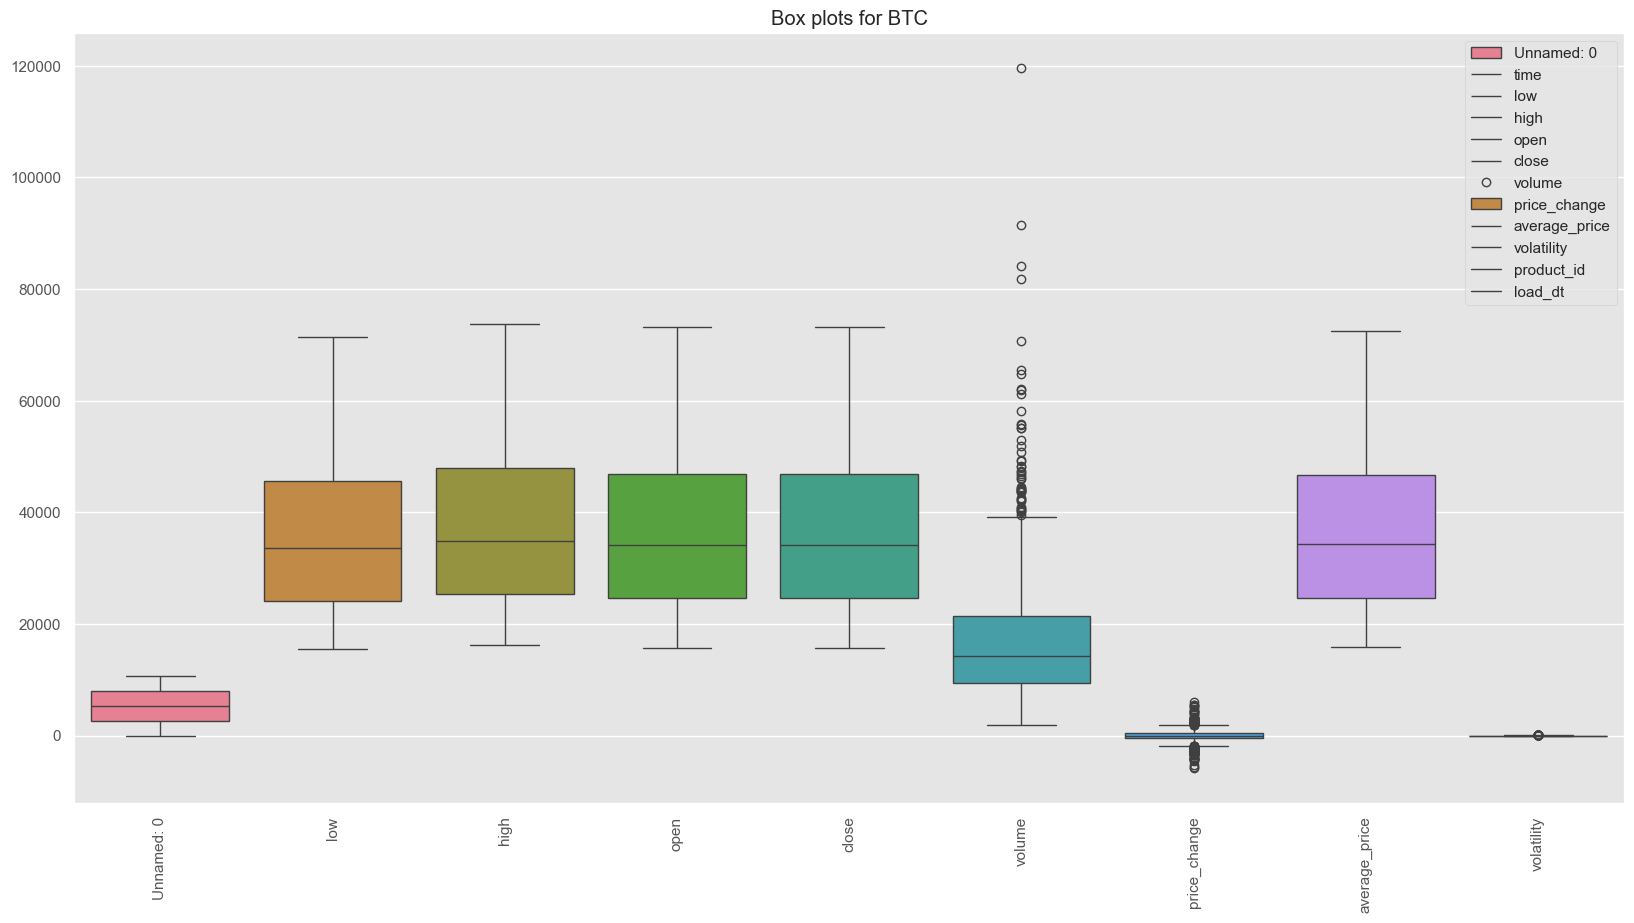

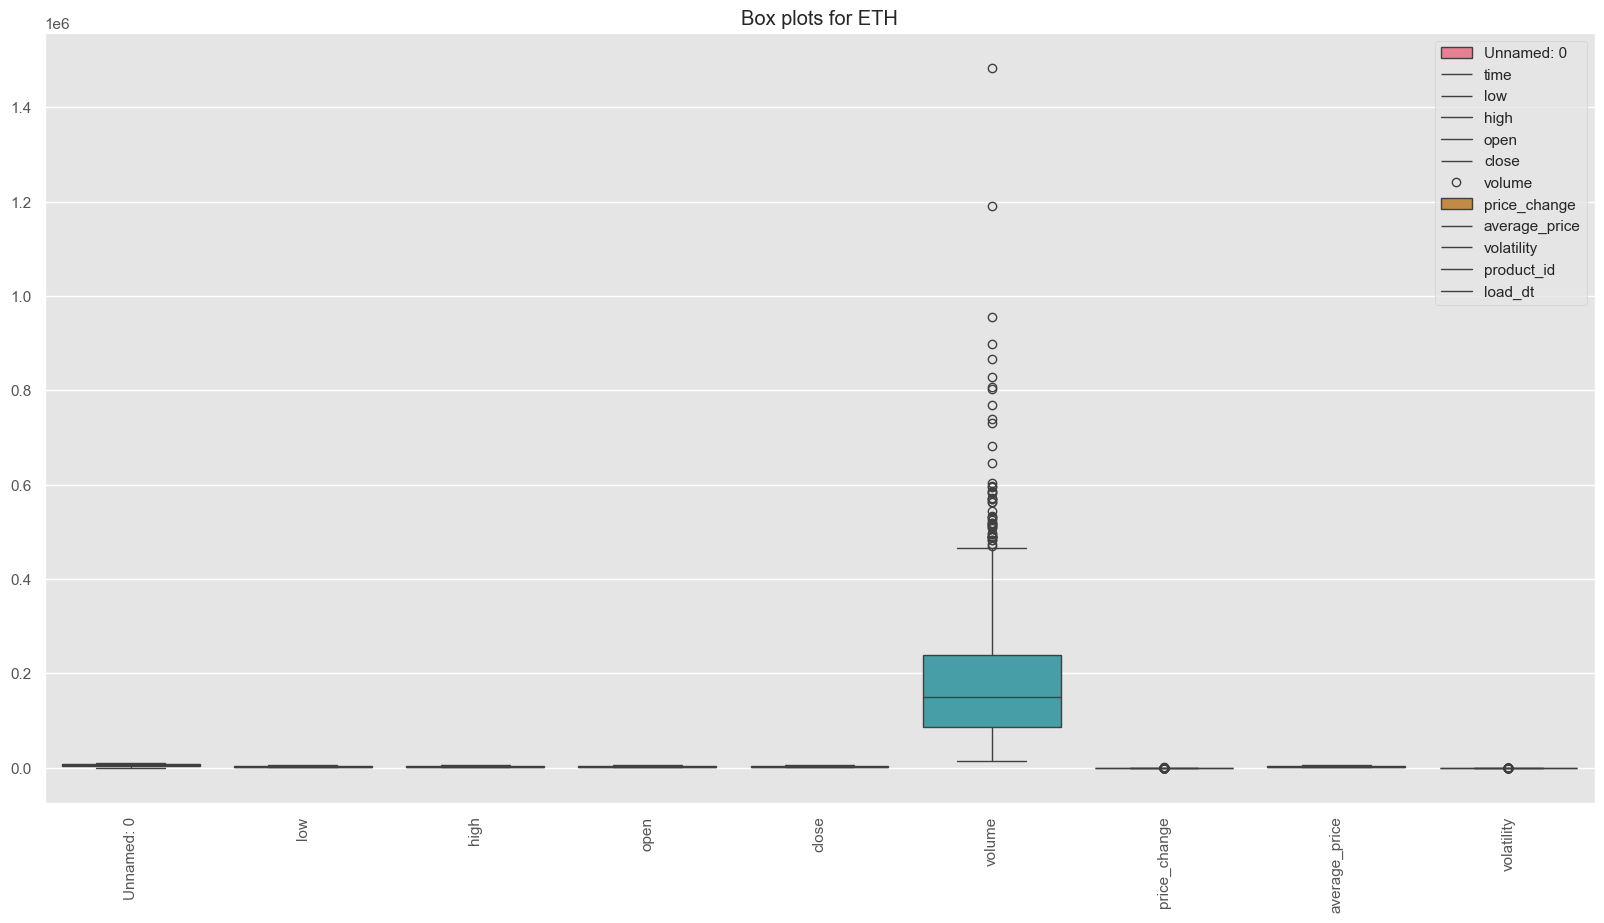

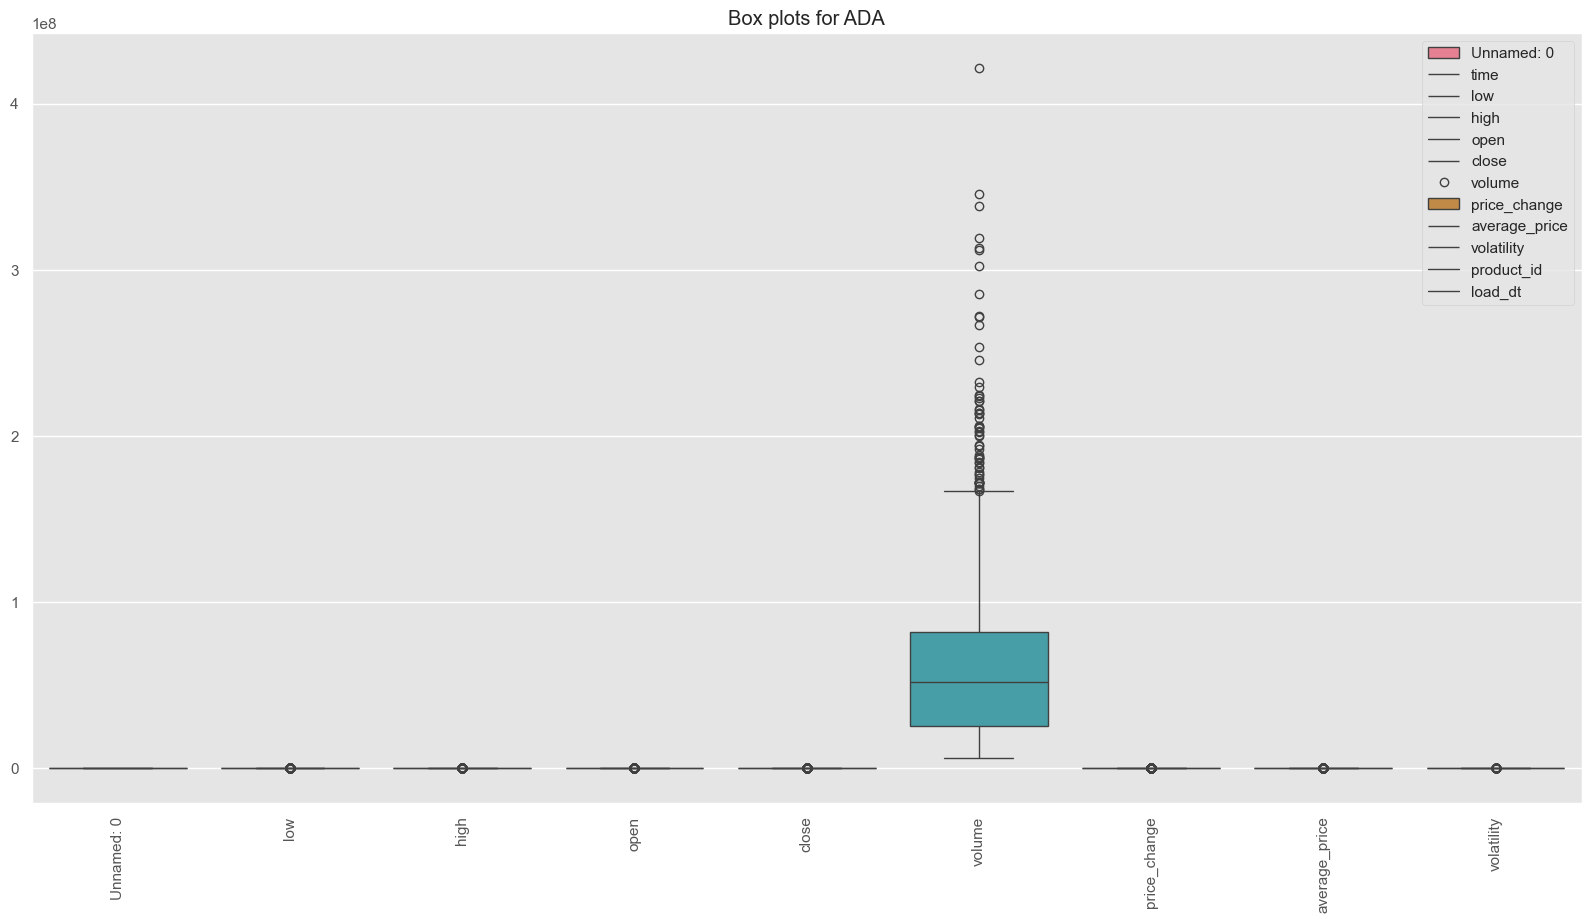

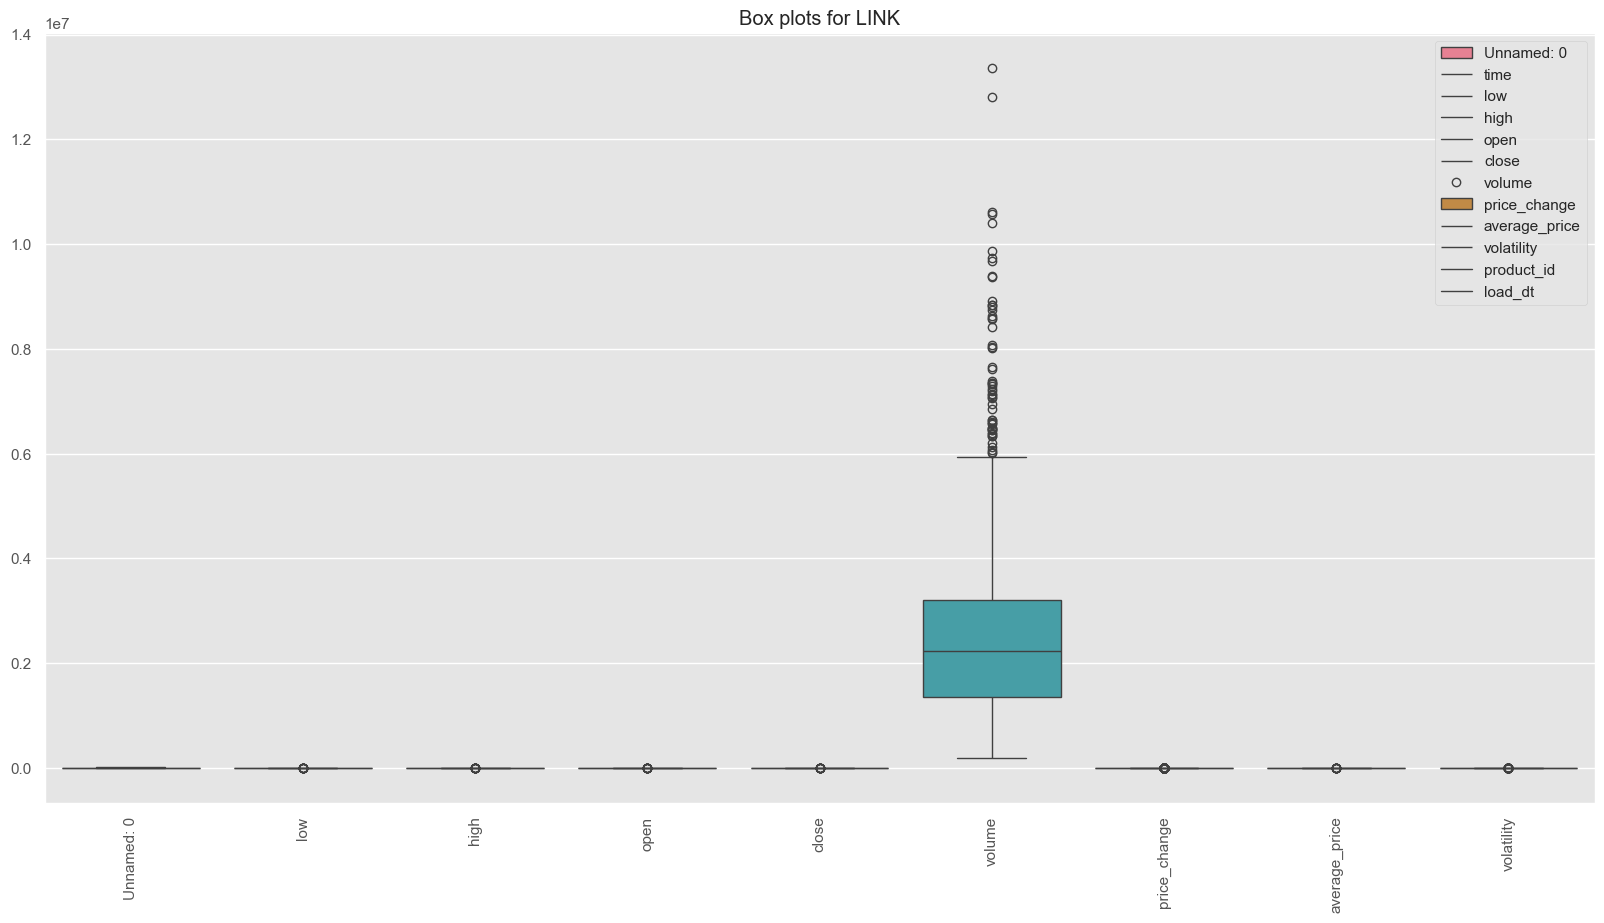

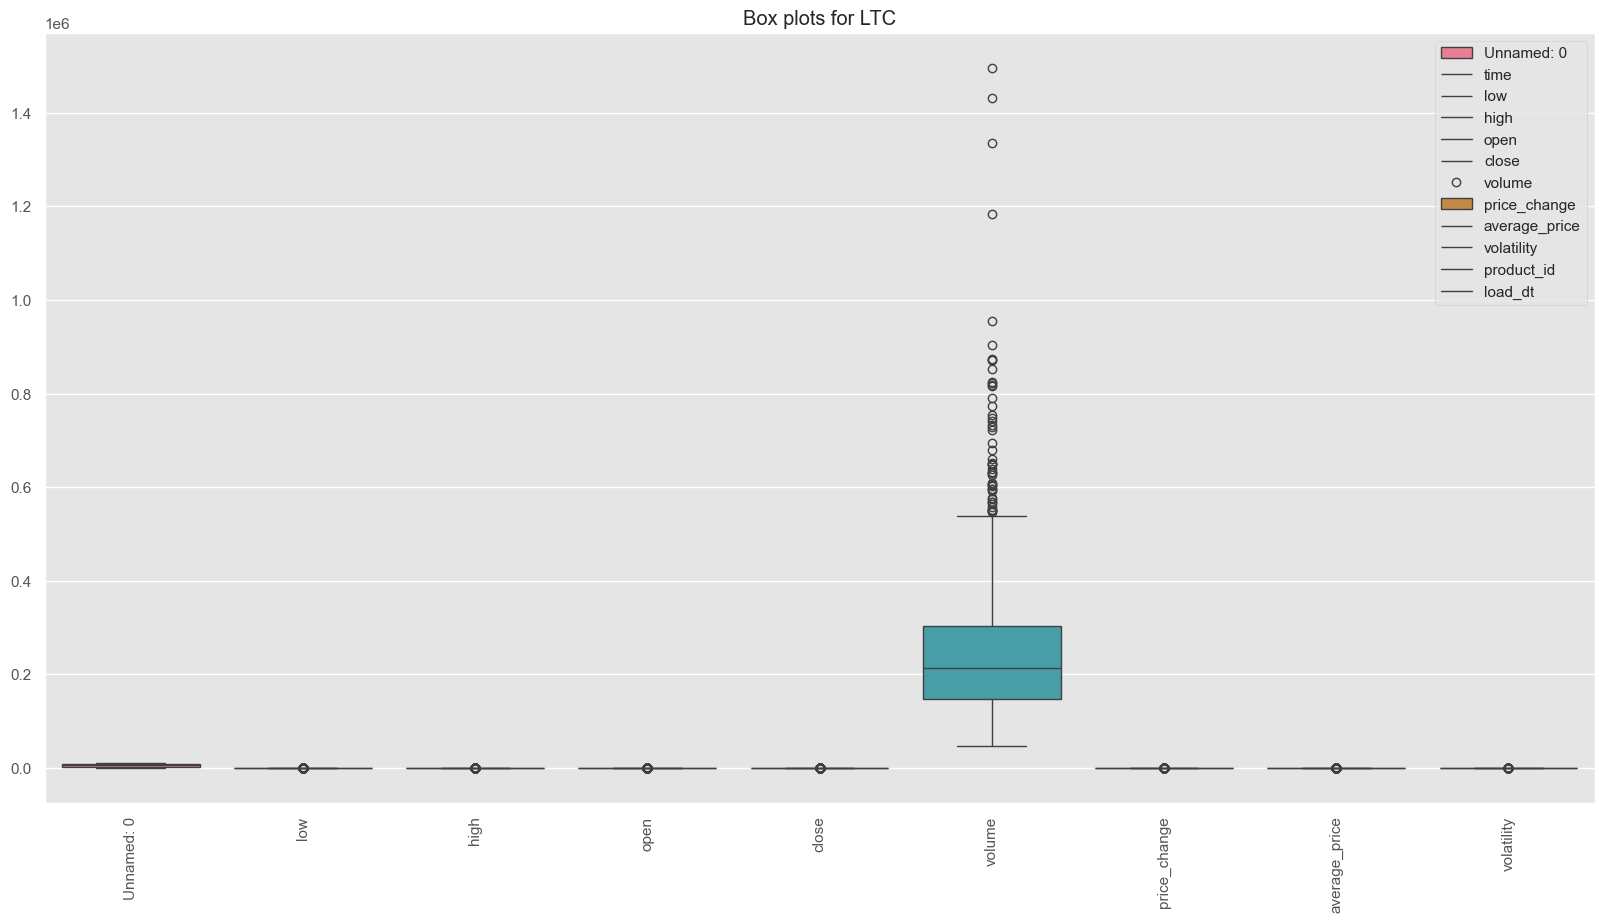

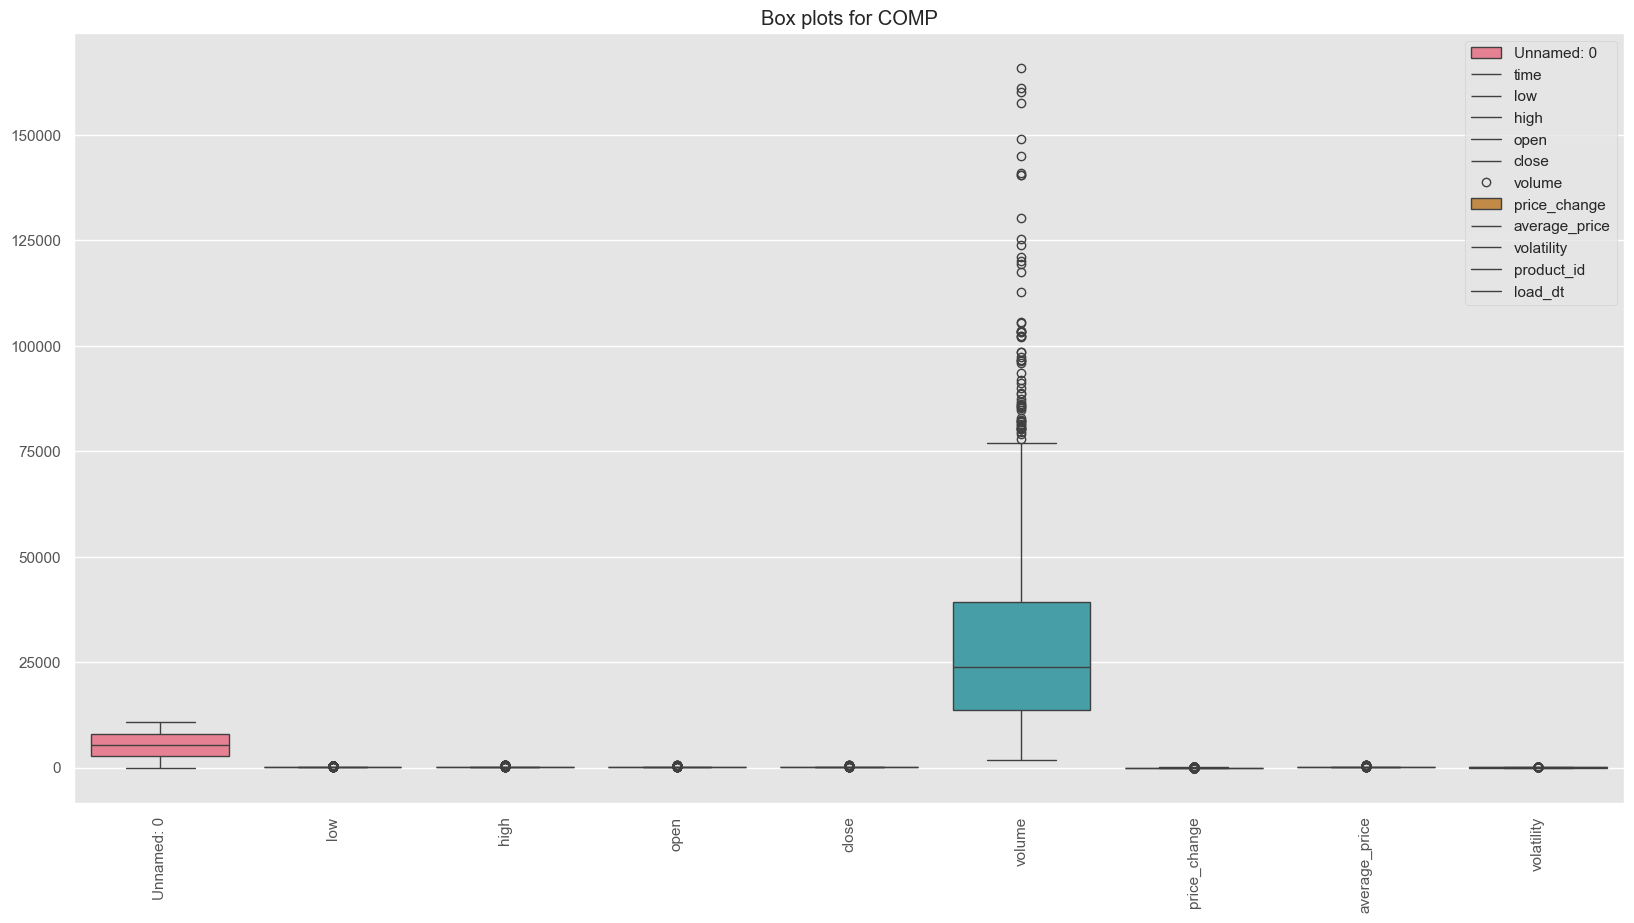

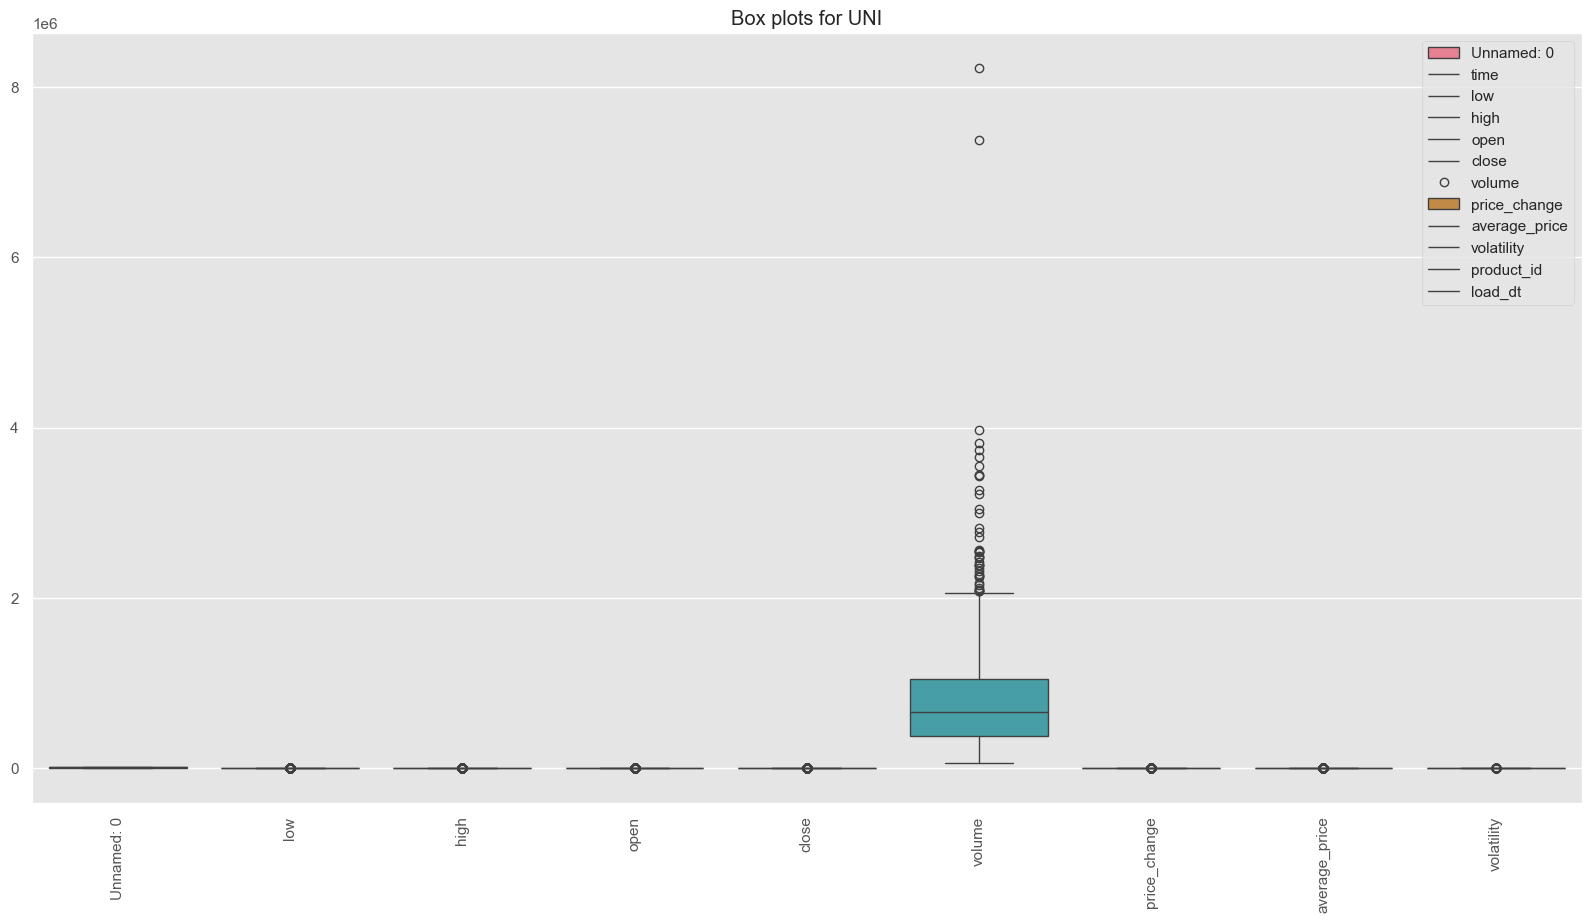

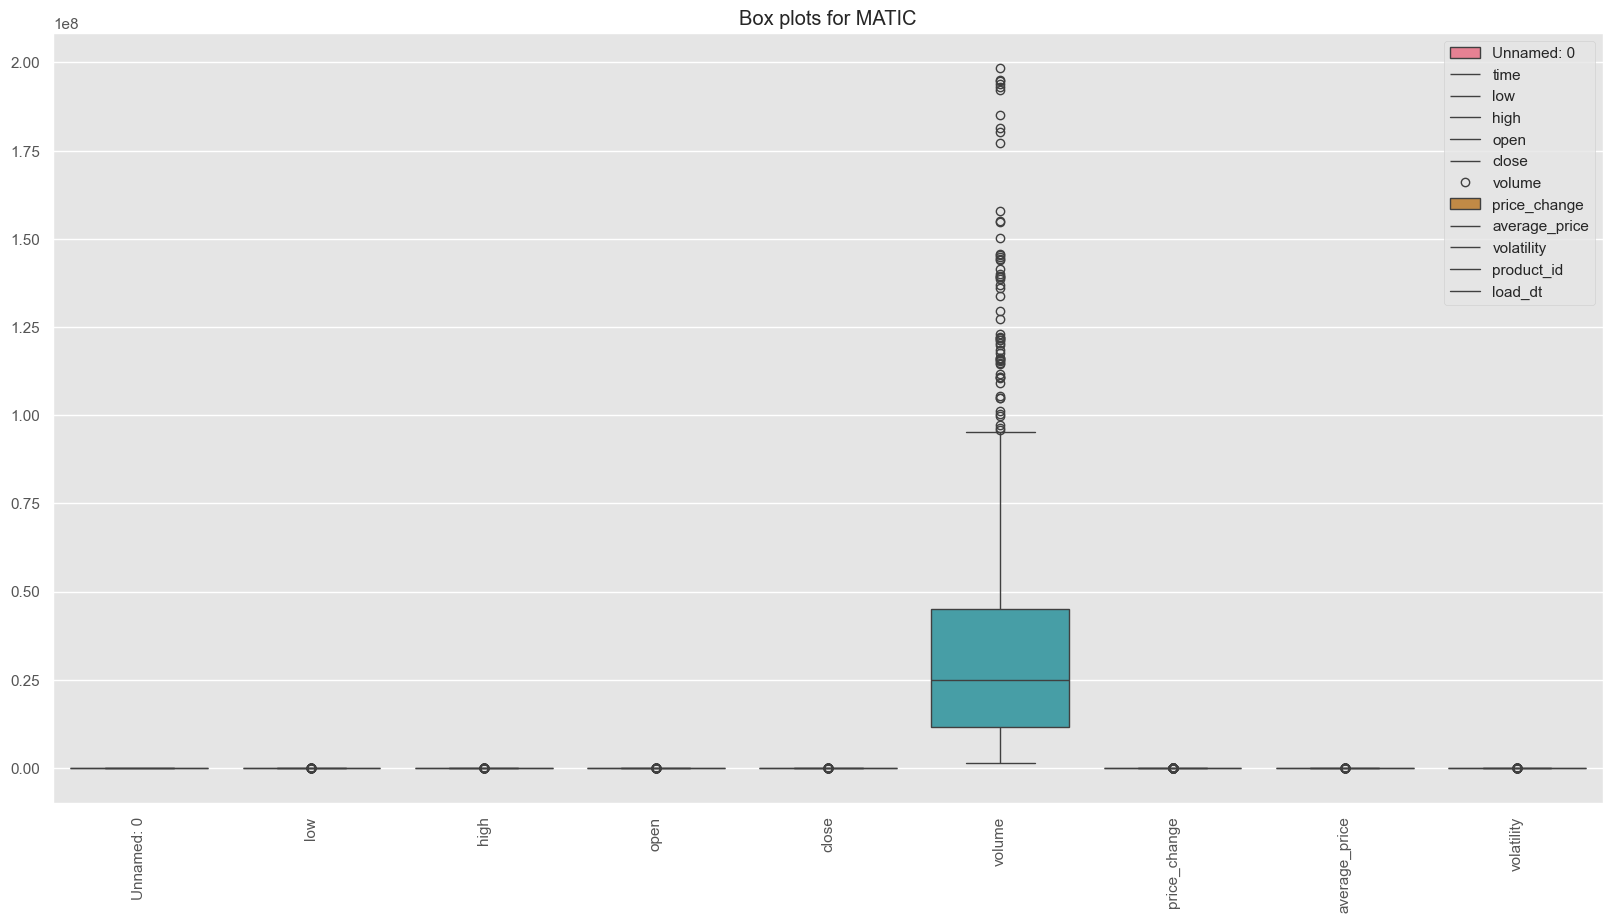

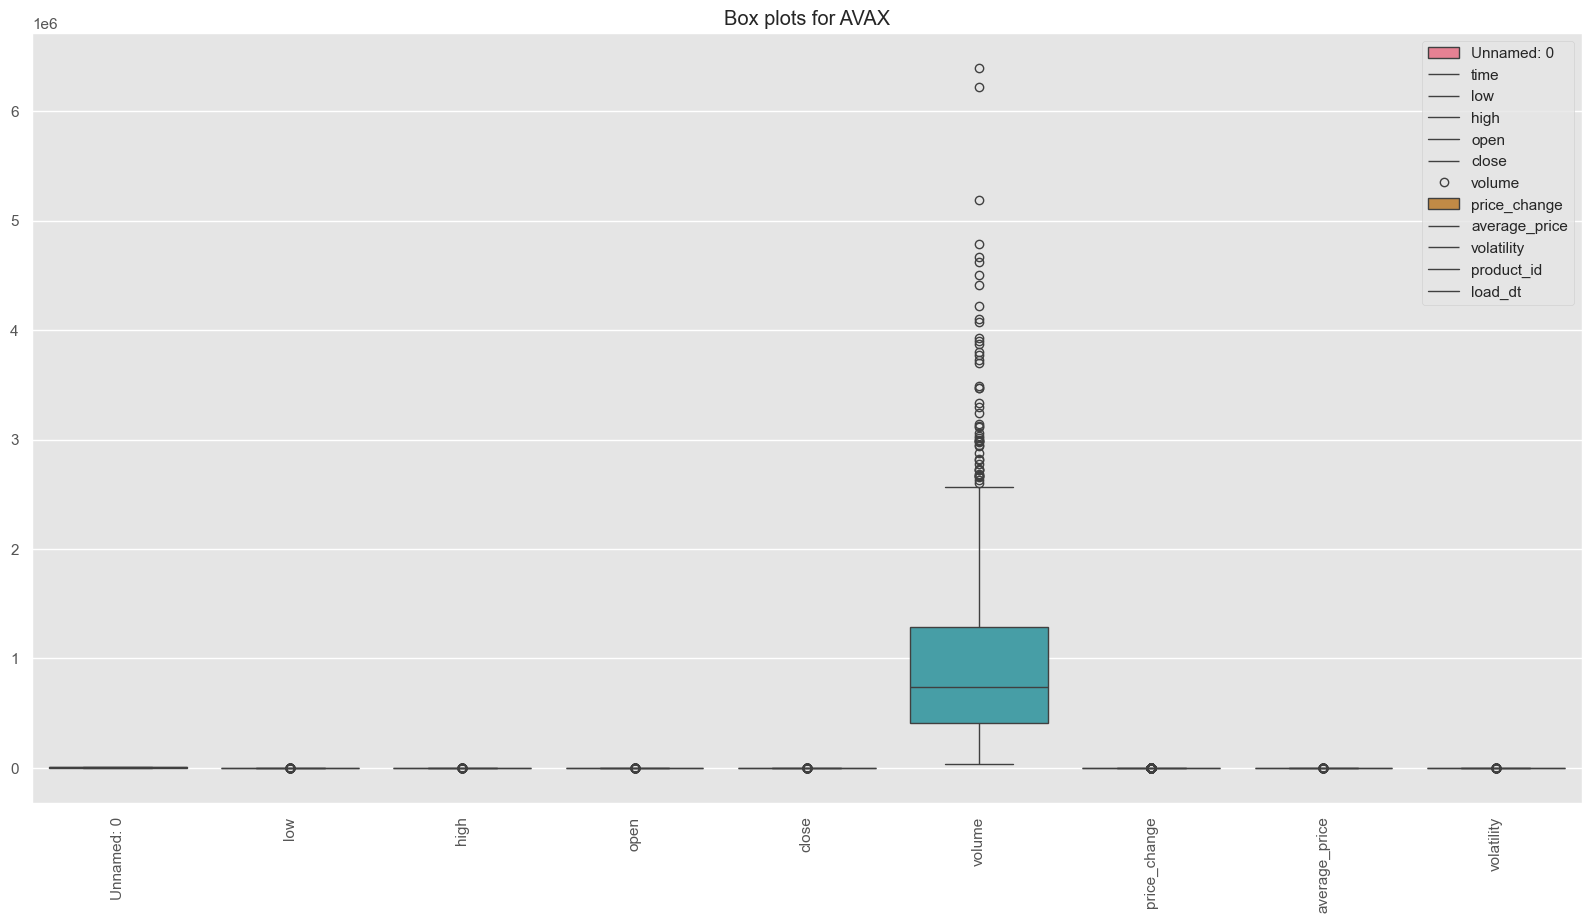

In [55]:
# Box plots
def plotBoxPlots(name, cryptoData):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=cryptoData)
    plt.title(f'Box plots for {name}')
    plt.xticks(rotation=90)
    plt.legend(labels=cryptoData.columns)
    plt.show()
    
for name, df in cryptos_info.items():
    plotBoxPlots(name, df)

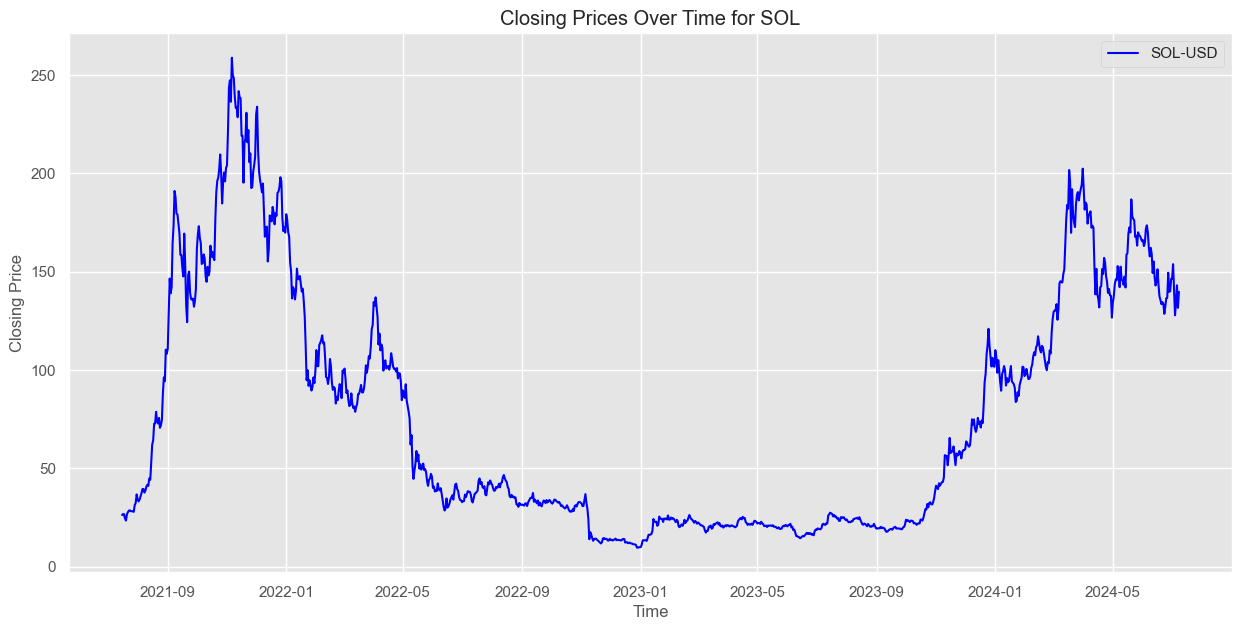

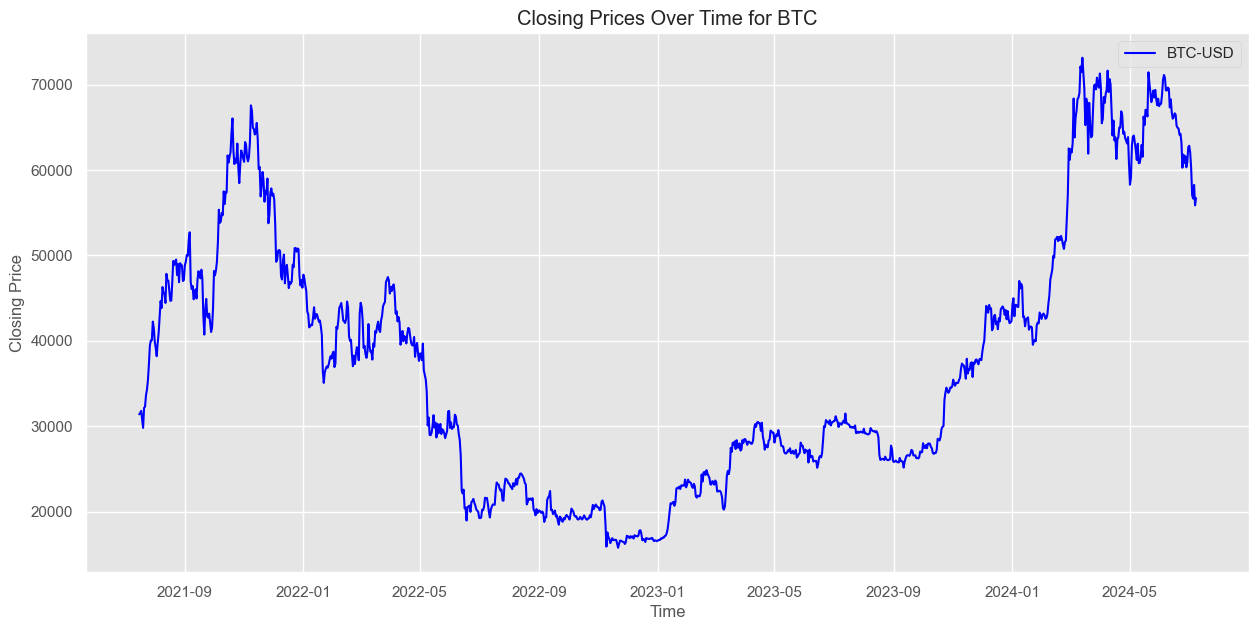

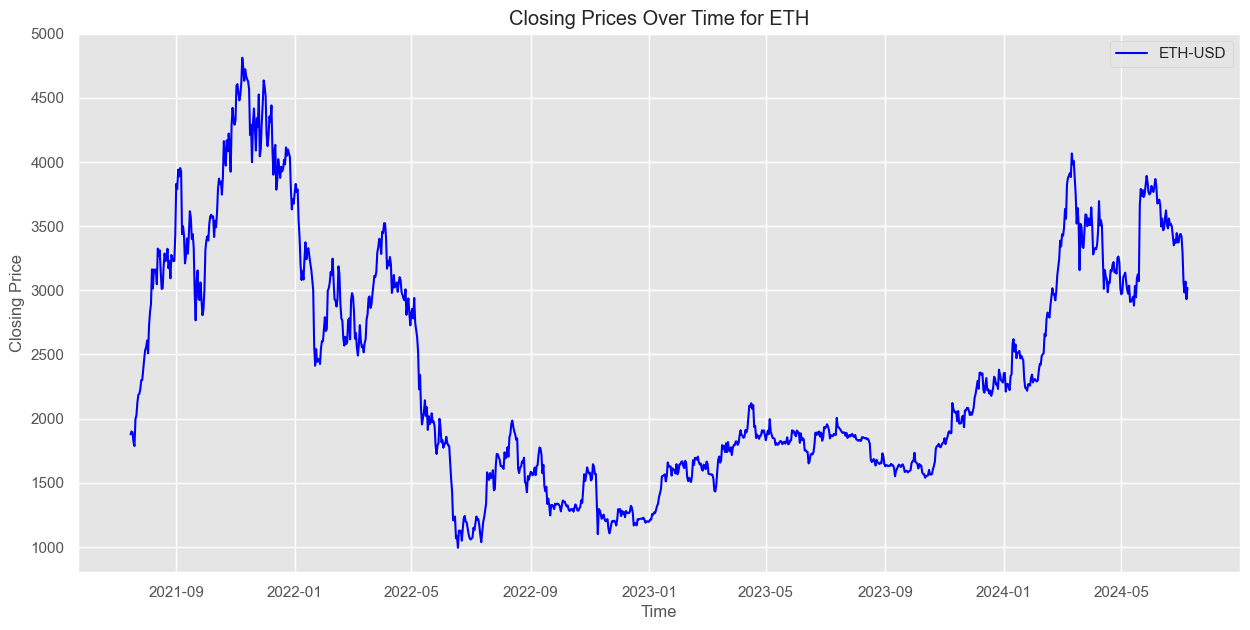

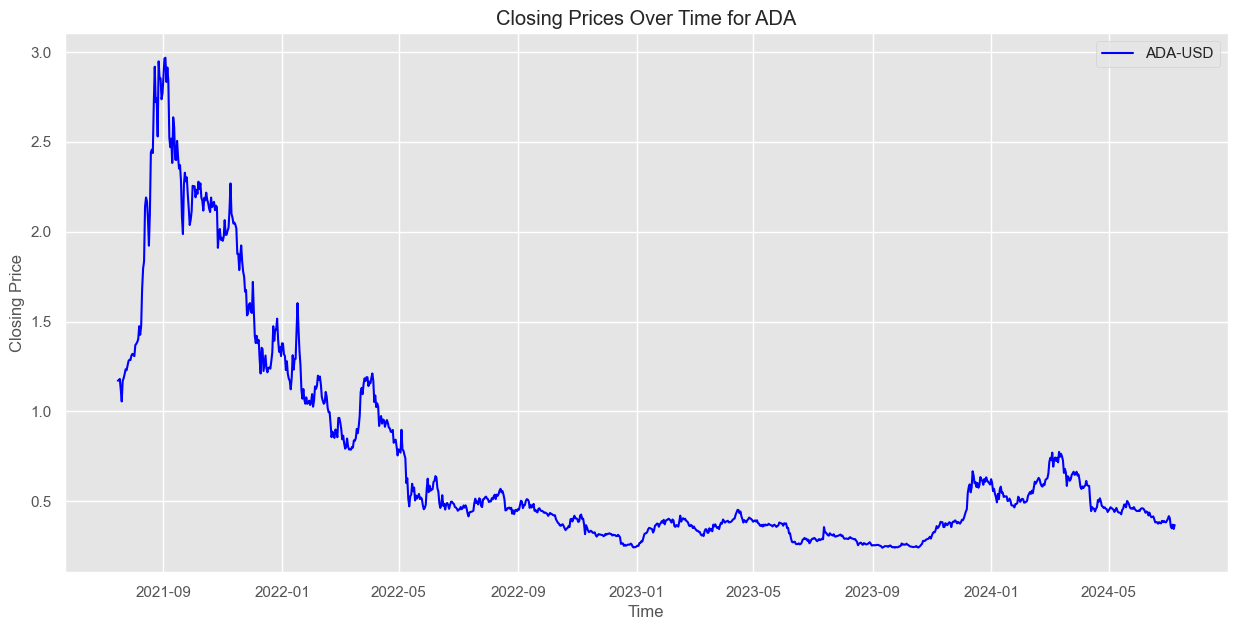

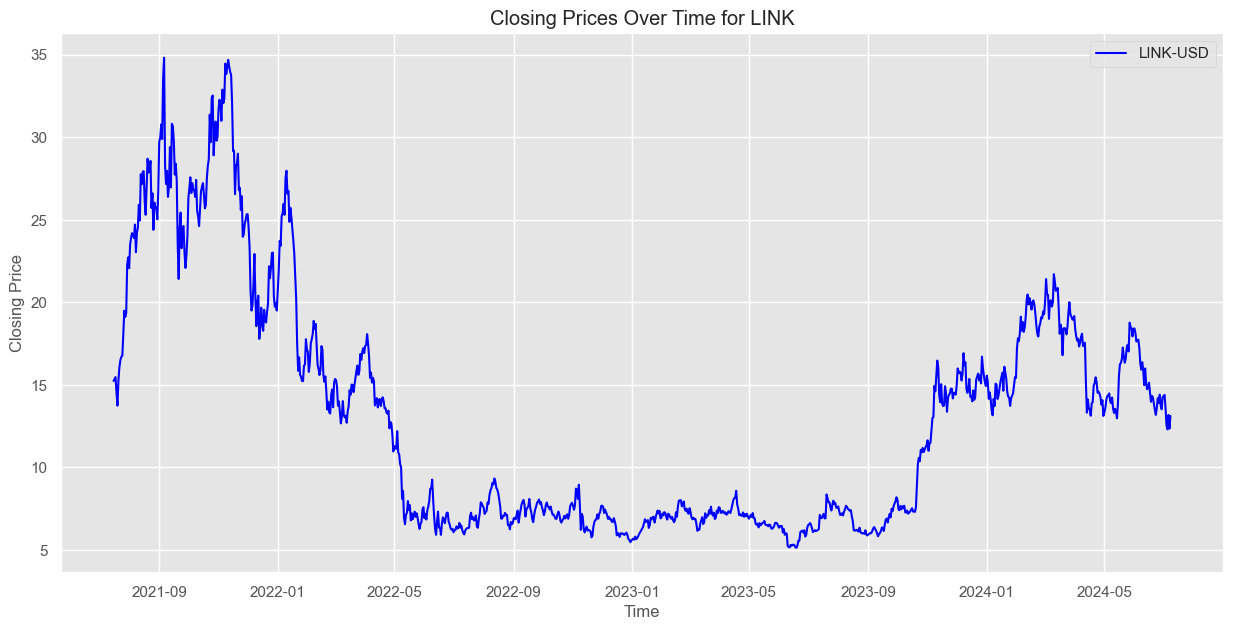

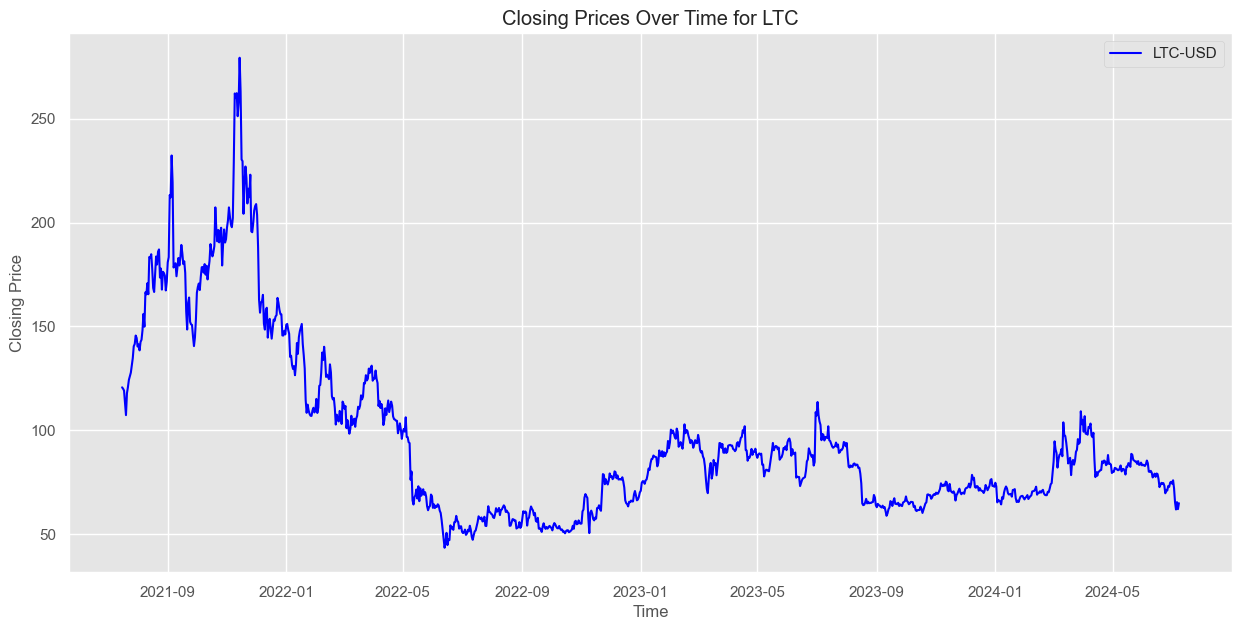

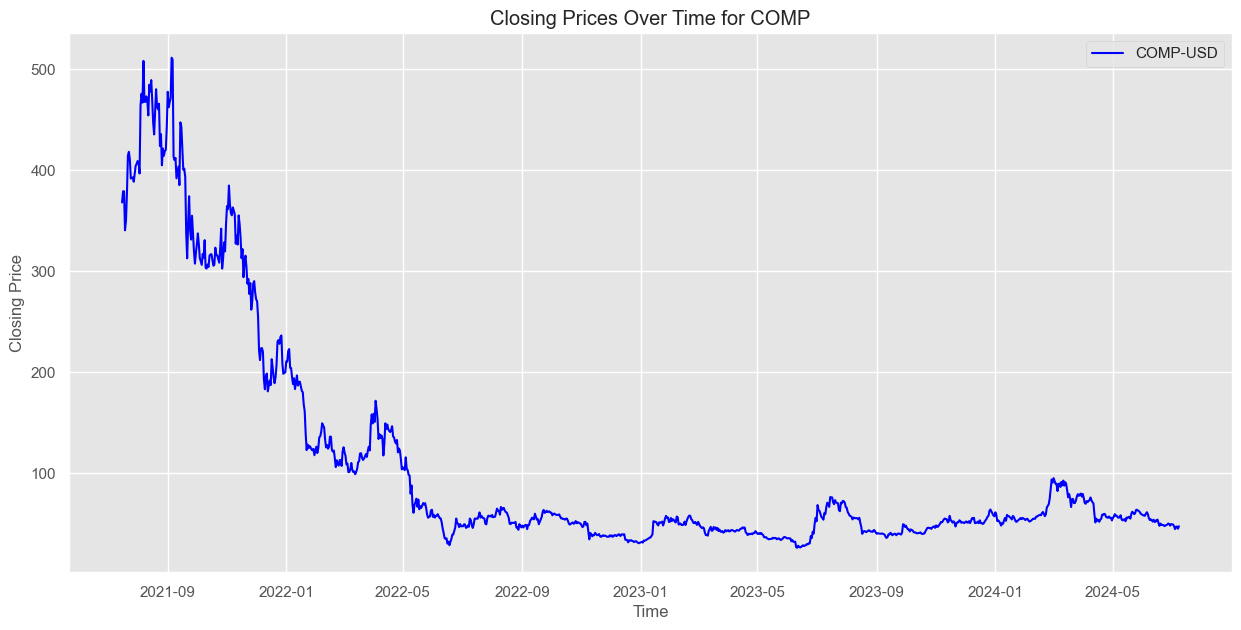

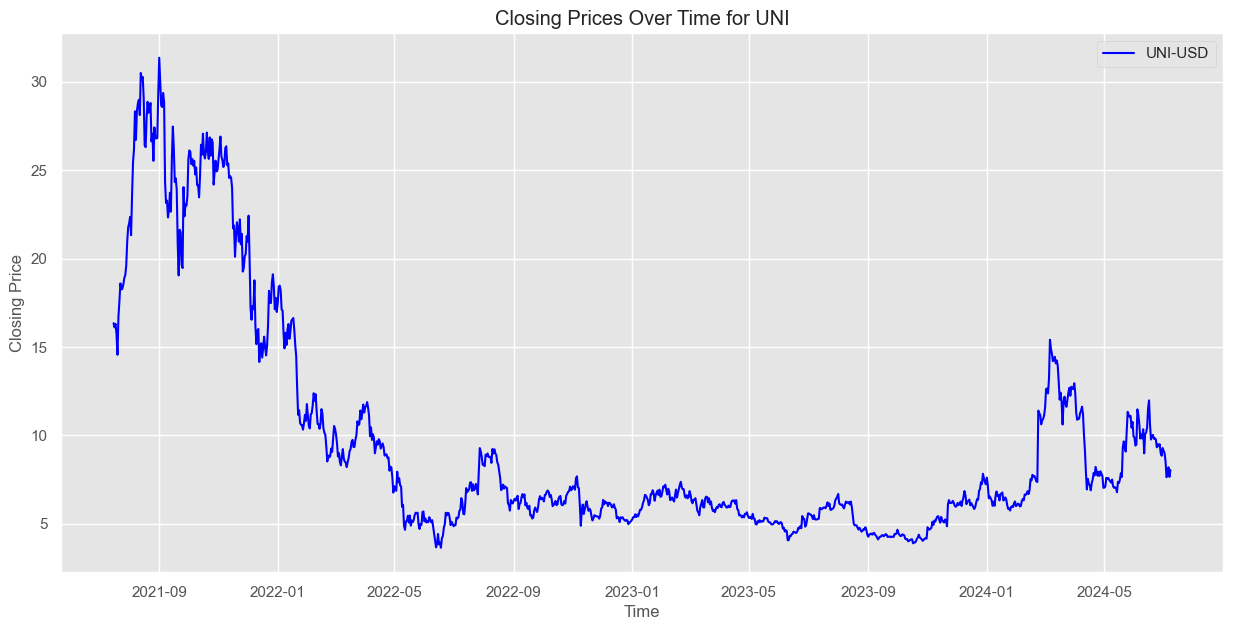

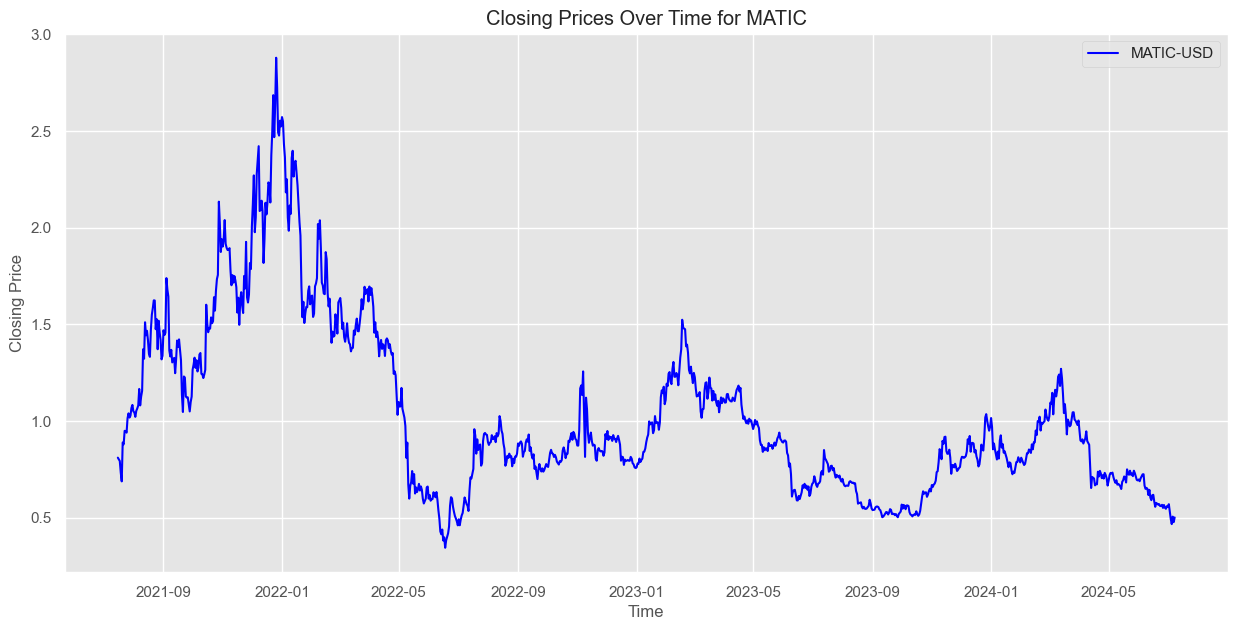

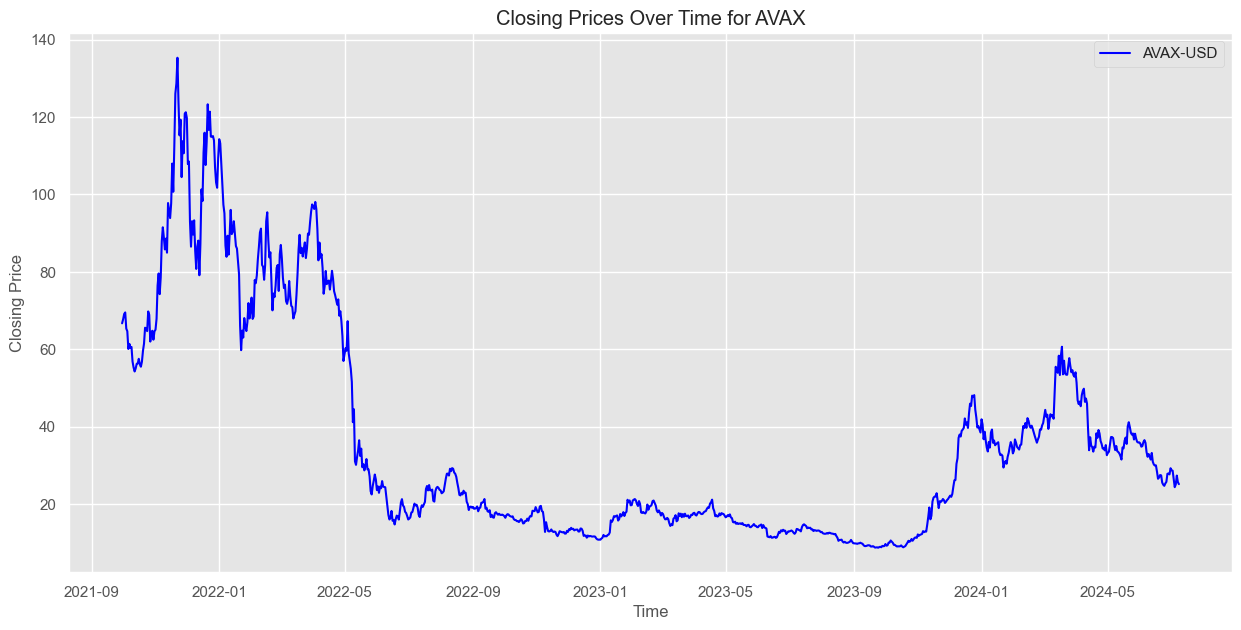

In [56]:
# Line plot for closing prices
def plotClosingPrices(name, data):
    plt.figure(figsize=(15, 7))
    for product in data['product_id'].unique():
        product_data = data[data['product_id'] == product]
        plt.plot(product_data['time'], product_data['close'], label=product, color='blue')
    plt.title(f'Closing Prices Over Time for {name}')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
for name, df in cryptos_info.items():
    plotClosingPrices(name, df)
    

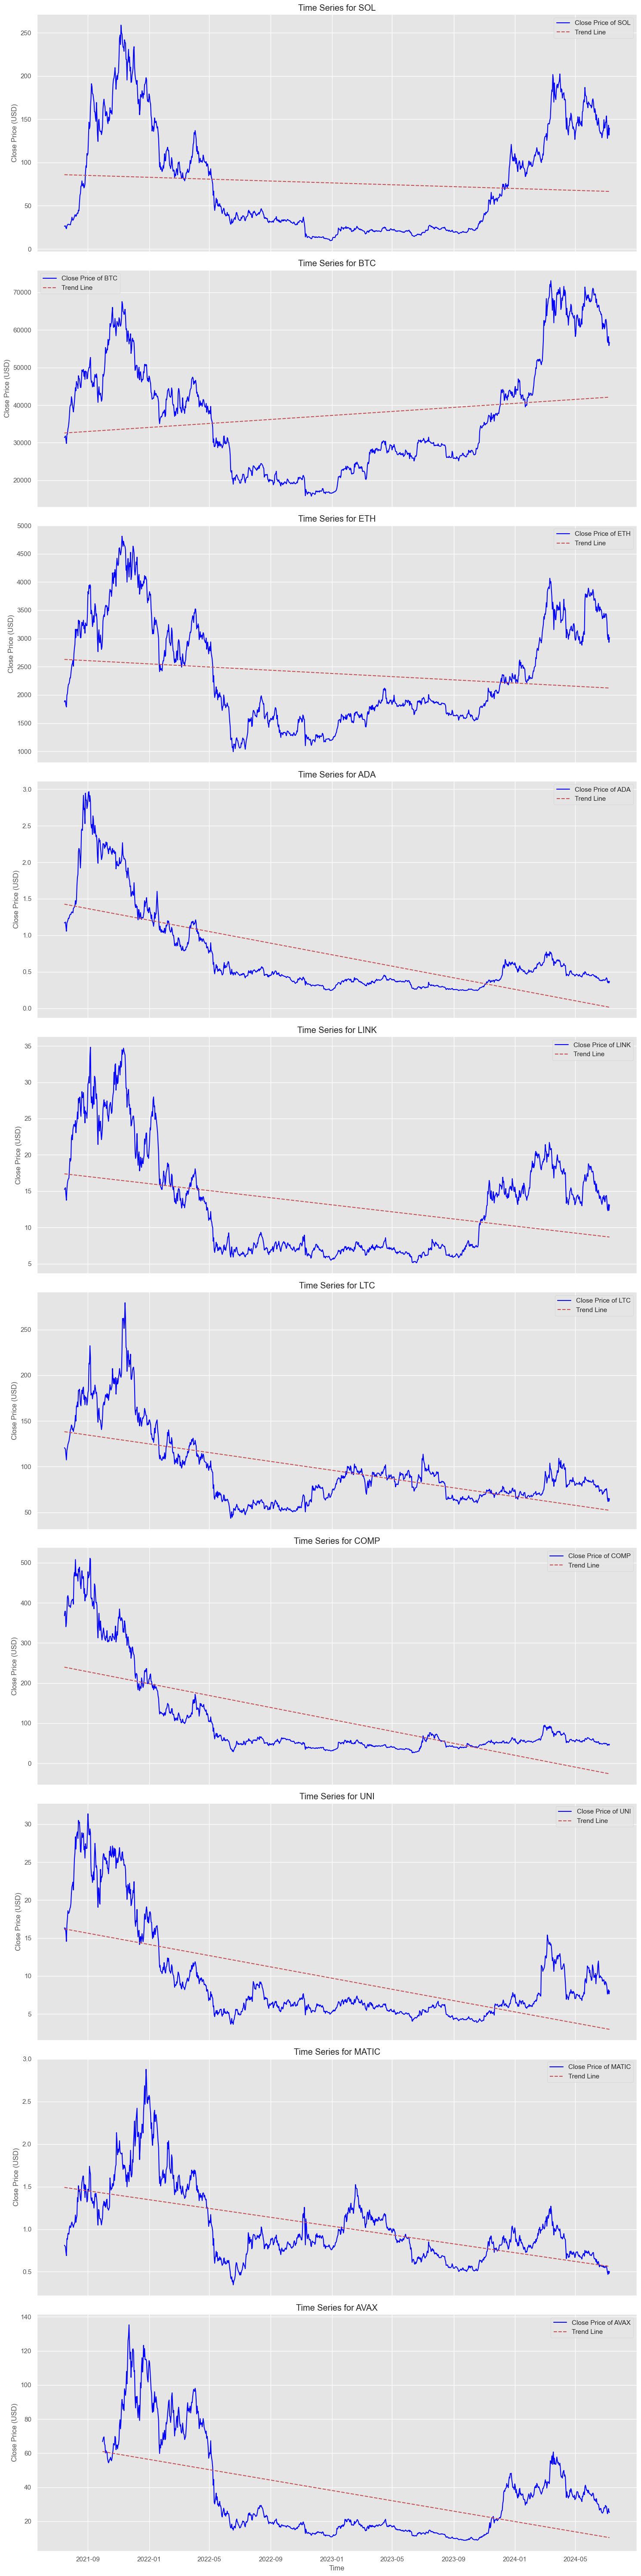

In [57]:
#ARYA
# Function to plot closing prices with subplots and trend lines
def plotClosingPricesWithTrend(cryptos_info):
    num_cryptos = len(cryptos_info)
    fig, axs = plt.subplots(num_cryptos, figsize=(15, 6 * num_cryptos), sharex=True)

    for i, (label, df) in enumerate(cryptos_info.items()):
        axs[i].plot(df['time'], df['close'], label=f'Close Price of {label}', color='blue')
        
        # Adding a trend line
        z = np.polyfit(mdates.date2num(df['time']), df['close'], 1)
        p = np.poly1d(z)
        axs[i].plot(df['time'], p(mdates.date2num(df['time'])), "r--", label="Trend Line")
        
        axs[i].set_title(f'Time Series for {label}')
        axs[i].set_ylabel('Close Price (USD)')
        axs[i].legend()

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

# Example usage
plotClosingPricesWithTrend(cryptos_info)

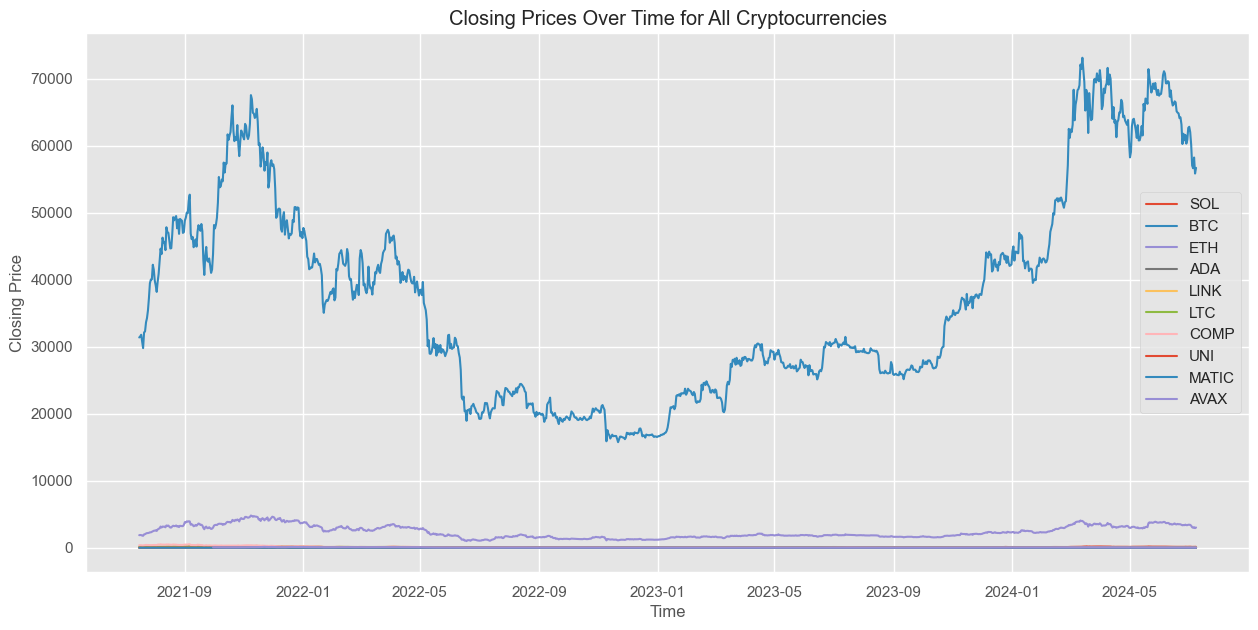

In [58]:
# Function to plot closing prices for all cryptos in one plot
def plotClosingPricesAll(cryptos_info):
    plt.figure(figsize=(15, 7))
    for name, df in cryptos_info.items():
        plt.plot(df['time'], df['close'], label=name)
    plt.title('Closing Prices Over Time for All Cryptocurrencies')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

plotClosingPricesAll(cryptos_info)

### Correlation Matrix of Numeric Features for Each Cryptocurrency

In [59]:
num_features = data.select_dtypes(include=[np.number]).shape[1]
print(f"Number of numerical features: {num_features}")

Number of numerical features: 9


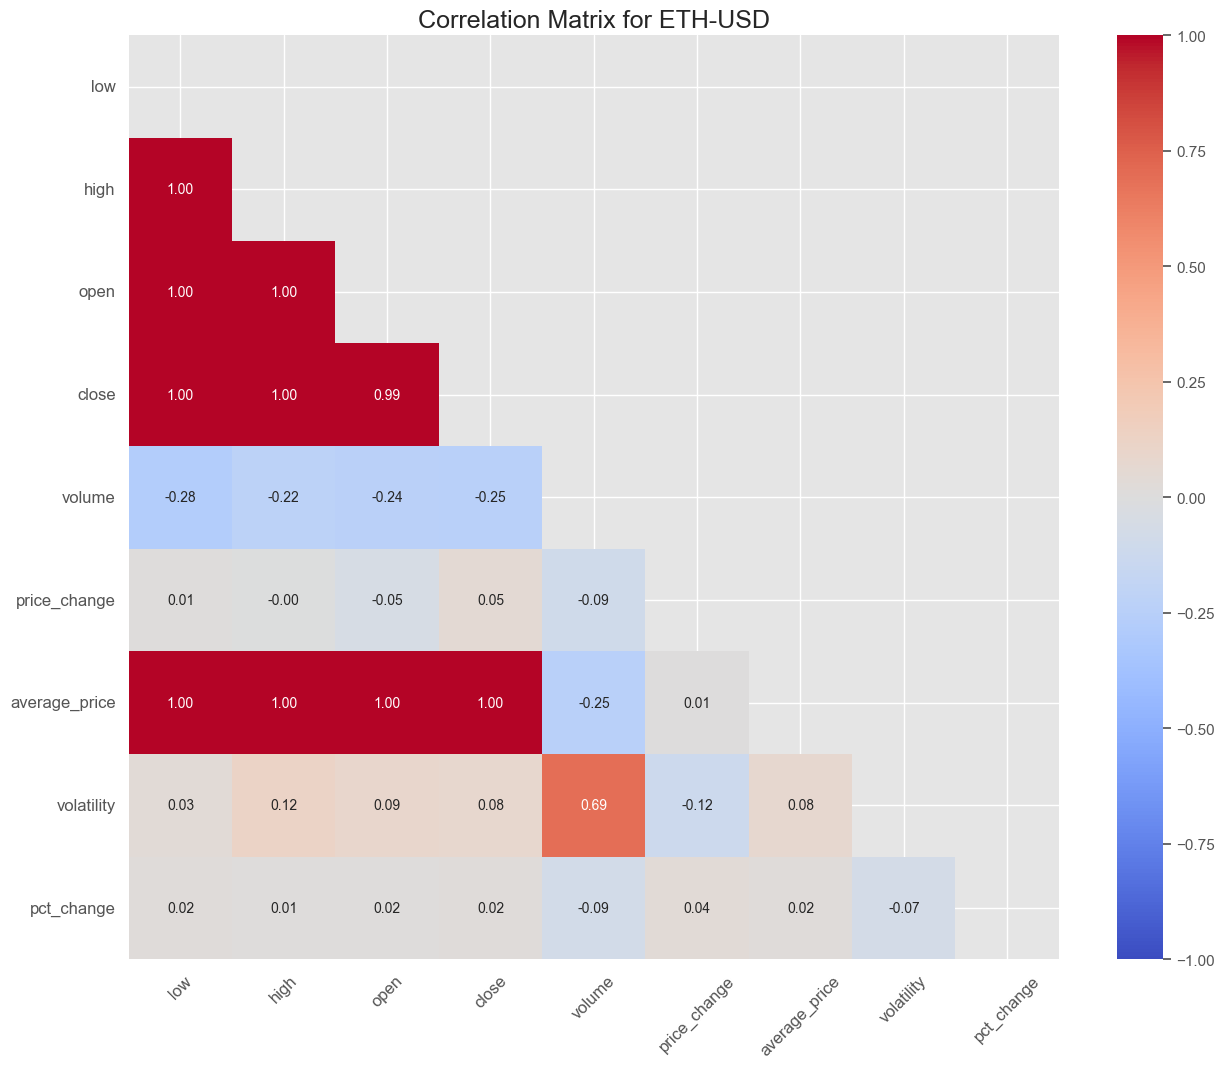

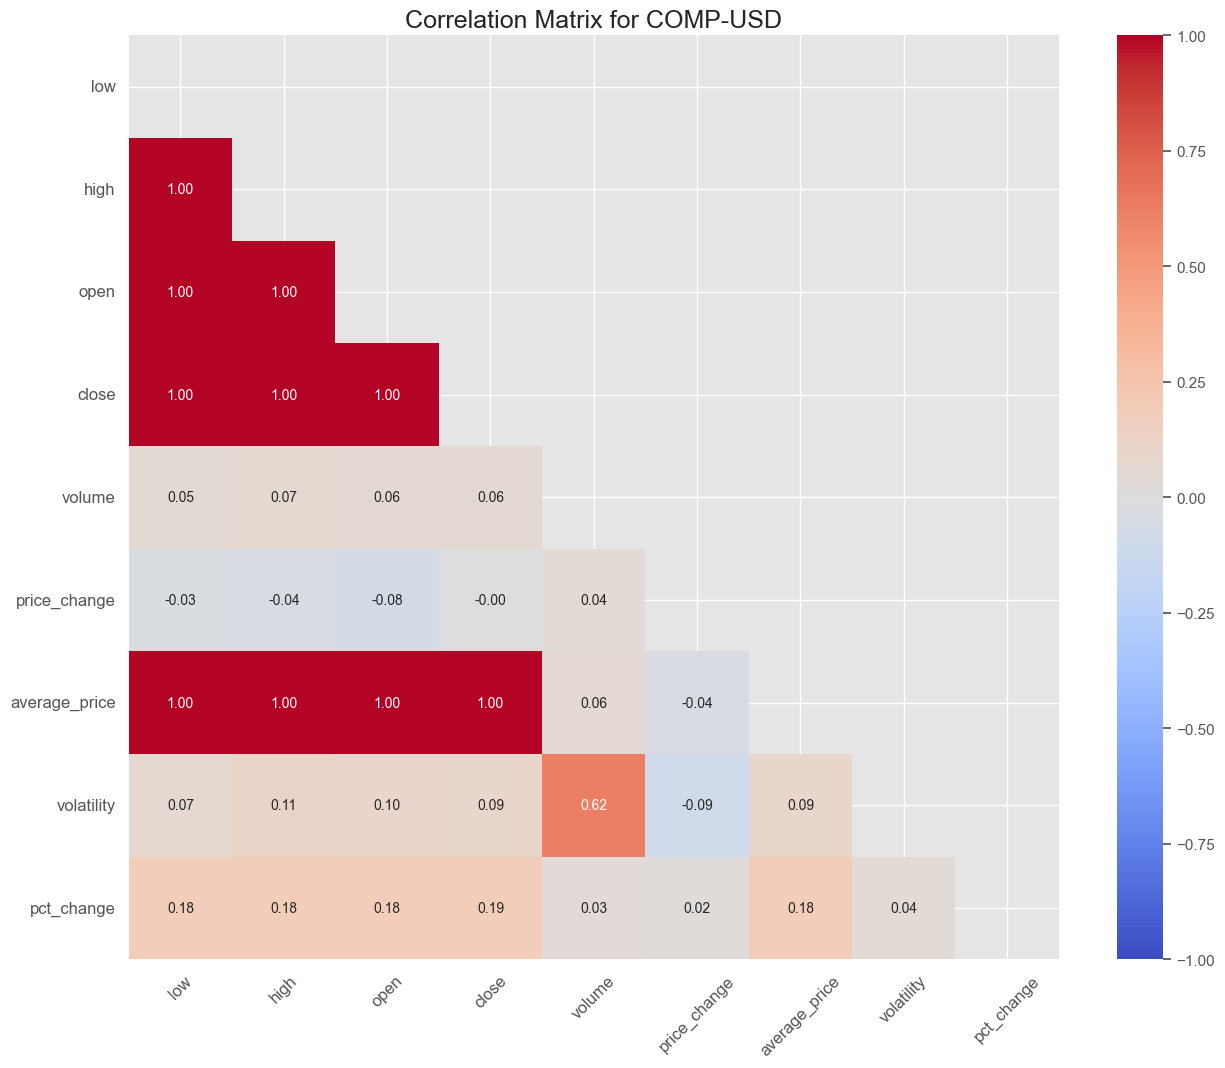

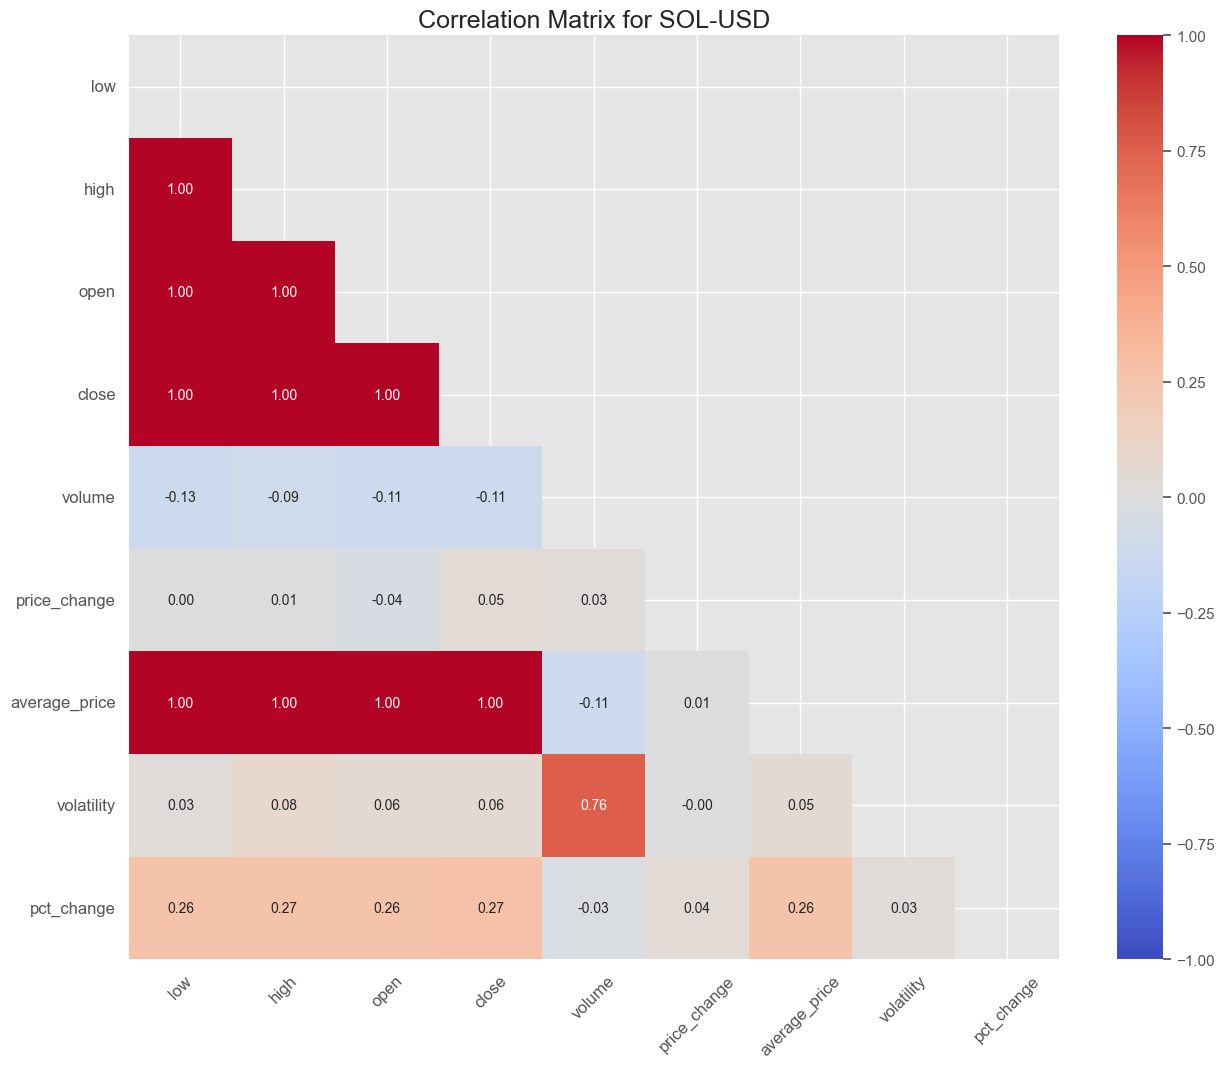

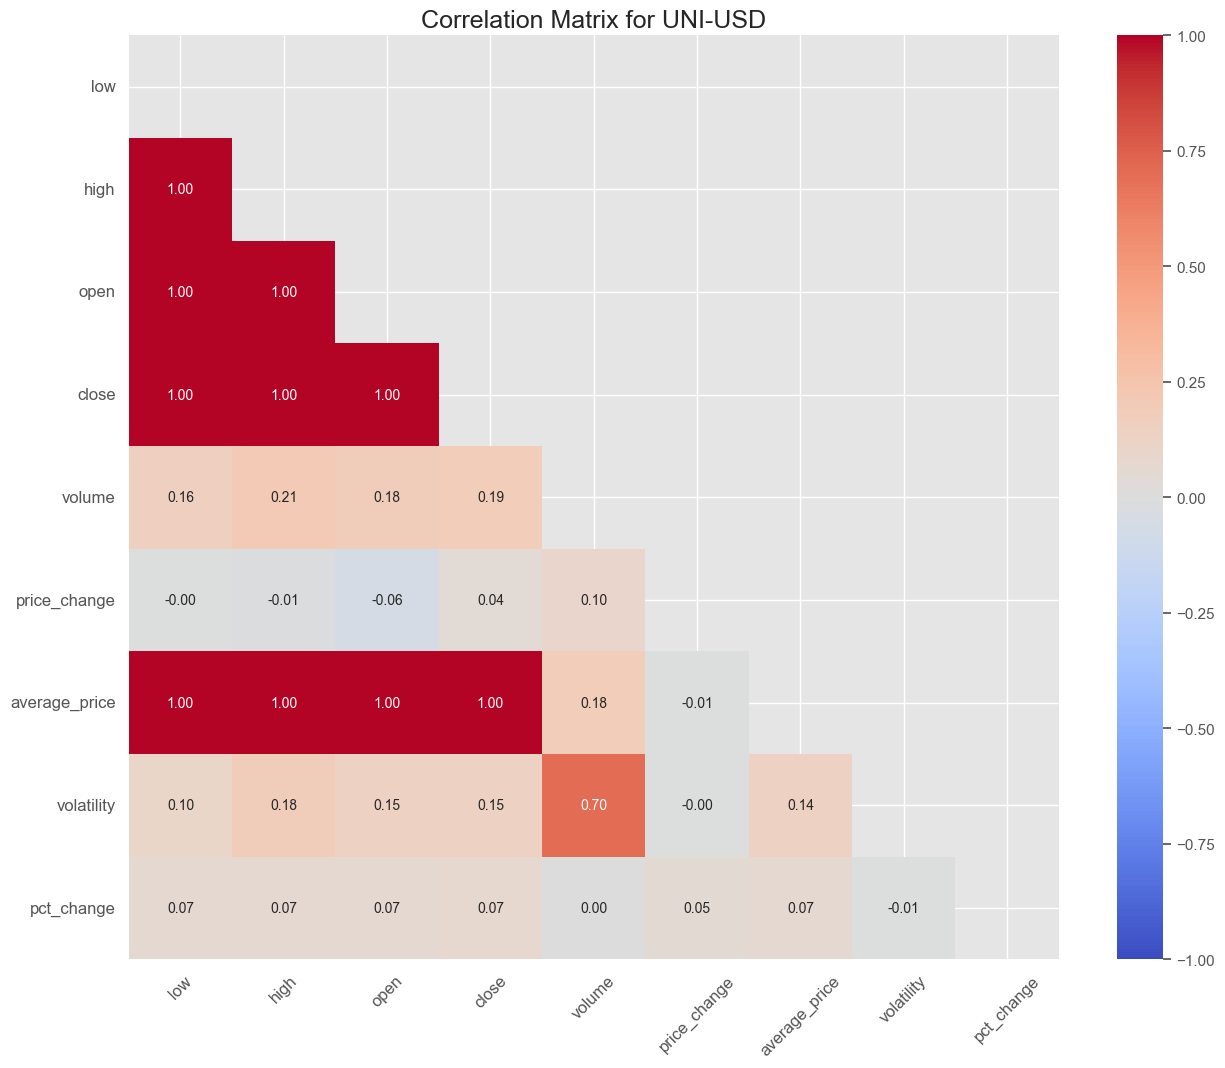

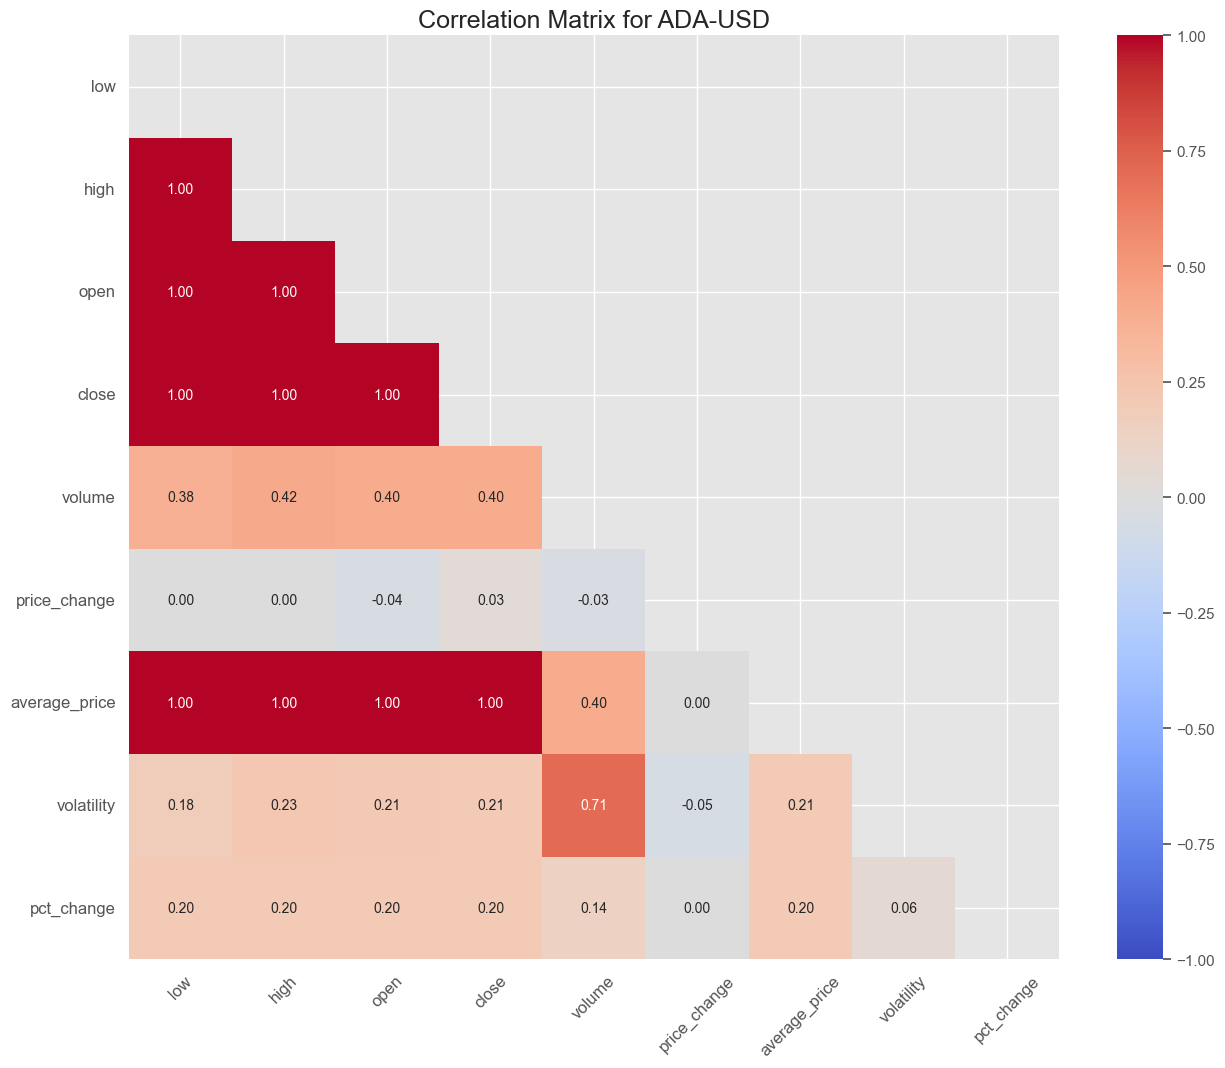

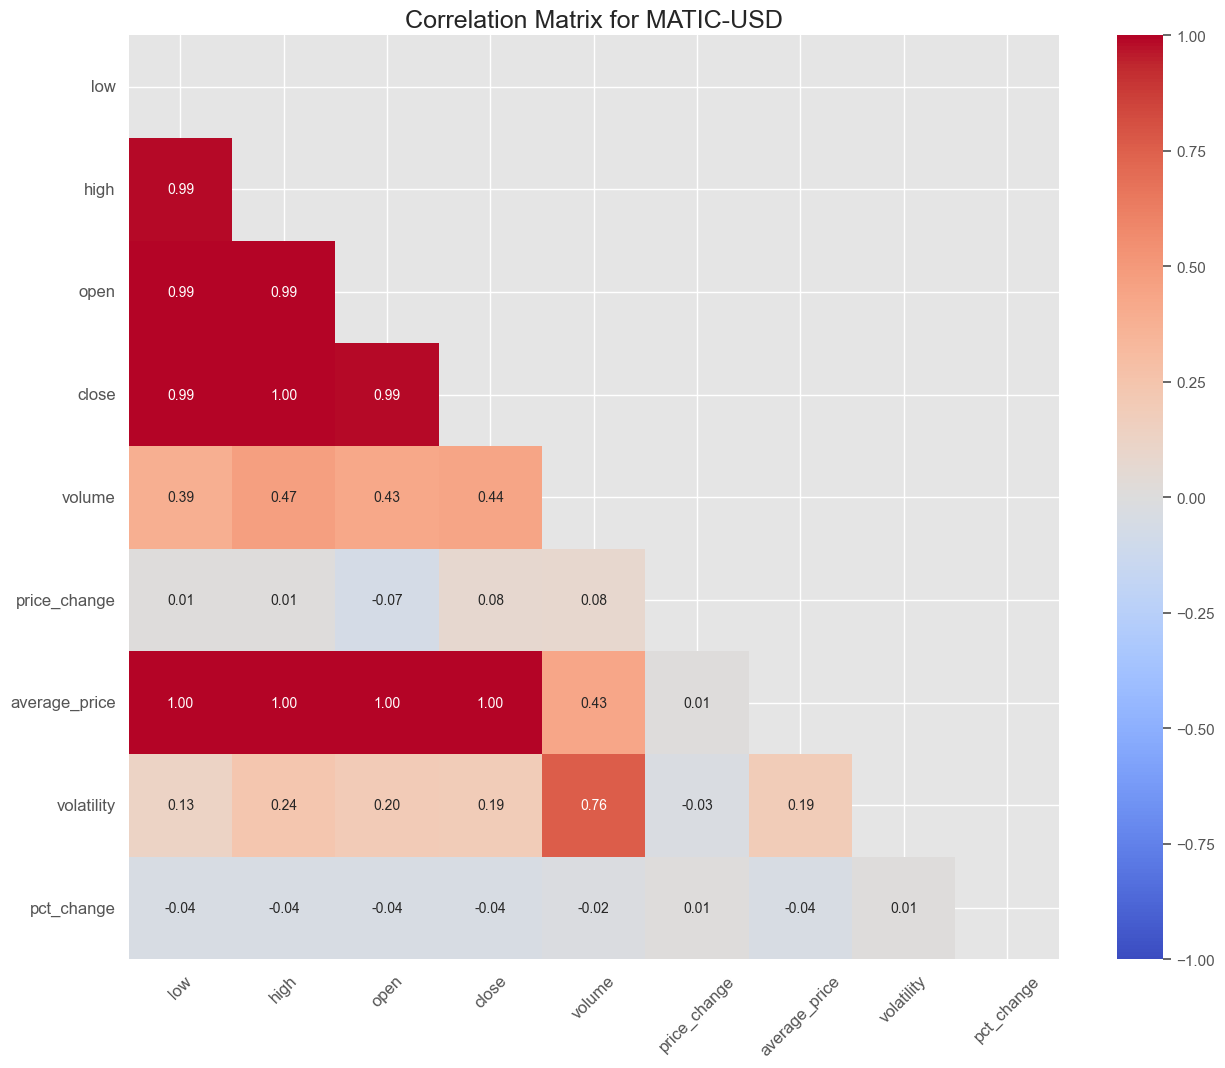

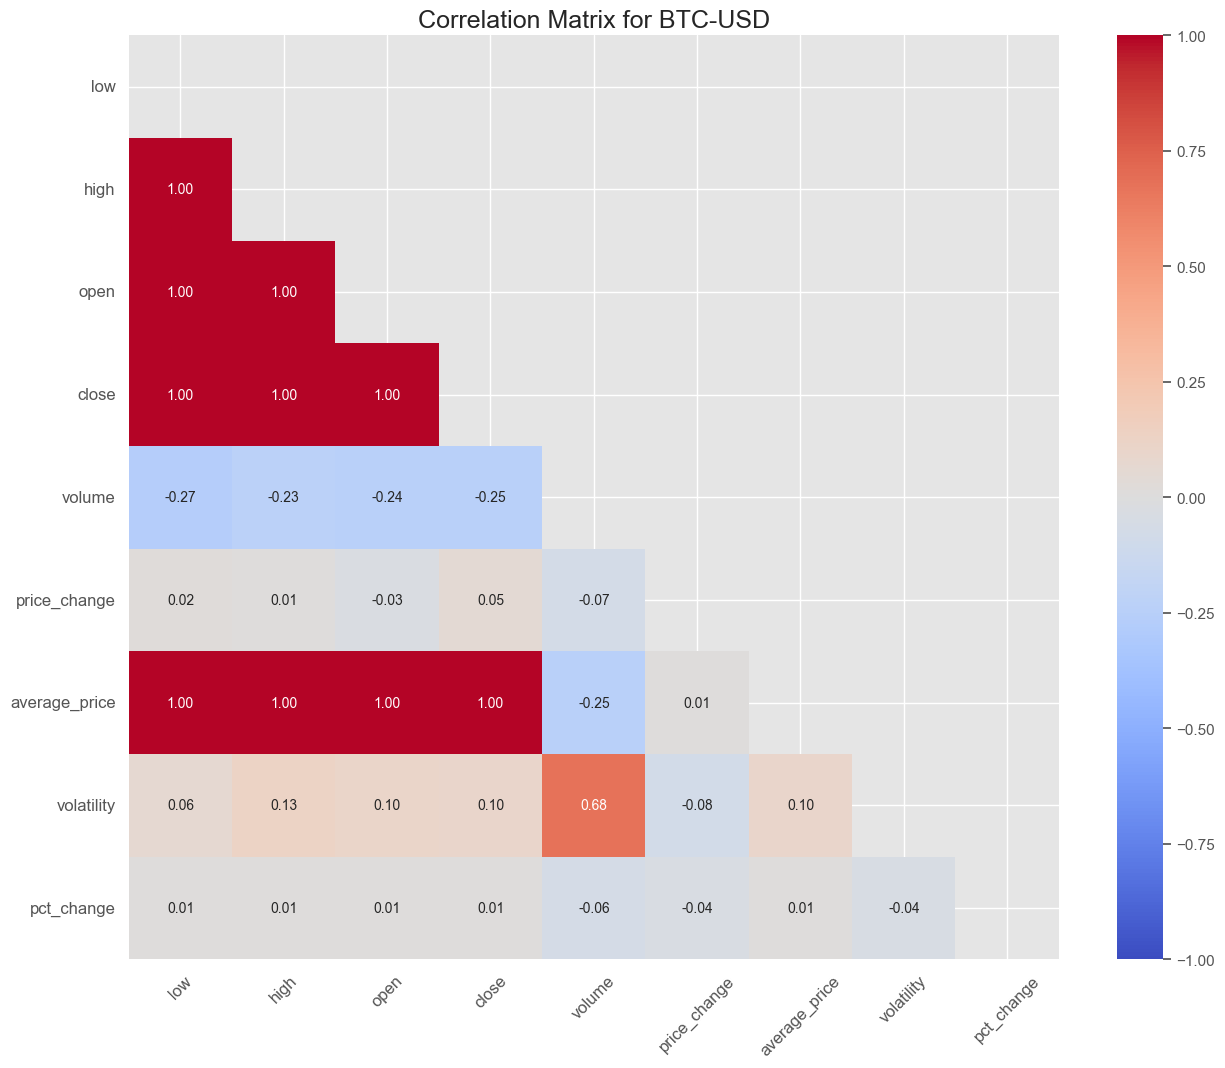

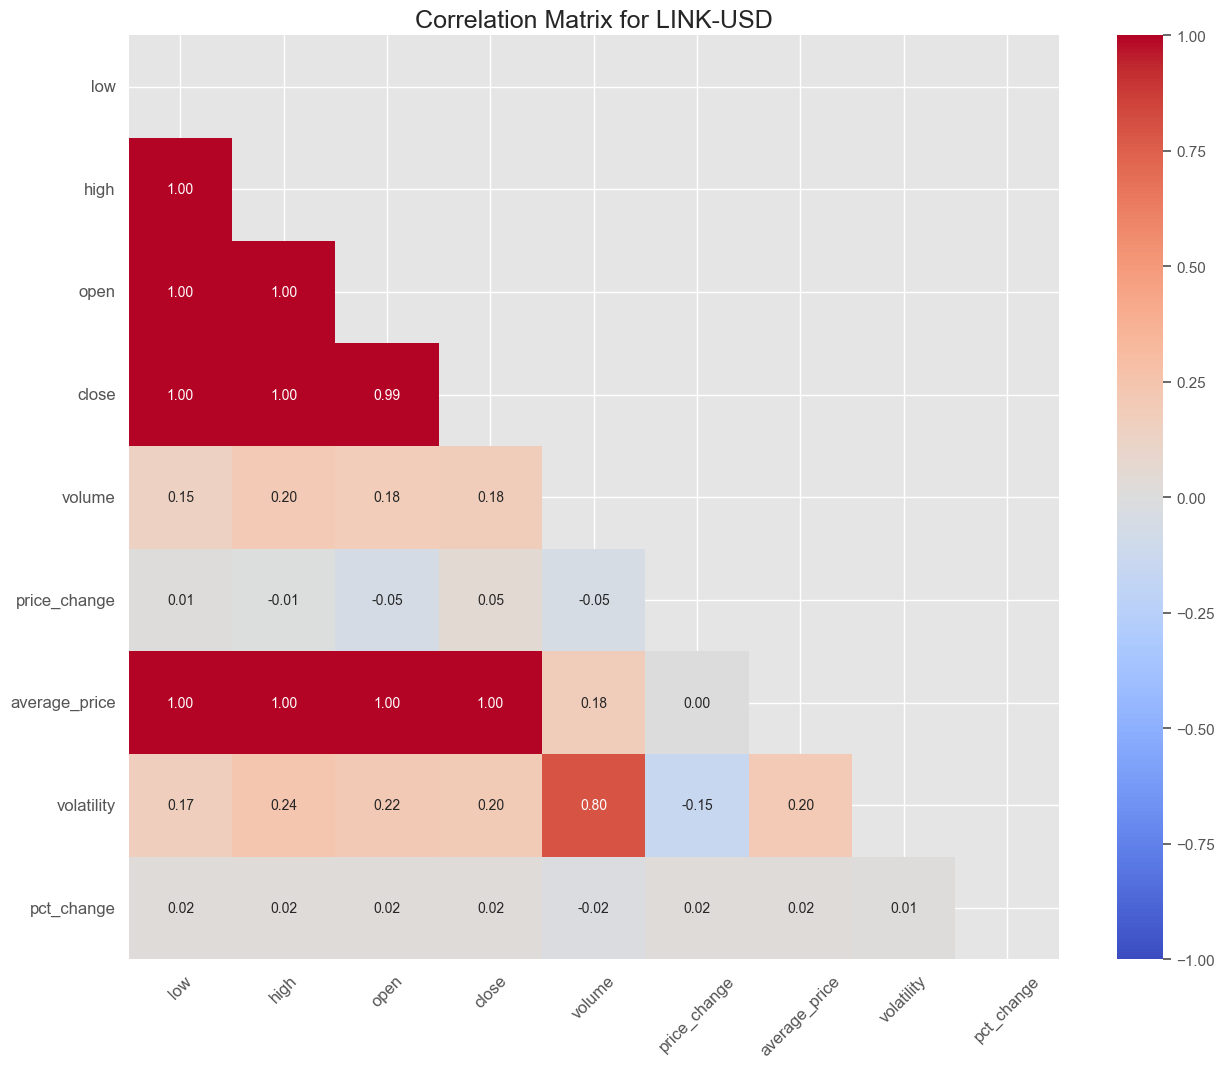

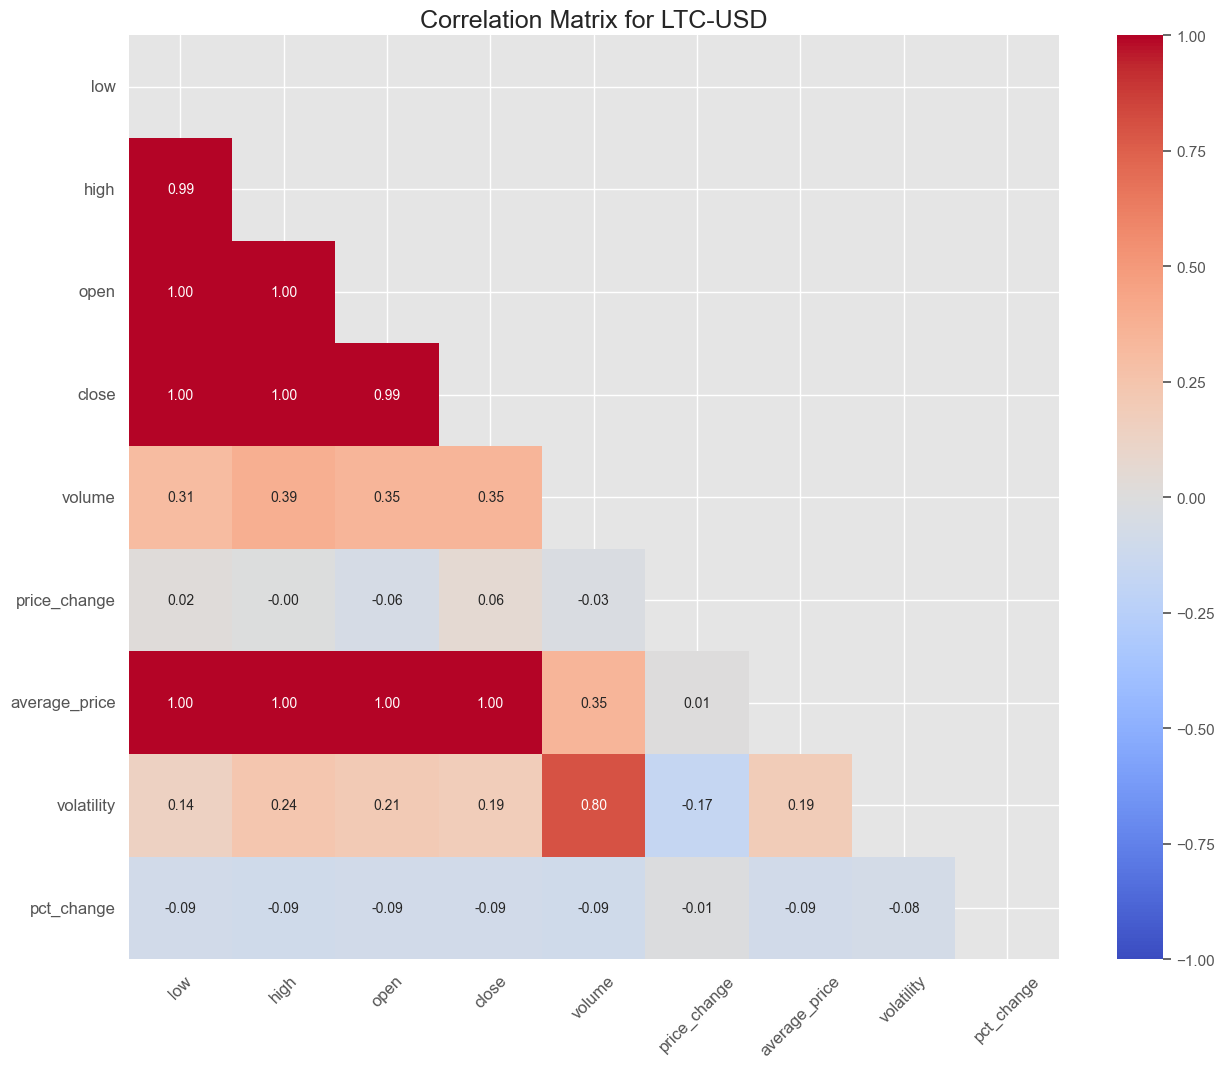

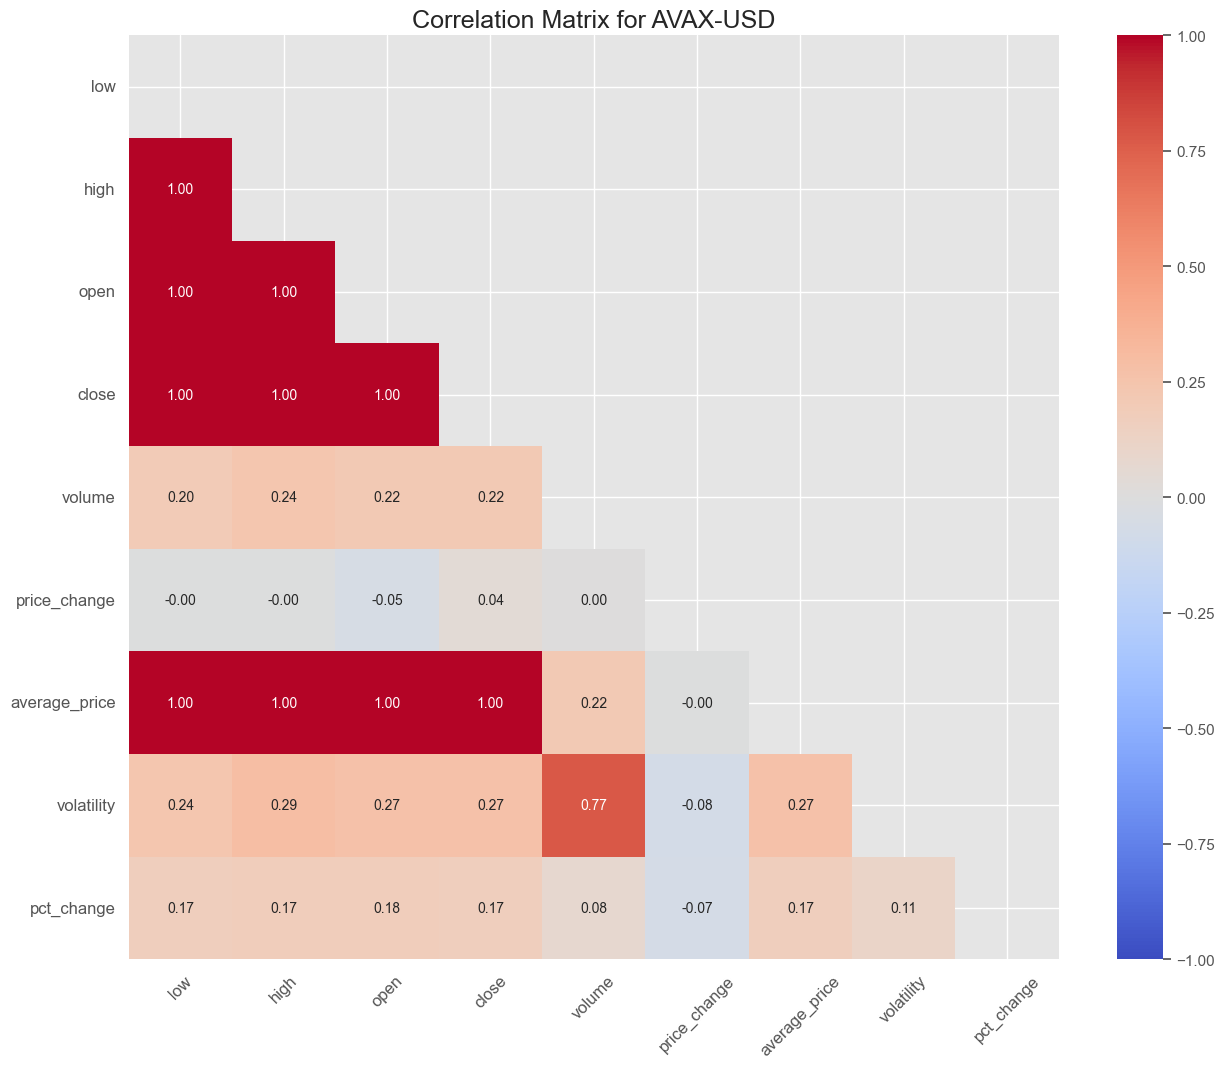

In [60]:
for coin in data['product_id'].unique():
    plt.figure(figsize=(15, 12))  # Adjusted figure size for 30 numerical features
    coin_data = data[data['product_id'] == coin].select_dtypes(include=[np.number])
    corr_matrix = coin_data.corr()
    
    # Generate a heatmap with upper triangle masked
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, mask=mask, annot_kws={'fontsize': 10})  # Adjusted annotation font size
    
    plt.title(f'Correlation Matrix for {coin}', fontsize=18)  # Increased title font size
    plt.xticks(rotation=45, fontsize=12)  # Increased x-axis font size
    plt.yticks(rotation=0, fontsize=12)  # Increased y-axis font size
    plt.show()

In [61]:
# Dictionary to hold correlation matrices
correlation_matrices = {}

# Calculate and store correlation matrices for each cryptocurrency
for coin in df['product_id'].unique():
    # Filter data for the current cryptocurrency and select numeric types
    coin_data = df[df['product_id'] == coin].select_dtypes(include=[np.number])
    correlation_matrices[coin] = coin_data.corr()

# Option 1: Display each matrix as a DataFrame in Jupyter Notebook
for coin, matrix in correlation_matrices.items():
    print(f"Correlation Matrix for {coin}:")
    display(matrix)  # This uses IPython.display.display to show DataFrames nicely in Jupyter

# Option 2: Export each matrix to a CSV file
for coin, matrix in correlation_matrices.items():
    matrix.to_csv(f'correlation_matrix_{coin}.csv')

Correlation Matrix for AVAX-USD:


Unnamed: 0       low      high      open     close    volume  \
Unnamed: 0       1.000000 -0.515769 -0.522247 -0.518610 -0.517520 -0.112913   
low             -0.515769  1.000000  0.997212  0.997300  0.997763  0.195791   
high            -0.522247  0.997212  1.000000  0.997836  0.998044  0.236786   
open            -0.518610  0.997300  0.997836  1.000000  0.995405  0.218134   
close           -0.517520  0.997763  0.998044  0.995405  1.000000  0.218546   
volume          -0.112913  0.195791  0.236786  0.218134  0.218546  1.000000   
price_change     0.014214 -0.000654 -0.003313 -0.053418  0.042450  0.003098   
average_price   -0.519548  0.999224  0.999377  0.998277  0.998606  0.217570   
volatility      -0.205398  0.235613  0.293510  0.273290  0.266209  0.774731   

               price_change  average_price  volatility  
Unnamed: 0         0.014214      -0.519548   -0.205398  
low               -0.000654       0.999224    0.235613  
high              -0.003313       0.999377    0.293510  
open              -0.053418       0.998277    0.273290  
close              0.042450       0.998606    0.266209  
volume             0.003098       0.217570    0.774731  
price_change       1.000000      -0.002058   -0.075341  
average_price     -0.002058       1.000000    0.266343  
volatility        -0.075341       0.266343    1.000000

In [62]:
# Scatter plot matrix
def plotScatterMatrix(name, cryptoData):
    sns.pairplot(cryptoData)
    plt.suptitle(f'Scatter Plot Matrix for {name}')
    plt.show()
    
for name, df in cryptos_info.items():
    plotScatterMatrix(name, df)

KeyboardInterrupt: 

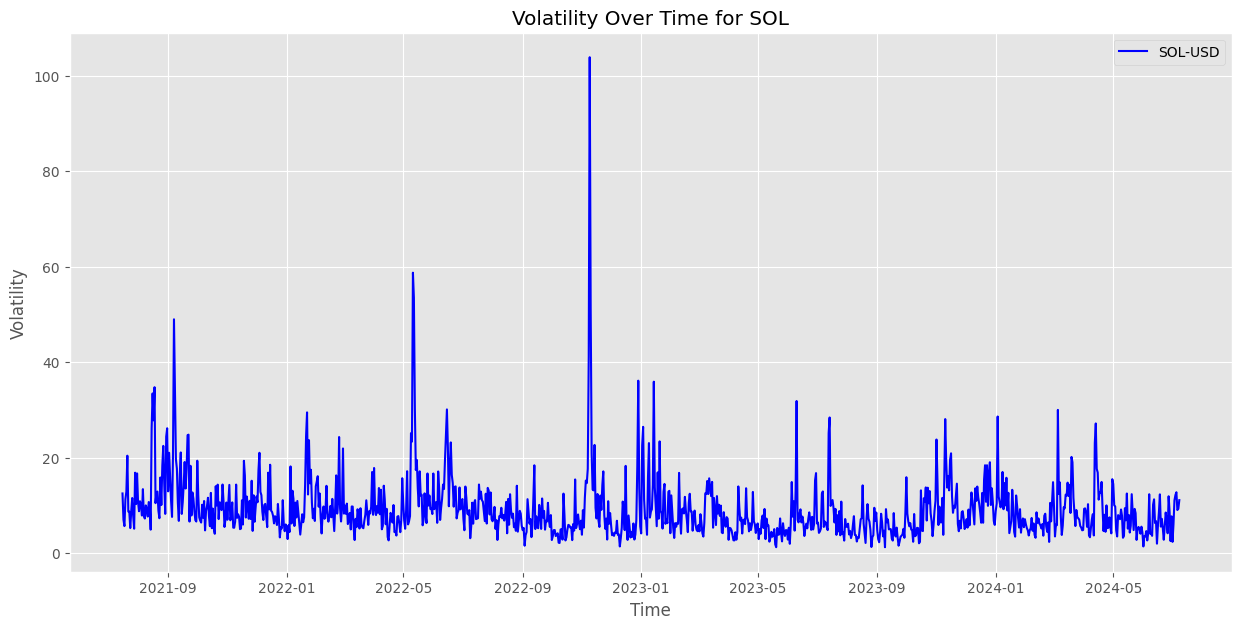

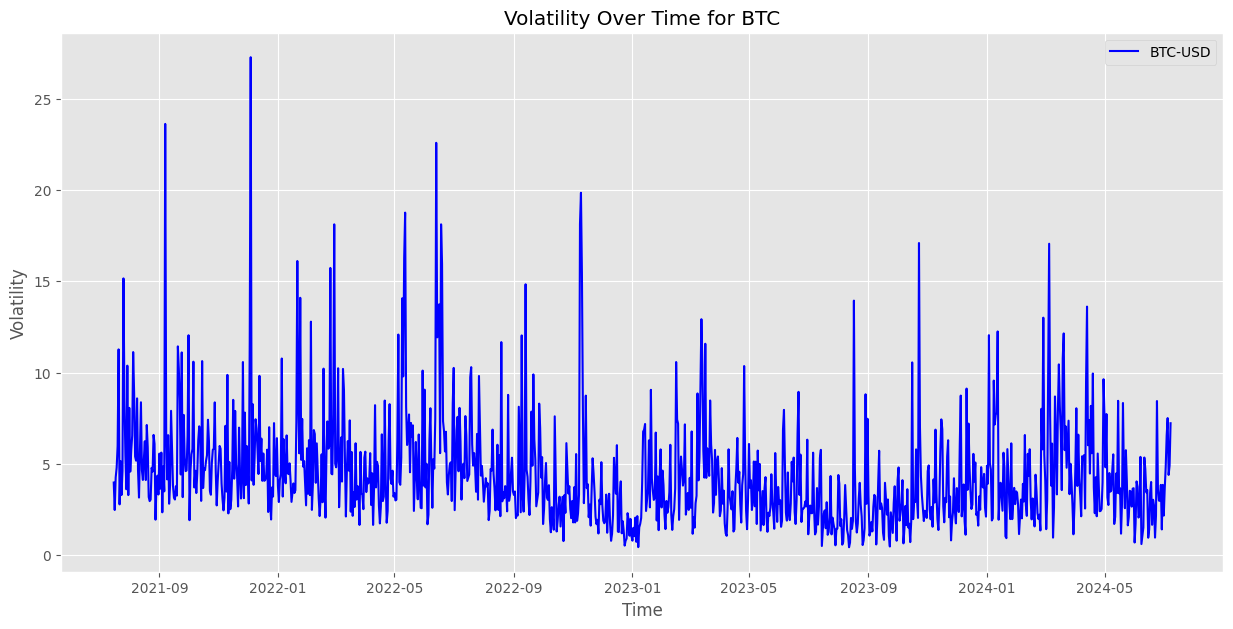

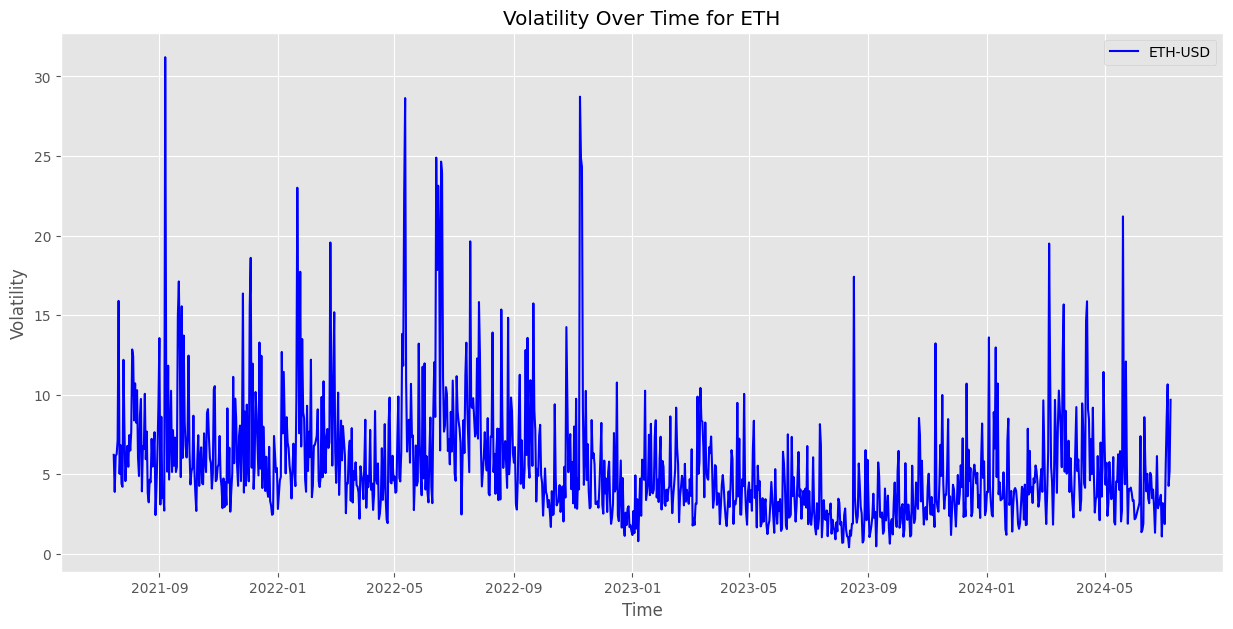

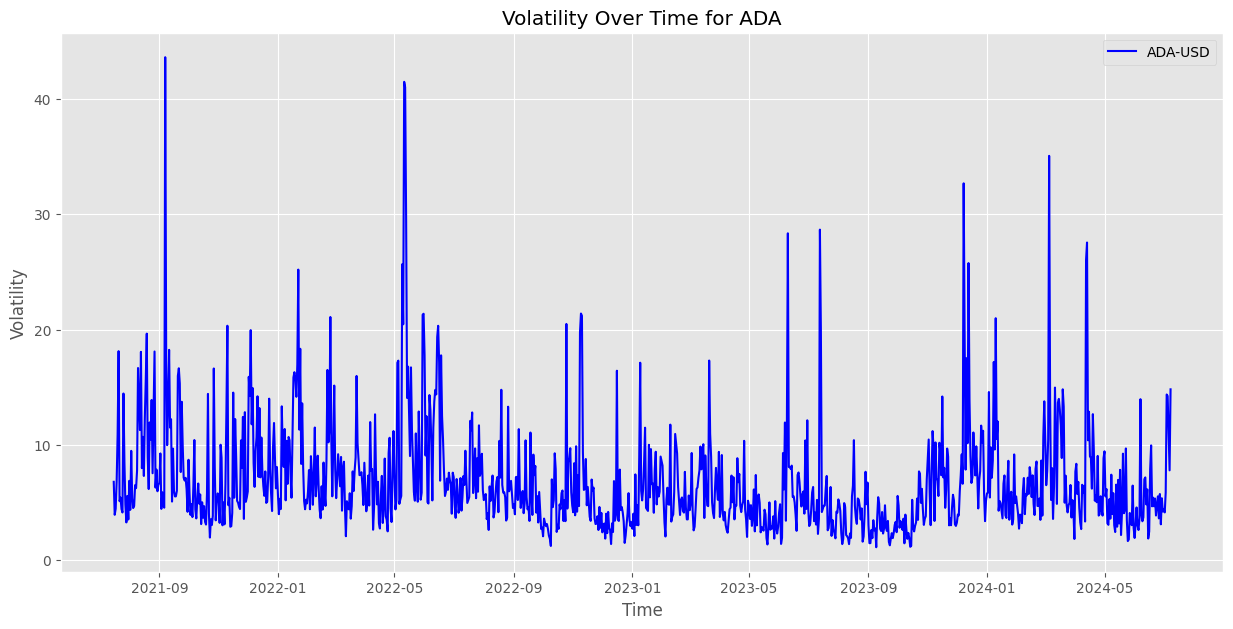

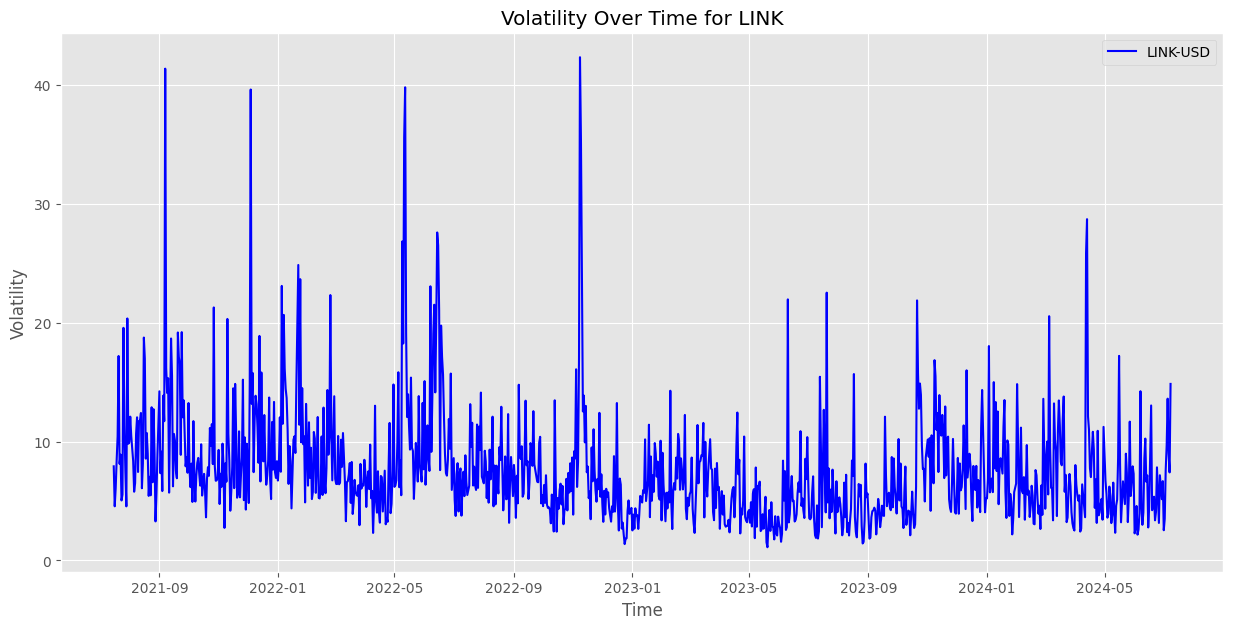

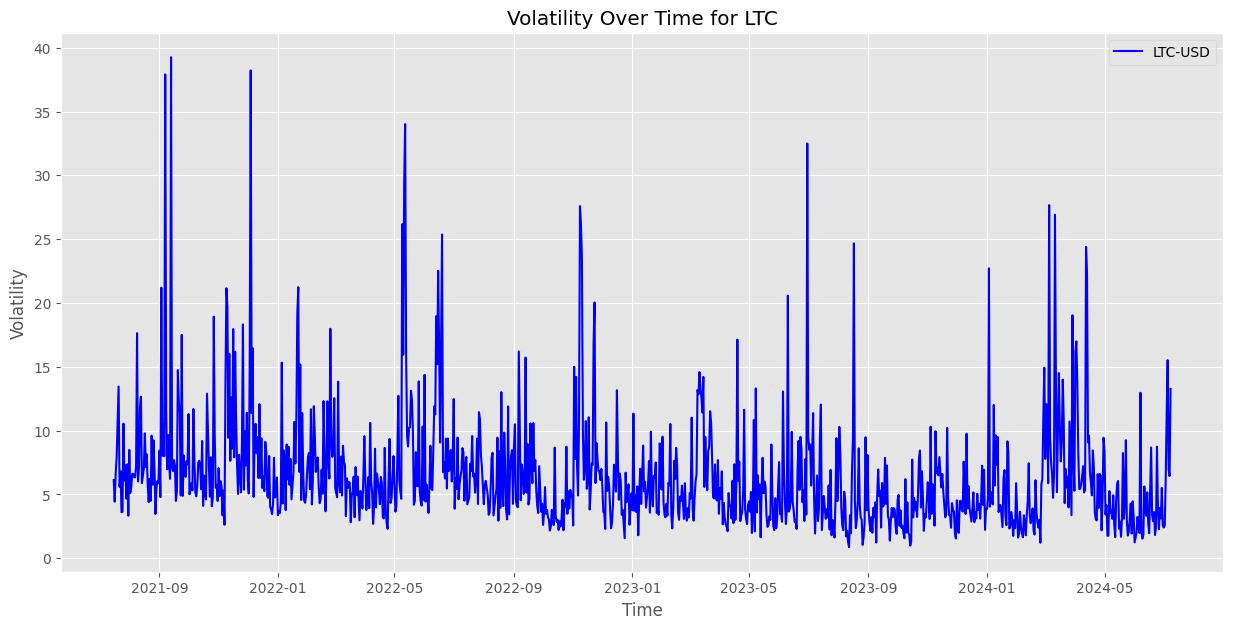

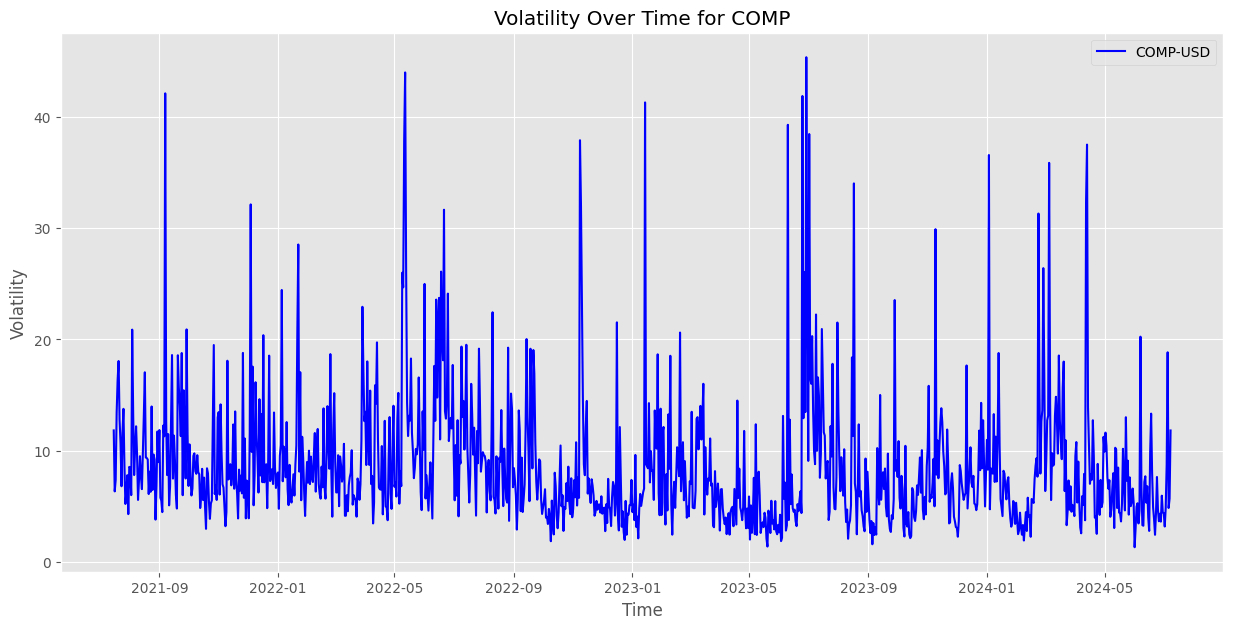

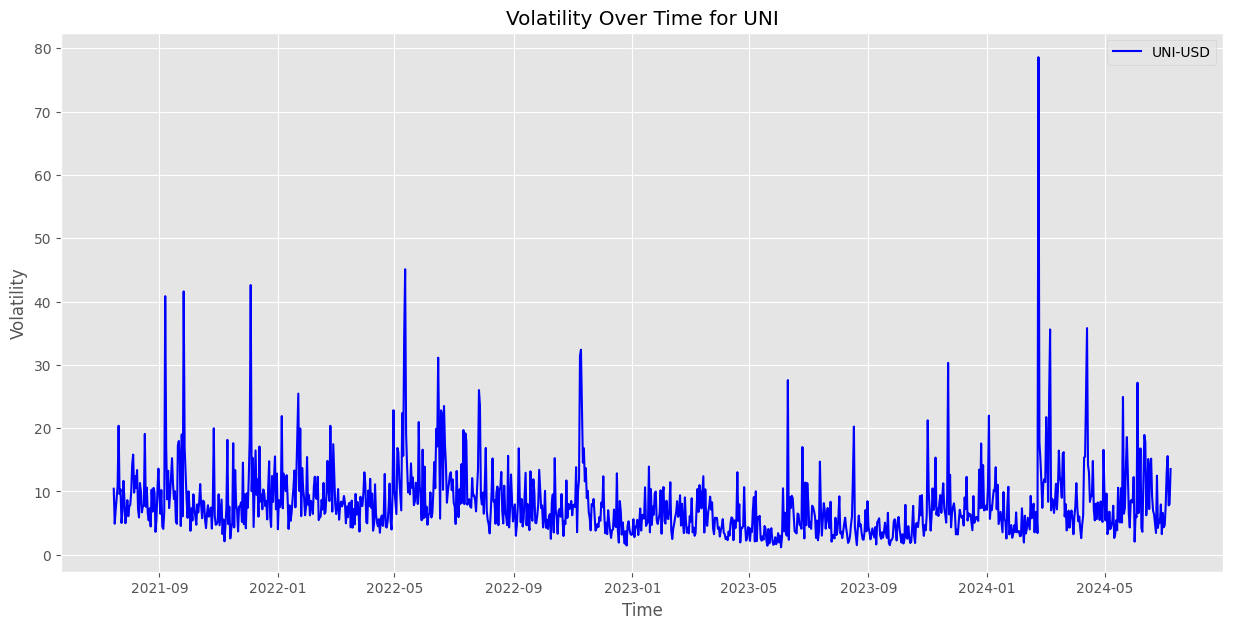

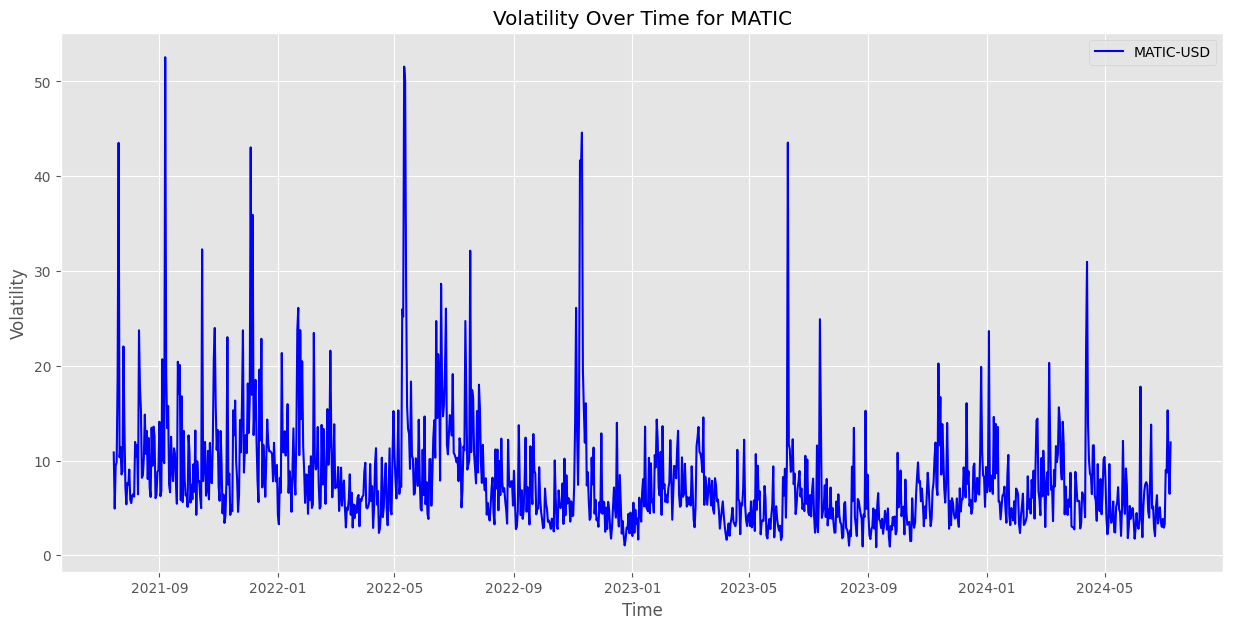

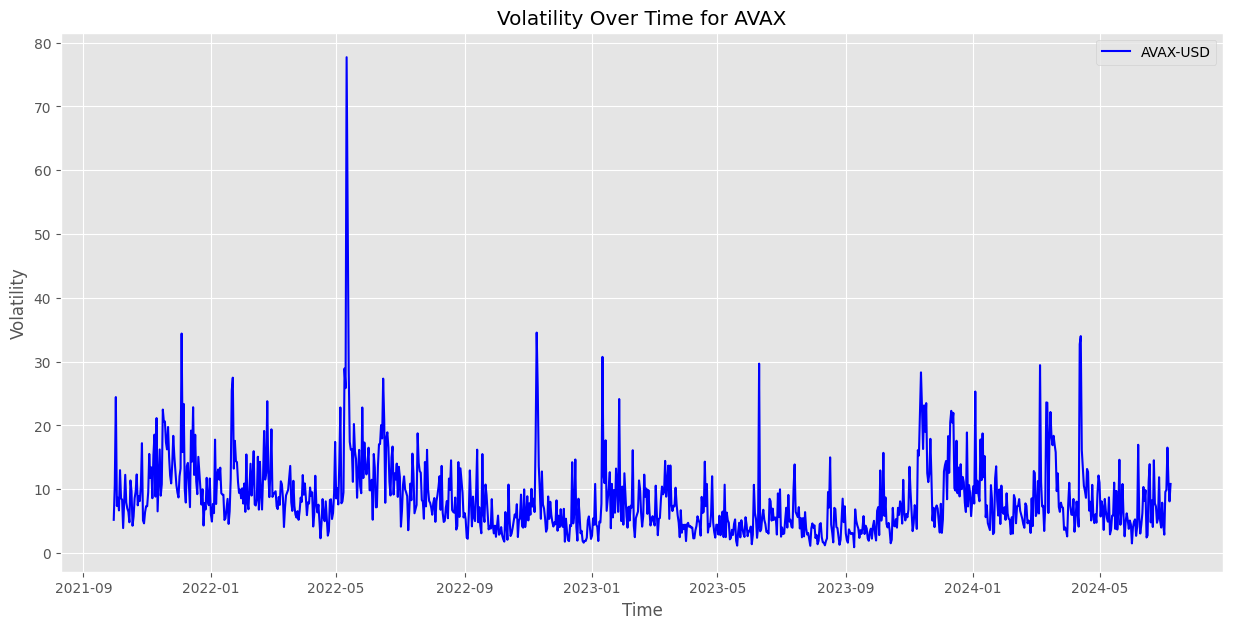

In [ ]:

def calculateVolatility(cryptoData):
    # Calculate volatility if not present
    if 'volatility' not in cryptoData.columns:
        cryptoData.loc[:, 'volatility'] = cryptoData['close'].pct_change().rolling(window=10).std() * (252**0.5)

def plotVolatilityOverTime(name, data):
    # Plot volatility over time
    calculateVolatility(data)
    plt.figure(figsize=(15, 7))
    for product in data['product_id'].unique():
        product_data = data[data['product_id'] == product]
        plt.plot(product_data['time'], product_data['volatility'], label=product, color="blue")
    plt.title(f'Volatility Over Time for {name}')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
    
for name, df in cryptos_info.items():
    plotVolatilityOverTime(name, df)

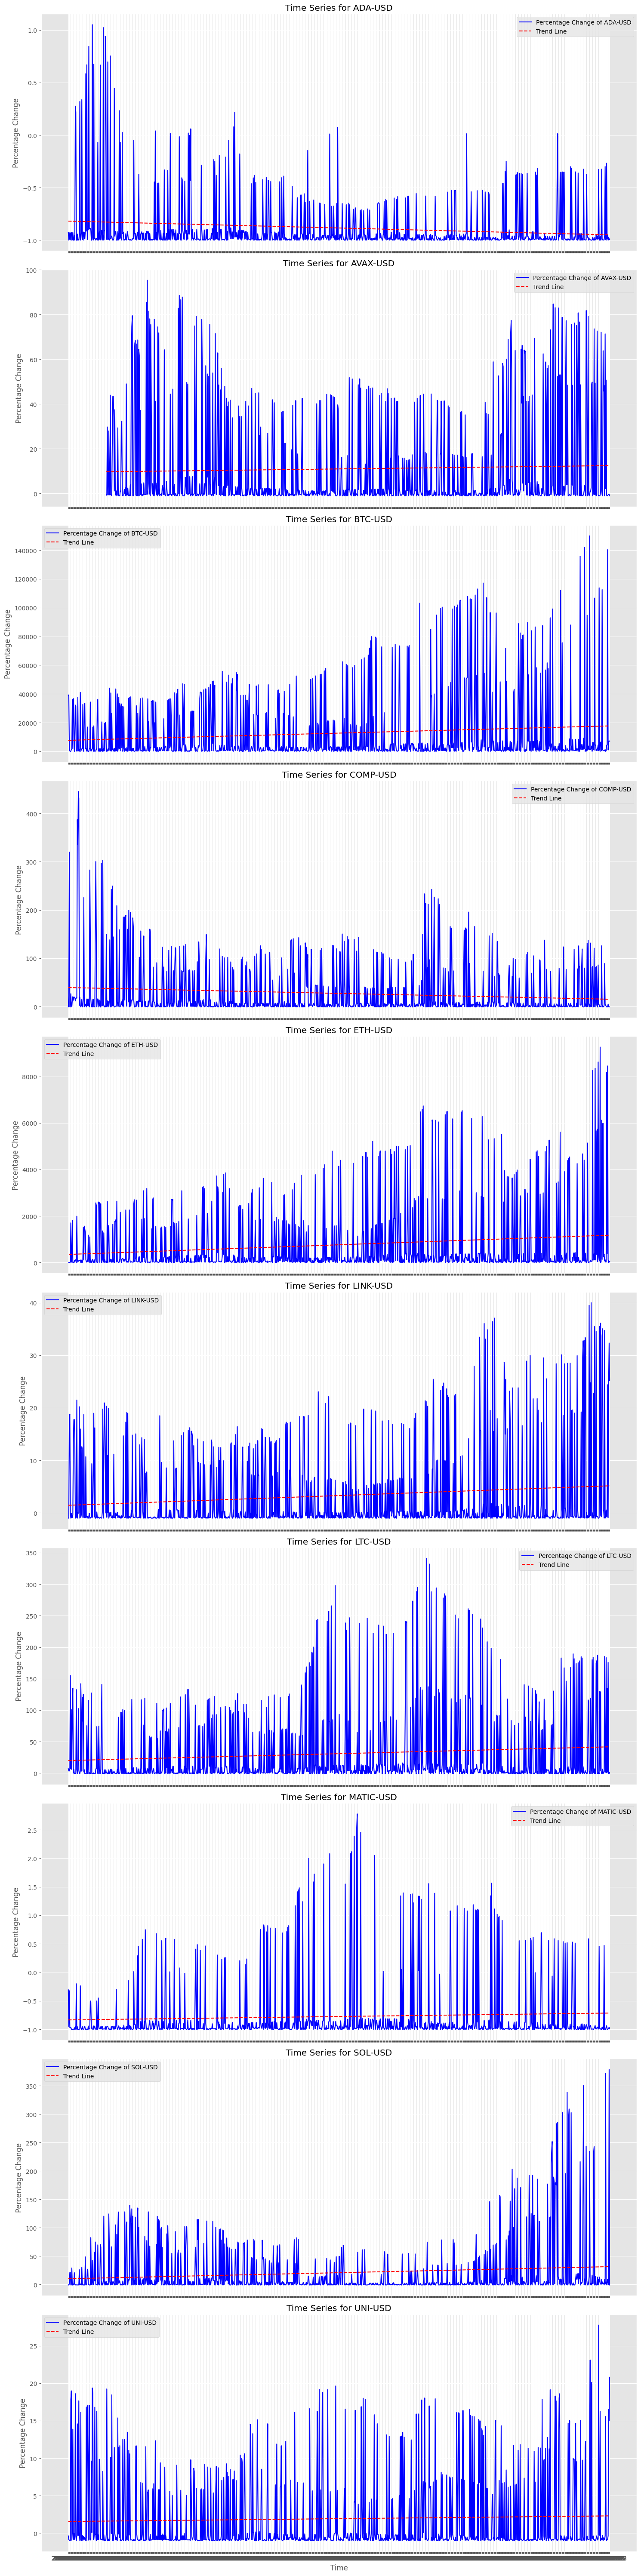

In [ ]:
#ARYA
# Function to plot percentage change with subplots and trend lines
def plotPercentageChangeWithTrend(df):
    num_products = len(df['product_id'].unique())
    fig, axs = plt.subplots(num_products, figsize=(15, 6 * num_products), sharex=True)

    # Ensure 'axs' is always an array, even with one product_id
    axs = np.array(axs).reshape(-1)

    # Iterate over each unique cryptocurrency for plotting
    for i, (label, df_product) in enumerate(df.groupby('product_id')):
        # Ensure data for plotting is continuous and free of NaN values at the start
        df_product_nonan = df_product.dropna(subset=['pct_change'])
        
        axs[i].plot(df_product.index, df_product['pct_change'], label=f'Percentage Change of {label}', color='blue')
        
        # Only add a trend line if there are enough data points after dropping NaNs
        if len(df_product_nonan) > 1:  # ensure at least two data points are available
            valid_dates = mdates.date2num(df_product_nonan.index)  # convert dates to numerical format
            z = np.polyfit(valid_dates, df_product_nonan['pct_change'], 1)
            p = np.poly1d(z)
            axs[i].plot(df_product_nonan.index, p(valid_dates), "r--", label="Trend Line")
        
        axs[i].set_title(f'Time Series for {label}')
        axs[i].set_ylabel('Percentage Change')
        axs[i].legend()

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
plotPercentageChangeWithTrend(data)

### Distribution of 'Percentage Change' of Prices for Each Cryptocurrency

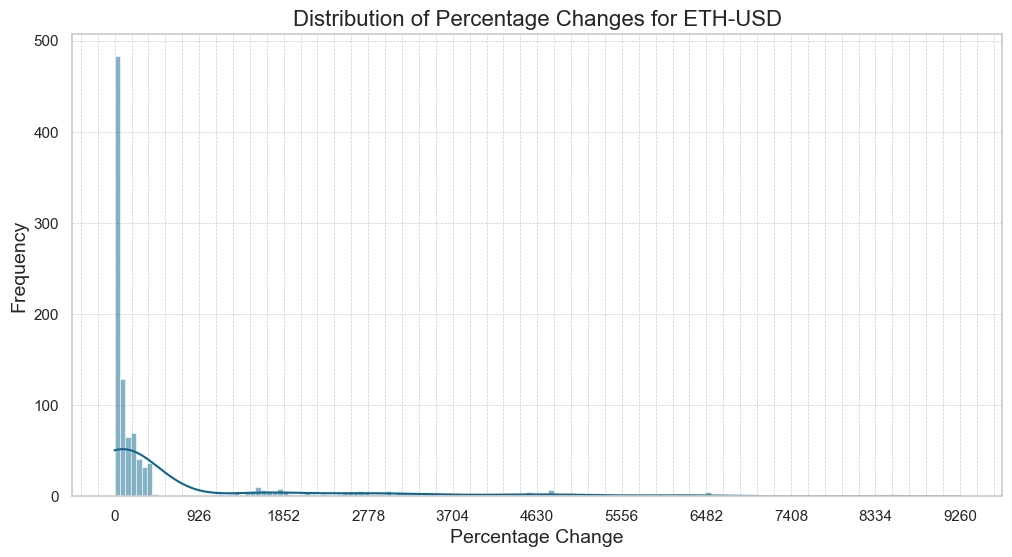

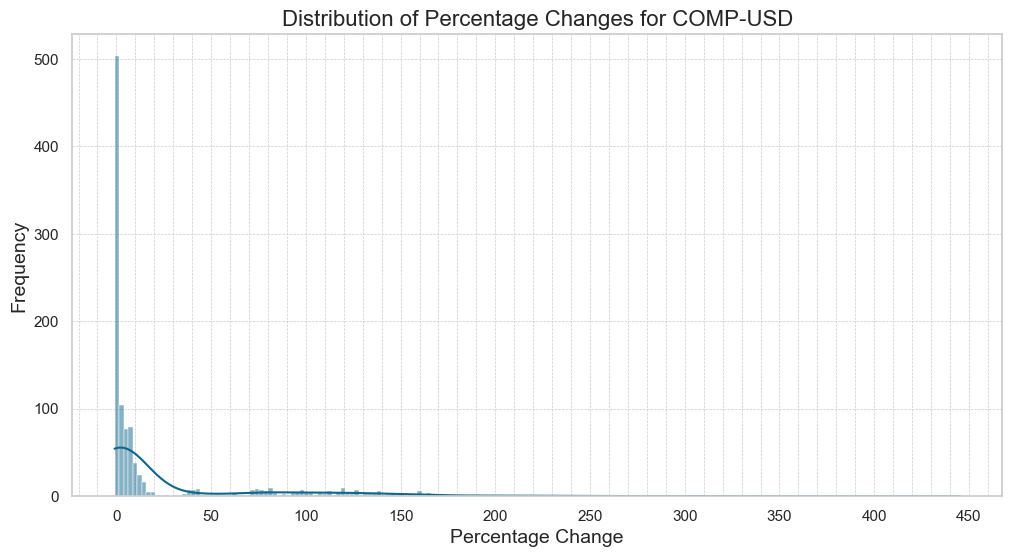

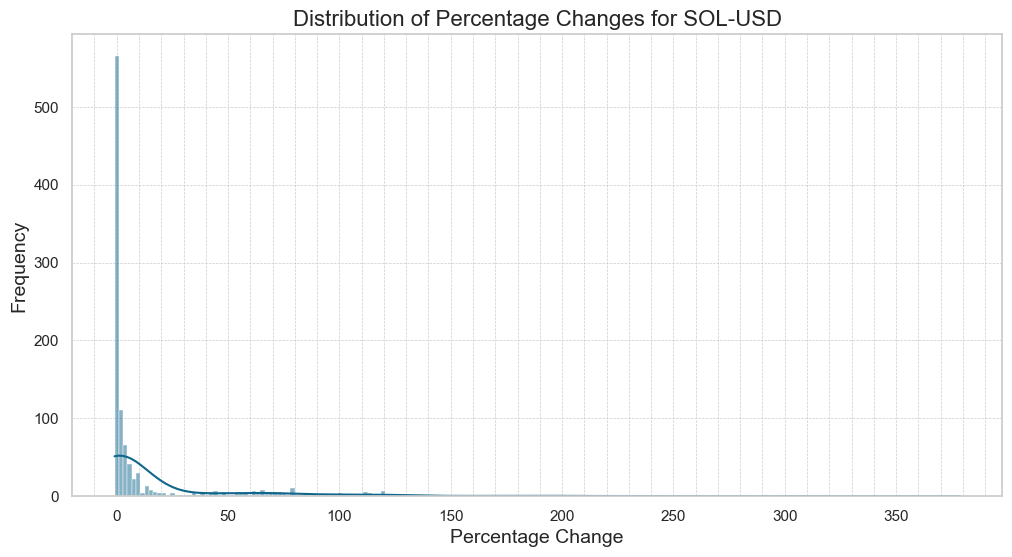

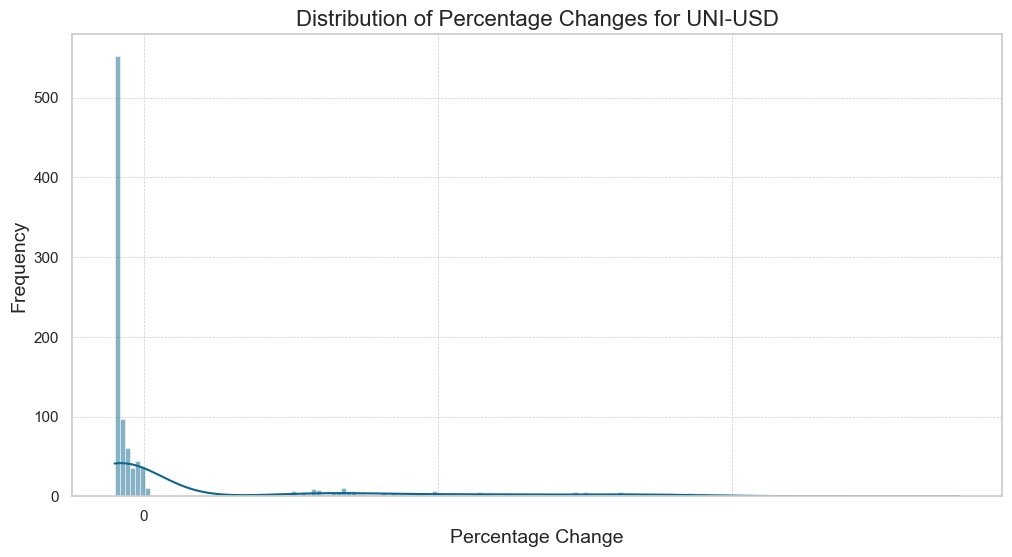

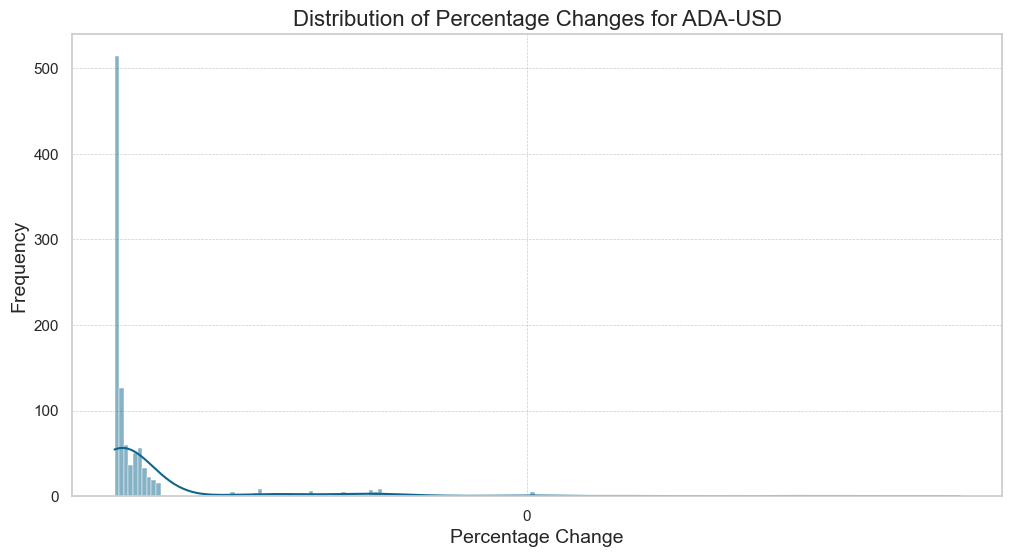

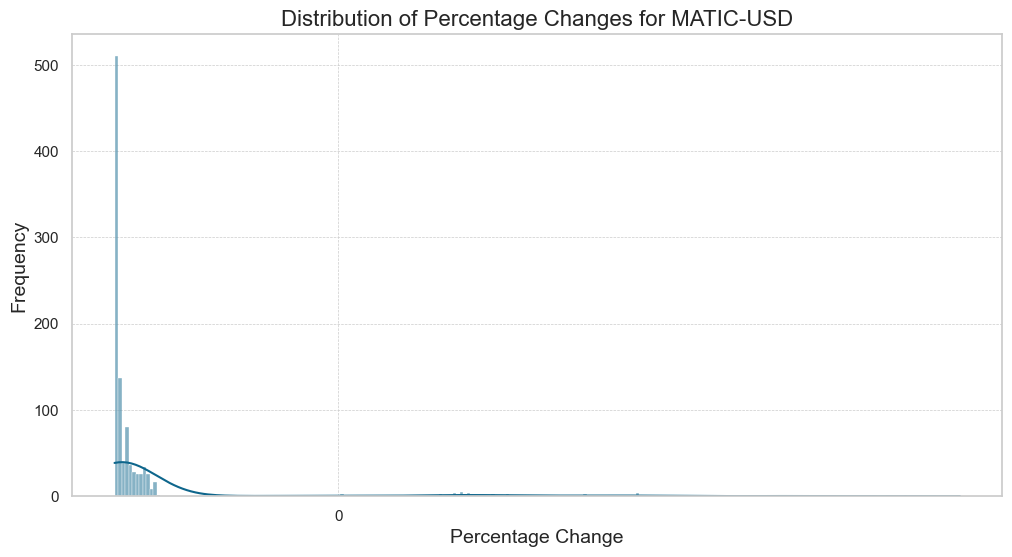

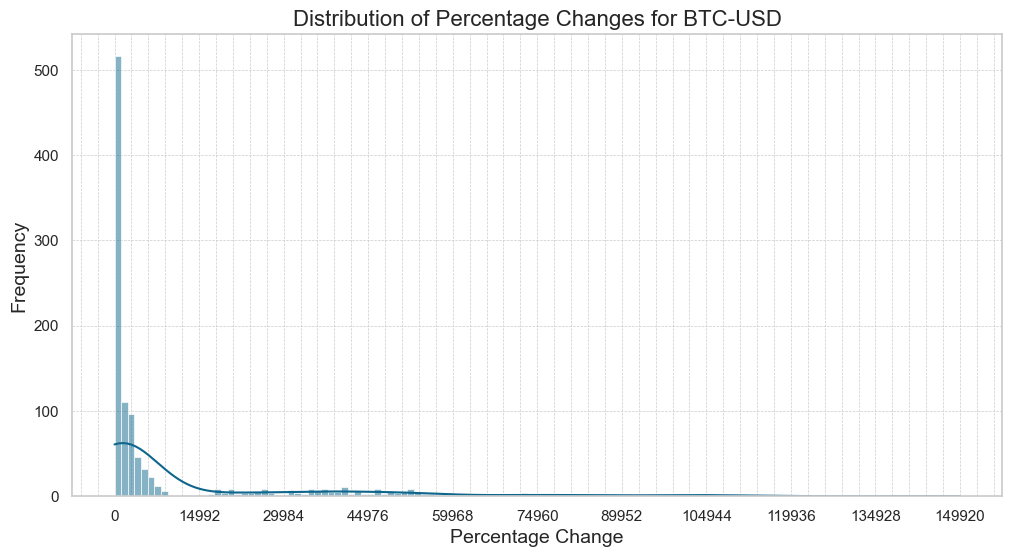

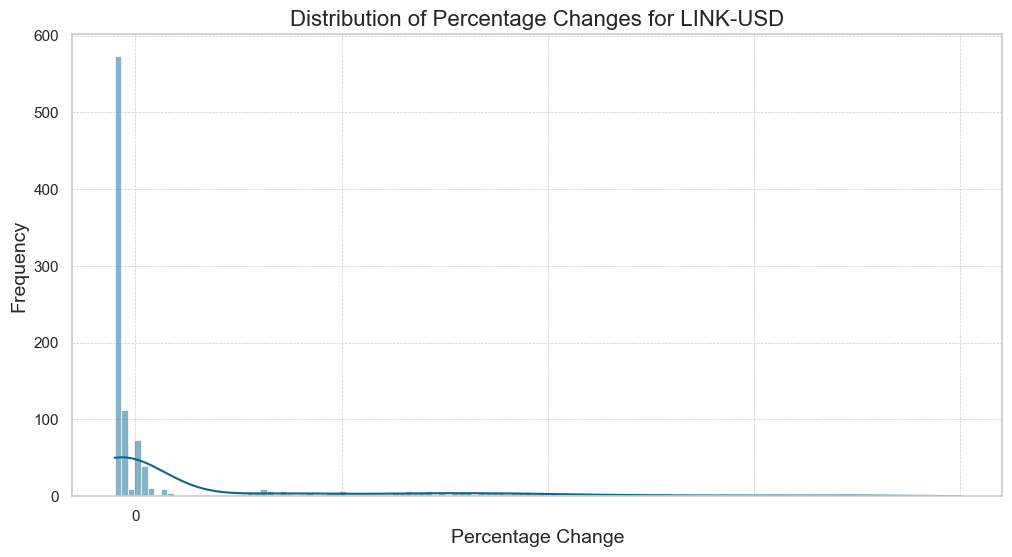

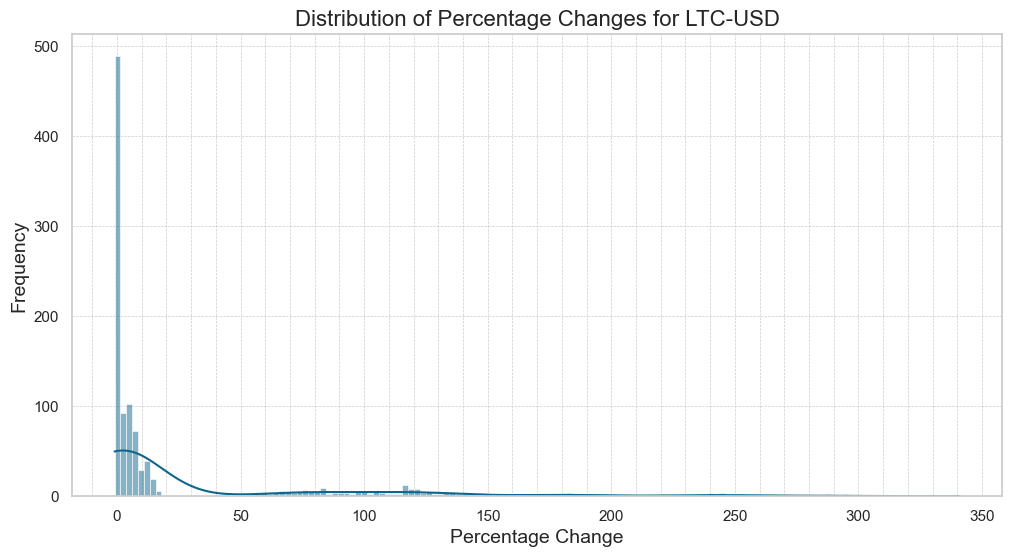

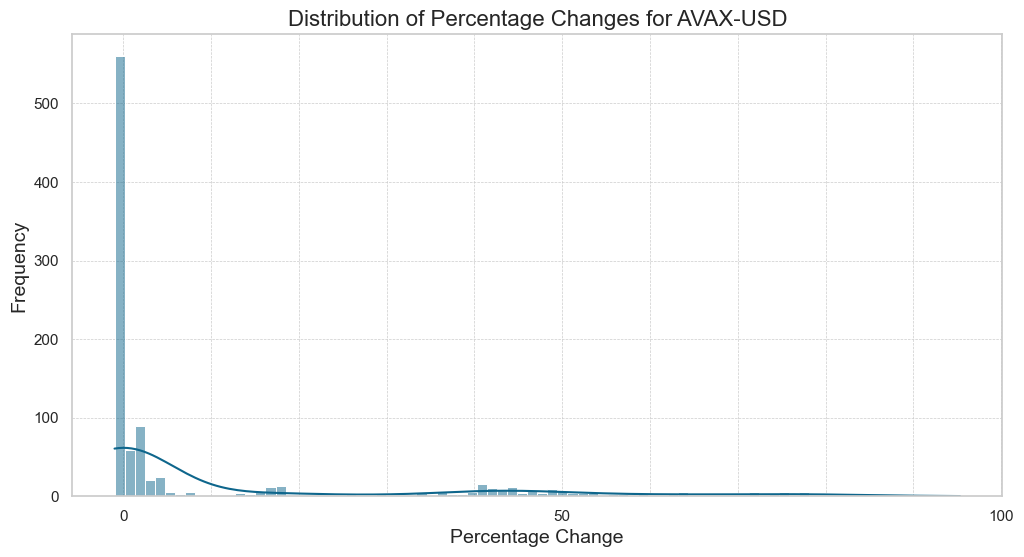

In [ ]:
# Setting the style
sns.set(style="whitegrid")

# Distribution of percentage changes per cryptocurrency
for coin in data['product_id'].unique():
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(data[data['product_id'] == coin]['pct_change'], kde=True, color='#0e668c')
    
    # Formatting the plot
    ax.set_title(f'Distribution of Percentage Changes for {coin}', fontsize=16)
    ax.set_xlabel('Percentage Change', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    
    # Handling extreme values by setting custom ticks based on data range
    pct_range = data[data['product_id'] == coin]['pct_change'].max() - data[data['product_id'] == coin]['pct_change'].min()
    if pct_range > 1000:
        major_tick = int(pct_range / 10)  # reduce number of major ticks for wide ranges
    else:
        major_tick = 50  # default tick setting for closer ranges
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_tick))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(major_tick / 5))  # smaller increments
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.show()


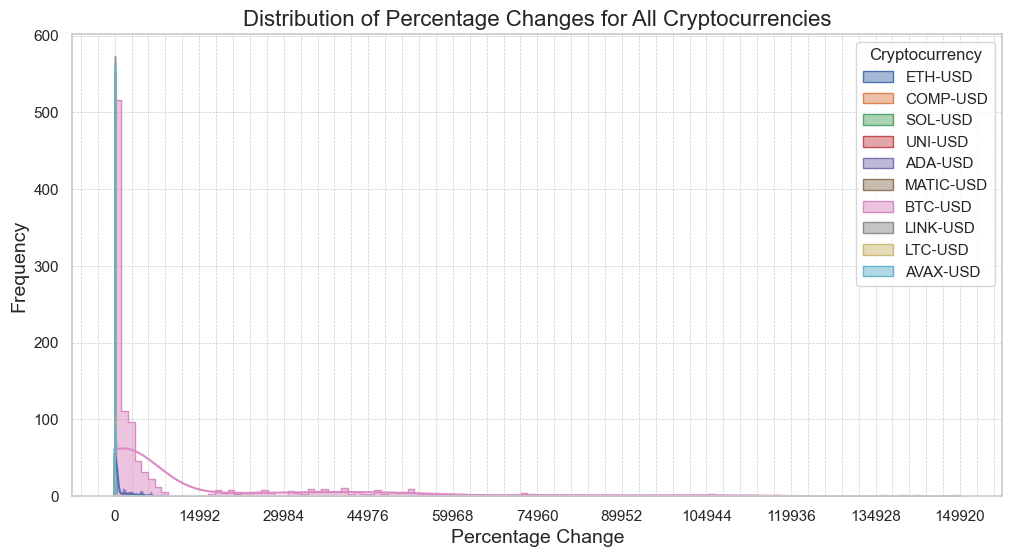

In [64]:
# Setting the style
sns.set(style="whitegrid")

# Ensuring there are no duplicate labels in 'product_id'
data_cleaned = data.drop_duplicates(subset=['product_id', 'pct_change'])

# Plotting the distribution of percentage changes for all cryptocurrencies in a single plot
plt.figure(figsize=(12, 6))

# Using loop to avoid reindexing issue
for coin in data_cleaned['product_id'].unique():
    sns.histplot(data=data_cleaned[data_cleaned['product_id'] == coin], x='pct_change', kde=True, label=coin, element='step')

# Formatting the plot
plt.title('Distribution of Percentage Changes for All Cryptocurrencies', fontsize=16)
plt.xlabel('Percentage Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Handling extreme values by setting custom ticks based on data range
pct_range = data_cleaned['pct_change'].max() - data_cleaned['pct_change'].min()
if pct_range > 1000:
    major_tick = int(pct_range / 10)  # reduce number of major ticks for wide ranges
else:
    major_tick = 50  # default tick setting for closer ranges

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(major_tick))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(major_tick / 5))  # smaller increments
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())

# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to distinguish cryptocurrencies
plt.legend(title='Cryptocurrency')

plt.show()


### Partial Autocorrelation Function (PACF) analysis

<Figure size 1200x600 with 0 Axes>

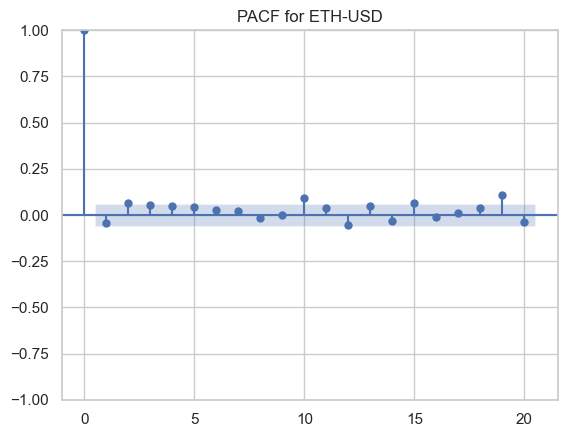

<Figure size 1200x600 with 0 Axes>

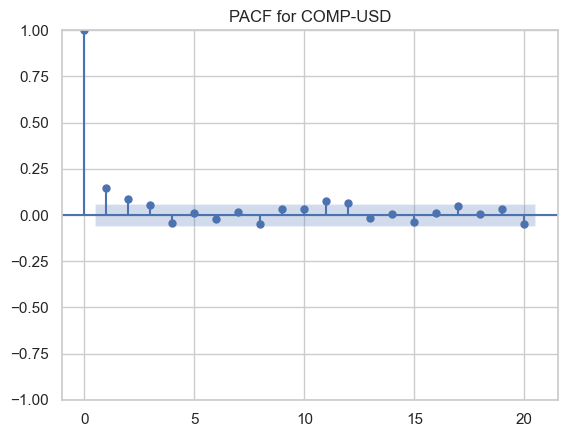

<Figure size 1200x600 with 0 Axes>

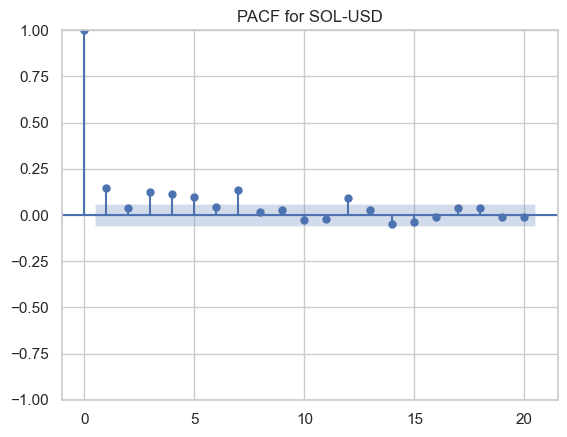

<Figure size 1200x600 with 0 Axes>

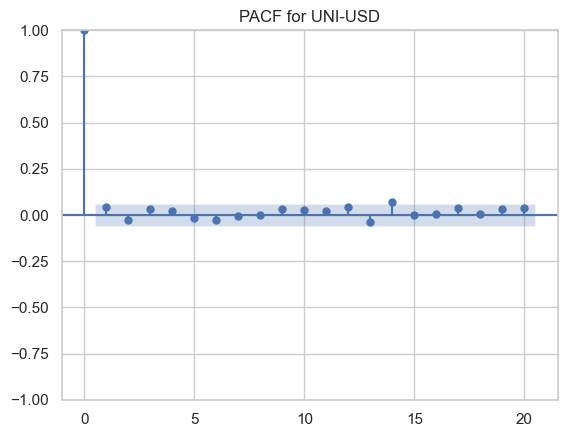

<Figure size 1200x600 with 0 Axes>

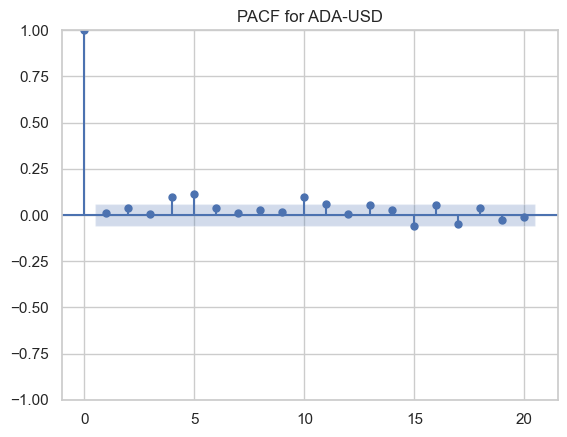

<Figure size 1200x600 with 0 Axes>

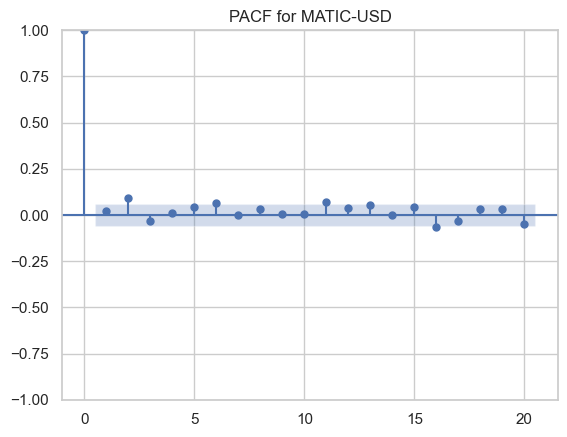

<Figure size 1200x600 with 0 Axes>

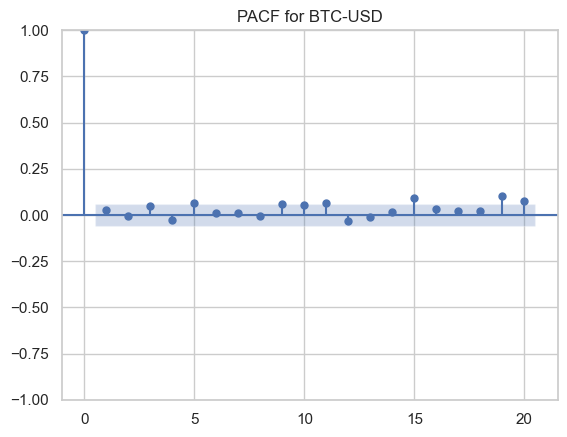

<Figure size 1200x600 with 0 Axes>

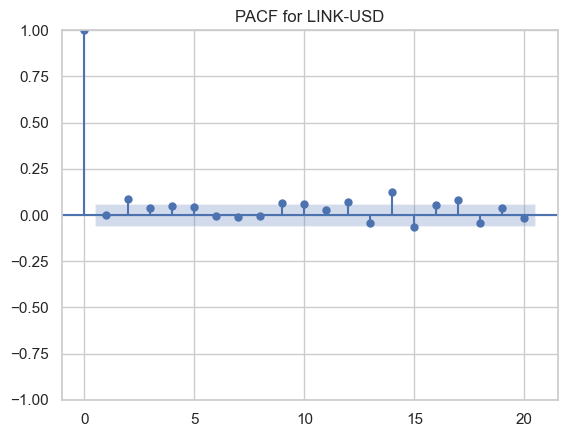

<Figure size 1200x600 with 0 Axes>

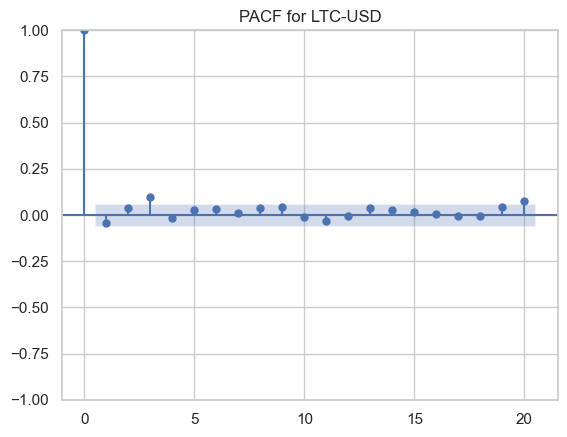

<Figure size 1200x600 with 0 Axes>

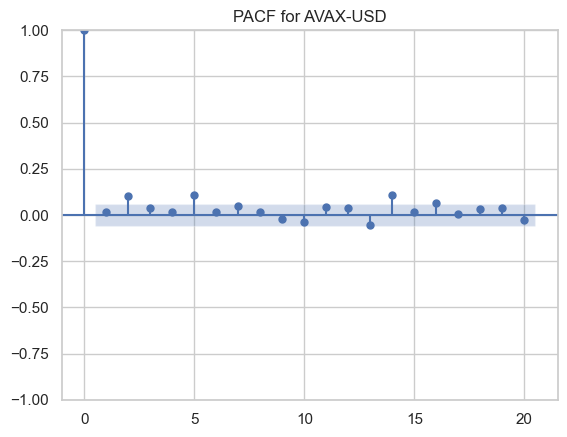

In [ ]:
# Function to plot PACF
def plot_pacf_for_coin(coin_data, coin_name, lags=20):
    plt.figure(figsize=(12, 6))
    sm.graphics.tsa.plot_pacf(coin_data.dropna(), lags=lags, title=f'PACF for {coin_name}')
    plt.show()

# Iterate over each cryptocurrency
for coin in data['product_id'].unique():
    # Assuming 'pct_change' is the column of interest
    coin_data = data[data['product_id'] == coin]['pct_change']
    plot_pacf_for_coin(coin_data, coin)

#### Data Preprocessing

In [ ]:
# Feature Engineering: Create moving averages and lag features
data['moving_avg_7'] = data['close'].rolling(window=7).mean()
data['moving_avg_30'] = data['close'].rolling(window=30).mean()

In [ ]:
# Create lag features
for lag in range(1, 8):
    data[f'lag_{lag}'] = data['close'].shift(lag)

In [ ]:
# Drop rows with NaN values created by rolling and shifting
data.dropna(inplace=True)

In [ ]:
# Select features and target
features = data.drop(columns=['time', 'product_id', 'close'])
target = data['close']

In [ ]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shape of the training and test sets
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

In [ ]:
# Convert the scaled features back to a DataFrame for easier plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features.columns)

# Plot the distribution of features before normalization
plt.figure(figsize=(15, 10))
for i, column in enumerate(features.columns, 1):
    plt.subplot(4, 4, i)
    plt.hist(X_train[column], bins=50, alpha=0.5, label='Original')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle('Feature Distribution Before Normalization', y=1.02)
plt.show()


#### Model Training

##### Baseline Model: Linear Regression

In [ ]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression MAE: {mae_lr}')
print(f'Linear Regression RMSE: {rmse_lr}')
print(f'Linear Regression R-squared: {r2_lr}')

##### Advanced Model: Random Forest

In [ ]:
# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MAE: {mae_rf}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

##### Advanced Model: Gradient Boosting

In [ ]:
# Train a Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the Gradient Boosting model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting MAE: {mae_gb}')
print(f'Gradient Boosting RMSE: {rmse_gb}')
print(f'Gradient Boosting R-squared: {r2_gb}')

#### Model Evaluation

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Random Forest)')
plt.legend()
plt.show()

In [ ]:
# Plot residuals
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.show()

In [ ]:
# Feature importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.show()

In [ ]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=features.columns)

##### Comparison of Models

In [ ]:
# Initialize a dictionary to store the results
results = {}
results['Linear Regression'] = {'MAE': mae_lr, 'RMSE': rmse_lr, 'R-squared': r2_lr}
results['Random Forest'] = {'MAE': mae_rf, 'RMSE': rmse_rf, 'R-squared': r2_rf}
results['Gradient Boosting'] = {'MAE': mae_gb, 'RMSE': rmse_gb, 'R-squared': r2_gb}

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

In [ ]:
# Plot actual vs. predicted values for Gradient Boosting
y_pred_best = y_pred_gb  # Predictions from the best model (Gradient Boosting)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Best Model: Gradient Boosting)')
plt.legend()
plt.show()

# Plot residuals for Gradient Boosting
residuals_best = y_test - y_pred_best
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals_best, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Best Model: Gradient Boosting)')
plt.show()


In [ ]:
# Feature importance for the best model (Gradient Boosting)
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Gradient Boosting)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.show()


In [ ]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=features.columns)
